<a href="https://colab.research.google.com/github/DARWICHAli/notebooks/blob/main/data_protection_project_2_1_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install sklearn-genetic-opt
!pip install psutil
!pip install nvidia-ml-py3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 139 kB 8.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for nvidia-ml-py3: filename=nvidia_ml_py3-7.352.0-py3-none-any.whl size=19190 sha256=42a15b573d87eff6e4487fea4a947a0476dfdc765d0d832bcccd77fad1057474
  Stored in directory: /root/.cache/pip/wheels/df/99/da/c34f202dc8fd1dffd35e0ecf1a7d7f8374ca05fbcbaf974b83
Successfully built nvidia-ml-py3


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## Library to Install
#!pip install sklearn-genetic-opt
#!pip install psutil
#!pip install nvidia-ml-py3

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from multiprocessing import Process, Queue
import time


# Importing the required libraries
import psutil
import nvidia_smi

# Creating an almost infinite for loop to monitor the details continuously
def check_ressources(q, msg, t=50):
    nvidia_smi.nvmlInit()
    i = 0
    cpu_usage = []
    mem_usage = []
    gpus = nvidia_smi.nvmlDeviceGetCount()
    time = []
    gpus_usage = {}
    while(q.empty()):
        # Obtaining all the essential details
        cpu_usage.append(psutil.cpu_percent())
        mem_usage.append(psutil.virtual_memory().percent)
        for gpu in range(gpus):
            handle = nvidia_smi.nvmlDeviceGetHandleByIndex(gpu)
            info = nvidia_smi.nvmlDeviceGetMemoryInfo(handle)
            if gpu in gpus_usage.keys():
                gpus_usage[gpu].append((info.used/info.total)*100)
            else:
                gpus_usage[gpu] = [(info.used/info.total)*100]
        time.append(i)
        i = i + t
        plt.pause(t/1e3)
    plt.xlabel("Time in ms")
    plt.ylabel("Percentage of usage")
    plt.plot(time, cpu_usage, color = "red", linestyle = 'dotted')
    plt.plot(time, mem_usage, color = "blue", linestyle = 'dotted')
    legend = ["CPU", "Memory"]
    for gpu in gpus_usage:
        legend.append(f'GPU Usage ID {gpu}')
        plt.plot(time, gpus_usage[gpu], linestyle = 'dotted')
    plt.legend(legend, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(f"Ressource Plot: for {msg}")
    print(q.get())
    plt.show()
    nvidia_smi.nvmlShutdown()

def auprc_multiclass(y_test, y_pred, classes):
    yt = preprocessing.label_binarize(y_test, classes=classes)
    yp = preprocessing.label_binarize(y_pred, classes=classes)
    precision, recall, _ = metrics.precision_recall_curve(yt.ravel(),yp.ravel())
    return metrics.auc(recall, precision)

def plot_confusion_matrix(y_test, y_pred):
    plt.figure(figsize=(12,10))
    sns.set(font_scale=1.2)
    sns.heatmap(
      confusion_matrix(y_test, y_pred),
      xticklabels=np.unique(y_pred),
      yticklabels=np.unique(y_test),
      annot=True,
      annot_kws={"size": 12}, fmt='g')

    plt.title("Confusion matrix")
    plt.show()

class Malware_Detection:
    def __init__(self, dataset="MalMen2020", verbose=False, optimization=True, lines=-1):
        if dataset == "MalMen2020":
            dfs = [pd.read_csv("/content/drive/MyDrive/Obfuscated-MalMem2022.csv")]
        elif dataset == "ADFA-LD":
            self.type_g = ['3-gramme', '5-gramme', '6-gramme']
            dfs = [pd.read_csv("/content/drive/MyDrive/ADFA-LD/train_3g.csv"),
                   pd.read_csv("/content/drive/MyDrive/ADFA-LD/train_5g.csv"),
                   pd.read_csv("/content/drive/MyDrive/ADFA-LD/train_6g.csv")]
        else:
            raise ValueError( "Error: Unknow Dataset Please Choose either MalMen2020 or ADFA-LD")
        self.verbose = verbose
        self.dataset = dataset
        self.opt = optimization
        self.df = None
        print(f"Preprocessing the Dataset {dataset} in progress ...")
        for df in dfs:
            self.preprocessing(df)
        print('Processing Done !')
        if lines != -1:
            print(f"Only {lines} rows will be used from the Dataset {dataset}....")
            self.dataset_crop(lines)
        self.output_evaluation = pd.DataFrame()
    def dataset_crop(self, lines):
        if self.dataset == "MalMen2020":
            if lines >= len(self.df):
                raise ValueError(f'Number of rows selected is {lines} >= number of rows in the dataset')
            benign_dataset = self.df[self.df['Class'] == 'Benign']
            total_rows = len(benign_dataset)
            frac = ((lines/2 + 1)/total_rows)
            benign_dataset = benign_dataset.sample(frac=frac)
            self.df = self.df[self.df['Class'] != 'Benign']
            malware_sub = self.df['Category_Subfamily'].unique()
            nb_subs = len(malware_sub)
            list_dataset = [benign_dataset]
            for mal in malware_sub:
                malware_dataset = self.df[self.df['Category_Subfamily'] == mal]
                total_rows = len(malware_dataset)
                frac = ((lines/2 + 1)/nb_subs)/total_rows
                list_dataset.append(malware_dataset.sample(frac=frac))
            self.df = pd.concat(list_dataset)
        else:
            for i,df in enumerate(self.df):
                if lines >= len(df):
                    raise ValueError(f'Number of rows selected is {lines} >= number of rows in the dataset')
                benign_dataset = df[df['Label'] == 'Normal']
                total_rows = len(benign_dataset)
                frac = ((lines/2 + 1)/total_rows)
                benign_dataset = benign_dataset.sample(frac=frac)
                df = df[df['Label'] != 'Normal']
                malware_sub = df['Label'].unique()
                nb_subs = len(malware_sub)
                list_dataset = [benign_dataset]
                for mal in malware_sub:
                    malware_dataset = df[df['Label'] == mal]
                    total_rows = len(malware_dataset)
                    frac = ((lines/2 + 1)/nb_subs)/total_rows
                    list_dataset.append(malware_dataset.sample(frac=frac))
                self.df[i] = pd.concat(list_dataset)





    def init_model(self,  model_name_binary='CART',model_name_family='CART', model_name_subfamily='CART'):
        from sklearn.model_selection import train_test_split
        if self.dataset == "MalMen2020":
            print(f"Pipeline : Training for Malware/Benign Classification Model Used: {model_name_binary} <====> Malware Family Classification Model Used: {model_name_family} <===> Malware Sub Family Classification Model Used: {model_name_subfamily}")
            # Training for Malware/Benign Classification
            X = self.df.copy(deep=True)
            y_bin = X['Class']
            X = X.drop(['Class', 'Category_Subfamily', 'Category_Family'], axis=1)
            y_bin_ = y_bin.map({x:i for i,x in enumerate(y_bin.unique())})
            X_train, X_test, y_train, y_test = train_test_split(X, y_bin_, test_size=0.2, random_state=1) # 80% training and 20% test

            #Ressource Check
            q = Queue()
            p = Process(target=check_ressources, args=(q, f"Training for Malware/Benign Classification Model Used: {model_name_binary}", 5))
            p.start()
            self.model_b = self.fit_model(model_name_binary, X_train, y_train)
            q.put('Done')
            p.join()

            y_pred = self.model_b.predict(X_test)

            y_pred = y_pred.astype(str)
            y_test = y_test.astype(str)
            for i,x in enumerate(y_bin.unique()):
                y_pred[y_pred == str(i)] = x
                y_test[y_test == str(i)] = x
            print(f"Evaluation of Malware/Benign Classification for {model_name_binary} Algorithm")
            self.evaluate_model(y_test, y_pred, y_bin.unique(), model_name_binary, "Malware/Benign Classification")

            # Training for Malware Family Classification
            X = self.df[self.df['Category_Family'] != 'Benign'].copy(deep=True)
            y_f = X['Category_Family']
            X = X.drop(['Class', 'Category_Subfamily', 'Category_Family'], axis=1)
            y_f_ = y_f.map({x:i for i,x in enumerate(y_f.unique())})
            X_train, X_test, y_train, y_test = train_test_split(X, y_f_, test_size=0.2, random_state=1) # 80% training and 20% test

            # Ressource Check
            q = Queue()
            p = Process(target=check_ressources, args=(q, f"Malware Family Classification Model Used: {model_name_family}"))
            p.start()
            self.model_f = self.fit_model(model_name_family, X_train, y_train)
            q.put('Done')
            p.join()



            y_pred = self.model_f.predict(X_test)
            y_pred = y_pred.astype(str)
            y_test = y_test.astype(str)
            for i,x in enumerate(y_f.unique()):
                y_pred[y_pred == str(i)] = x
                y_test[y_test == str(i)] = x

            print(f"Evaluation of Malware Family Classification for {model_name_family} Algorithm")
            self.evaluate_model(y_test, y_pred, y_f.unique(), model_name_family, "Malware Family Classification")

            # Training for Malware Sub Family Classification
            X = self.df[self.df['Category_Family'] != 'Benign'].copy(deep=True)
            Xs = [X[X['Category_Family'] == f] for f in X['Category_Family'].unique()]
            y_sfs = [x['Category_Subfamily'] for x in Xs]
            for X, y_sf in zip(Xs, y_sfs):
                fam = X['Category_Family'].unique()
                X = X.drop(['Class', 'Category_Subfamily', 'Category_Family'], axis=1)
                y_sf_ = y_sf.map({x:i for i,x in enumerate(y_sf.unique())})
                X_train, X_test, y_train, y_test = train_test_split(X, y_sf_, test_size=0.2, random_state=1) # 80% training and 20% test
                # Ressource Check
                q = Queue()
                p = Process(target=check_ressources, args=(q, f"Malware Sub Family Classification Model Used: {model_name_subfamily}"))
                p.start()
                self.model_f = self.fit_model(model_name_subfamily, X_train, y_train)
                q.put('Done')
                p.join()
                y_pred = self.model_f.predict(X_test)
                y_pred = y_pred.astype(str)
                y_test = y_test.astype(str)
                for i,x in enumerate(y_sf.unique()):
                    y_pred[y_pred == str(i)] = x
                    y_test[y_test == str(i)] = x
                print(f"Evaluation of Malware Sub Family Classification for {model_name_subfamily} Algorithm")
                self.evaluate_model(y_test, y_pred, y_sf.unique(), model_name_subfamily, f"Malware Sub Family Classification {fam[0]}")
        else:
            for i,df in enumerate(self.df):
                print(f"Dataset Used : {self.type_g[i]}\n\n")
                print(f"Pipeline : Training for Attack/Normal Classification Model Used: {model_name_binary} <====> Attacks Family Classification Model Used: {model_name_family}")
                # Training for Attack/Normal Classification
                X = df.copy(deep=True)
                y_bin = X['Label']
                X = X.drop(['Label', 'ID'], axis=1)
                y_bin_ = y_bin.map({x:1 if x != "Normal" else 0 for x in y_bin.unique()})
                X_train, X_test, y_train, y_test = train_test_split(X, y_bin_, test_size=0.2, random_state=1) # 80% training and 20% test

                #Ressource Check
                q = Queue()
                p = Process(target=check_ressources, args=(q, f"Training for Attack/Normal Classification Model Used: {model_name_binary}", 10))
                p.start()
                self.model_b = self.fit_model(model_name_binary, X_train, y_train)
                q.put('Done')
                p.join()

                y_pred = self.model_b.predict(X_test)

                y_pred = y_pred.astype(str)
                y_test = y_test.astype(str)
                y_pred[y_pred == "0"] = 'Normal'
                y_pred[y_pred == "1"] = 'Attack'
                y_test[y_test == "0"] = 'Normal'
                y_test[y_test == "1"] = 'Attack'
                print(f"Evaluation of Attack/Normal Classification for {model_name_binary} Algorithm")
                self.evaluate_model(y_test, y_pred, y_bin.unique(), model_name_binary, "Attack/Normal Classification")

                # Training for Attacks Family Classification
                X = df[df['Label'] != 'Normal'].copy(deep=True)
                y_f = X['Label']
                X = X.drop(['ID', 'Label'], axis=1)
                y_f_ = y_f.map({x:i for i,x in enumerate(y_f.unique())})
                X_train, X_test, y_train, y_test = train_test_split(X, y_f_, test_size=0.2, random_state=1) # 80% training and 20% test

                # Ressource Check
                q = Queue()
                p = Process(target=check_ressources, args=(q, f"Attacks Family Classification Model Used: {model_name_family}"))
                p.start()
                self.model_f = self.fit_model(model_name_family, X_train, y_train)
                q.put('Done')
                p.join()



                y_pred = self.model_f.predict(X_test)
                y_pred = y_pred.astype(str)
                y_test = y_test.astype(str)
                for i,x in enumerate(y_f.unique()):
                    y_pred[y_pred == str(i)] = x
                    y_test[y_test == str(i)] = x

                print(f"Evaluation of Attacks Family Classification Classification for {model_name_family} Algorithm")
                self.evaluate_model(y_test, y_pred, y_f.unique(), model_name_family, "Attacks Family Classification")

            display(self.output_evaluation)




    def evaluate_model(self, y_test, y_pred, cat, model_name, title):
        self.output_evaluation = self.output_evaluation.append({
                            'Model':model_name,
                            'Precision': metrics.precision_score(y_test, y_pred, average='micro'),
                            'Recall': metrics.recall_score(y_test, y_pred, average='micro'),
                            'Balanced Accuracy': metrics.balanced_accuracy_score(y_test, y_pred),
                            'Matthews Correlation Coefficient': metrics.matthews_corrcoef(y_test, y_pred),
                            'AUPRC': auprc_multiclass(y_test, y_pred, cat),
                            'Time Taken': self.delta * 1000,
                            'Evaluation': title}, ignore_index=True)
        print(f"Precision:{metrics.precision_score(y_test, y_pred, average='micro')}\n")
        print(f"Recall:{metrics.recall_score(y_test, y_pred, average='micro')}\n")
        print(f"Accuracy:{metrics.accuracy_score(y_test, y_pred)}\n")
        print(f"Balanced Accuracy:{metrics.balanced_accuracy_score(y_test, y_pred)}\n")
        print(f"Matthews Correlation Coefficient:{metrics.matthews_corrcoef(y_test, y_pred)}\n")
        print(f"AUPRC:{auprc_multiclass(y_test, y_pred, cat)}\n")
        print(f"Time Taken: {self.delta * 1000} ms\n")
        plot_confusion_matrix(y_test, y_pred)

    def cross_validation_ga(self, model, X_train,y_train, param_grid):
        from sklearn_genetic import GASearchCV
        from sklearn_genetic import ExponentialAdapter
        from sklearn.model_selection import StratifiedKFold

        # Instantiate the GA search model
        mutation_adapter = ExponentialAdapter(initial_value=0.8, end_value=0.2, adaptive_rate=0.1)
        crossover_adapter = ExponentialAdapter(initial_value=0.2, end_value=0.8, adaptive_rate=0.1)
        cv = StratifiedKFold(n_splits=3, shuffle=True)
        evolved_estimator = GASearchCV(estimator=model,
                               cv=cv,
                               scoring='accuracy',
                               population_size=20,
                               generations=20,
                               mutation_probability=mutation_adapter,
                               crossover_probability=crossover_adapter,
                               param_grid=param_grid,
                               n_jobs=-1)
        evolved_estimator.fit(X_train, y_train)
        return evolved_estimator

    def fit_model(self, model_name, X_train, y_train):
        start = time.time()
        if model_name == 'CART':
            from sklearn.tree import DecisionTreeClassifier
            model = DecisionTreeClassifier(splitter='best', max_depth=8, min_samples_leaf=100)
            if self.opt:
                from sklearn_genetic.space import Categorical, Integer
                param_grid = {
                'criterion':Categorical(['gini','entropy']),
                'splitter':Categorical(['best','random']),
                'min_samples_leaf':Integer(100,300),
                'max_depth':Integer(3,8),
                }
                model = self.cross_validation_ga(model, X_train, y_train, param_grid)
                with open(f"{model_name}-best.txt", "a") as f:
                    f.write(f"{model.best_params_}\n\n\n")
                    f.close()
                return model
        elif model_name == 'XGBOOST':
            import xgboost as xgb
            model = xgb.XGBClassifier(objective= 'binary:logistic', n_estimators= 268, max_depth= 8, learning_rate=0.08455776011574645, tree_method='gpu_hist')
            if self.opt:
                from sklearn_genetic.space import Categorical, Integer, Continuous
                param_grid = {
                'objective':Categorical(['binary:logistic','multi:softmax']),
                'n_estimators':Integer(100,300),
                'max_depth':Integer(3,8),
                'learning_rate':Continuous(0.001, 0.1),
                }
                model = self.cross_validation_ga(model, X_train, y_train, param_grid)
                with open(f"{model_name}-best.txt", "a") as f:
                    f.write(f"{model.best_params_}\n\n\n")
                    f.close()
                return model
        elif model_name == 'SVM':
            from sklearn import svm
            from sklearn.pipeline import make_pipeline
            model = make_pipeline(StandardScaler(), svm.SVC(random_state=0,kernel='linear', decision_function_shape='ovo'))
            if self.opt:
                model = svm.SVC(random_state=0,kernel='linear', decision_function_shape='ovo')
                from sklearn_genetic.space import Categorical, Integer, Continuous
                param_grid = {
                'kernal':Categorical(['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']),
                'gamma':Categorical(['auto','scale']),
                'decision_function_shape':Categorical(['ovr','ovo'])
                }
                model = self.cross_validation_ga(model, StandardScaler(X_train), y_train, param_grid)
                with open(f"{model_name}-best.txt", "a") as f:
                    f.write(f"{model.best_params_}\n\n\n")
                    f.close()
                return make_pipeline(StandardScaler(), model)
        elif model_name == 'KNN':
            from sklearn.neighbors import KNeighborsClassifier
            model = KNeighborsClassifier()
            if self.opt:
                from sklearn_genetic.space import Categorical, Integer, Continuous
                param_grid = {
                'weights':Categorical(['uniform','distance']),
                'n_neighbors':Integer(3,9),
                'leaf_size':Integer(20,50),
                'algorithm':Categorical(['auto','ball_tree', 'kd_tree', 'brute']),
                }
                model = self.cross_validation_ga(model, X_train, y_train, param_grid)
                with open(f"{model_name}-best.txt", "a") as f:
                    f.write(f"{model.best_params_}\n\n\n")
                    f.close()
                return model
        elif model_name == 'RandomForest':
            from sklearn.ensemble import RandomForestClassifier
            model = RandomForestClassifier()
            if self.opt:
                from sklearn_genetic.space import Categorical, Integer, Continuous
                param_grid = {
                'criterion':Categorical(['gini','entropy']),
                'min_samples_split':Integer(1,10),
                'max_depth':Integer(3,8),
                }
                model = self.cross_validation_ga(model, X_train, y_train, param_grid)
                with open(f"{model_name}-best.txt", "a") as f:
                    f.write(f"{model.best_params_}\n\n\n")
                    f.close()
                return model
        elif model_name == 'MLP':
            from sklearn.neural_network import MLPClassifier
            model = MLPClassifier(random_state=1, max_iter=300)
            if self.opt:
                from sklearn_genetic.space import Categorical, Integer, Continuous
                param_grid = {
                'activation':Categorical(['identité', 'logistique', 'tanh', 'relu']),
                'solveur':Categorical(['lbfgs', 'sgd', 'adam']),
                'max_iter':Integer(100,500),
                }
                model = self.cross_validation_ga(model, X_train, y_train, param_grid)
                with open(f"{model_name}-best.txt", "a") as f:
                    f.write(f"{model.best_params_}\n\n\n")
                    f.close()
                return model
        else:
            raise ValueError( "Model not Implemented yet. Please Choose between : CART, RandomForest, KNN, XGBOOST, MLP and SVM")
        model.fit(X_train, y_train)
        self.delta = time.time() - start
        return model
    def is_malware(self, model, malware_features):
        return (Boolean, probability)
    def pca(self, X, y_bin, y_f, y_sf=None):
        from sklearn.decomposition import PCA
        from sklearn.preprocessing import StandardScaler
        # Scale data before applying PCA
        scaling=StandardScaler()
        # Use fit and transform method
        scaling.fit(X)
        Scaled_X=scaling.transform(X)
        principal=PCA()
        principal.fit(Scaled_X)
        #Let's find how many compenents do we need to preserve 80% of the explained variance
        nb_cmp = 0
        for i,x in enumerate(principal.explained_variance_ratio_.cumsum()):
            if x >= 0.8:
                nb_cmp = i
                print(next(f'Number of components : {n} , Value of Cumulative Explained Variance: {x}' ))
                break
        #Visualization
        plt.figure(figsize = (15,8))
        plt.plot(range(1,len(X.columns)+1), principal.explained_variance_ratio_.cumsum(), linestyle = '--', marker = 'o')
        _ = plt.title('Explained Variance by Components')
        _ = plt.xlabel('Number of components')
        _ = plt.ylabel('Cumulative Explained Variance')
        principal=PCA(n_components = nb_cmp)
        principal.fit(Scaled_X)
        x=principal.transform(Scaled_X)
        plt.figure(figsize=(10,10))
        ax = plt.axes(projection ="3d")
        ax.scatter3D(x[:,0],x[:,1],x[:,2],c=y_bin.tolist(),cmap='plasma')
        _ = plt.xlabel('First Component')
        _ = plt.ylabel('Second Component')
        _ = ax.set_zlabel('Third Component')
        plt.figure(figsize=(10,10))
        ax = plt.axes(projection ="3d")
        ax.scatter3D(x[:,0],x[:,1],x[:,2],c=y_f.tolist(),cmap='plasma')
        _ = plt.xlabel('First Component')
        _ = plt.ylabel('Second Component')
        _ = ax.set_zlabel('Third Component')
        if y_sf is not None:
            plt.figure(figsize=(10,10))
            ax = plt.axes(projection ="3d")
            ax.scatter3D(x[:,0],x[:,1],x[:,2],c=y_sf.tolist(),cmap='plasma')
            _ = plt.xlabel('First Component')
            _ = plt.ylabel('Second Component')
            _ = ax.set_zlabel('Third Component')
    def tsne(self, X, y_bin, y_f, y_sf=None):
        from sklearn.manifold import TSNE
        tsne = TSNE(n_components=3, verbose=(1 if self.verbose else 0), random_state=123)
        x = tsne.fit_transform(X)
        plt.figure(figsize=(10,10))
        ax = plt.axes(projection ="3d")
        ax.scatter3D(x[:,0],x[:,1],x[:,2],c=y_bin.tolist(),cmap='plasma')
        _ = plt.xlabel('First Component')
        _ = plt.ylabel('Second Component')
        _ = ax.set_zlabel('Third Component')
        plt.figure(figsize=(10,10))
        ax = plt.axes(projection ="3d")
        ax.scatter3D(x[:,0],x[:,1],x[:,2],c=y_f.tolist(),cmap='plasma')
        _ = plt.xlabel('First Component')
        _ = plt.ylabel('Second Component')
        _ = ax.set_zlabel('Third Component')
        if y_sf is not None:
            plt.figure(figsize=(10,10))
            ax = plt.axes(projection ="3d")
            ax.scatter3D(x[:,0],x[:,1],x[:,2],c=y_sf.tolist(),cmap='plasma')
            _ = plt.xlabel('First Component')
            _ = plt.ylabel('Second Component')
            _ = ax.set_zlabel('Third Component')
    def umap(self, X, y_bin, y_f, y_sf=None):
        from umap import UMAP
        umap = UMAP(n_components=3, verbose=1, random_state=123)
        x = umap.fit_transform(X)
        plt.figure(figsize=(10,10))
        ax = plt.axes(projection ="3d")
        ax.scatter3D(x[:,0],x[:,1],x[:,2],c=y_bin.tolist(),cmap='plasma')
        _ = plt.xlabel('First Component')
        _ = plt.ylabel('Second Component')
        _ = ax.set_zlabel('Third Component')
        plt.figure(figsize=(10,10))
        ax = plt.axes(projection ="3d")
        ax.scatter3D(x[:,0],x[:,1],x[:,2],c=y_f.tolist(),cmap='plasma')
        _ = plt.xlabel('First Component')
        _ = plt.ylabel('Second Component')
        _ = ax.set_zlabel('Third Component')
        if y_sf is not None:
            plt.figure(figsize=(10,10))
            ax = plt.axes(projection ="3d")
            ax.scatter3D(x[:,0],x[:,1],x[:,2],c=y_sf.tolist(),cmap='plasma')
            _ = plt.xlabel('First Component')
            _ = plt.ylabel('Second Component')
            _ = ax.set_zlabel('Third Component')

    def visualization(self, method='PCA'):
        print(f"Visualization of the dataset {self.dataset} in progress ... Method: {method}")
        if self.dataset == 'MalMen2020':
            plot_cols = ['Category_Family', 'Category_Subfamily']
            plot_names = ['Category Family', 'Category Subfamily']
            for c,n in zip(plot_cols, plot_names):
                fig = plt.figure(figsize=(30, 8))
                ax = sns.countplot(data=self.df, x=c)
                ax.set_title(f'Repartition of {n} in {self.dataset} Dataset', fontsize=20)
                _ = plt.xticks(rotation = 90, fontsize=18)
                _ = plt.xlabel(n,fontsize=14)
                _ = plt.ylabel("Count", fontsize=14)

            X = self.df.copy(deep=True)
            y_bin = X['Class']
            y_f = X['Category_Family']
            y_sf = X['Category_Subfamily']
            X = X.drop(['Class', 'Category_Subfamily', 'Category_Family'], axis=1)
            y_bin = y_bin.replace(['Benign', 'Malware'], ['green', 'red'])
            y_f = y_f.replace(['Benign', 'Ransomware' ,'Spyware', 'Trojan'], ['green', 'yellow', 'orange', 'red'])
            y_sf = y_sf.replace(y_sf.unique(), [x for x in range(len(y_sf.unique()))])
            if method == 'PCA':
                self.pca(X, y_bin, y_f, y_sf)
            elif method == 'TSNE':
                self.tsne(X, y_bin, y_f, y_sf)
            elif method == 'UMAP':
                self.umap(X, y_bin, y_f, y_sf)
            else:
                raise ValueError( "Only PCA, TSNE and UMAP are implemented make sure to choose only one of them.")
        else:
            for i, df in enumerate(self.df):
                fig = plt.figure(figsize=(30, 8))
                ax = sns.countplot(data=df, x='Label')
                ax.set_title(f'Repartition of Normal and Attack Labels in {self.dataset} Dataset: {self.type_g[i]}', fontsize=20)
                _ = plt.xticks(rotation = 90, fontsize=18)
                _ = plt.xlabel('Labels',fontsize=14)
                _ = plt.ylabel("Count", fontsize=14)

                fig = plt.figure(figsize=(30, 8))
                ax = sns.countplot(data=df[df['Label'] != "Normal"], x='Label')
                ax.set_title(f'Repartition of Attack Labels in {self.dataset} Dataset: {self.type_g[i]}', fontsize=20)
                _ = plt.xticks(rotation = 90, fontsize=18)
                _ = plt.xlabel('Attack Labels',fontsize=14)
                _ = plt.ylabel("Count", fontsize=14)

                X = df.copy(deep=True)
                y_bin = X['Label']
                y_bin = y_bin.map({x:"green" if x == "Normal" else "red" for x in y_bin.unique()})
                y_f = X['Label']
                X = X.drop(['Label'], axis=1)
                y_f = y_f.replace(y_f.unique(), [x for x in range(len(y_f.unique()))])
                if method == 'PCA':
                    self.pca(X, y_bin, y_f)
                elif method == 'TSNE':
                    self.tsne(X, y_bin, y_f)
                elif method == 'UMAP':
                    self.umap(X, y_bin, y_f)
                else:
                    raise ValueError( "Only PCA, TSNE and UMAP are implemented make sure to choose only one of them.")
        plt.show()



    def preprocessing(self, df):
        if self.verbose:
            # Exploring the Dataset:
            print(df.head())
            col = list(df.columns)
            print(f"Column number: {len(col)}\n")
            print(f"Column names: {col}\n")
            print(f"Column types: \n{df.dtypes}\n")
            print(f"Number of rows of the data set: {len(df)}\n")
            cat_col = df.select_dtypes('object')
            print(f"Categorial columns: \n{cat_col.columns}\n\n")
            for c in cat_col:
                print(f"Existing values of {c}: {cat_col[c].unique()}")

            num_col = df.select_dtypes(include=np.number)
            print(f"Numerical columns: \n{num_col.columns}\n\n")
            for c in num_col:
                print(f"Existing values of {c}: {num_col[c].unique()}")
                print(f"Min Value of {c}: {np.min(num_col[c])}")
                print(f"Max Value of {c}: {np.max(num_col[c])}")
                print(f"Std deviation Value of {c}: {np.std(num_col[c])}")
            if self.dataset == "MalMen2020":
                lookup_query = df.query('Class == "Malware" & Category != "Benign"').index
                print(f"Checking if the positive class (1) match malware categories : {len(lookup_query) > 0}")

                lookup_query = df.query('Category != "Benign" & Class == "Malware"').index
                print(f"Checking if the malware categories match Class : {len(lookup_query) > 0}")

                lookup_query = df.query('Class == "Benign" & Category == "Benign"').index
                print(f"Checking if the begnin class match the ‘Benign’ malware category : {len(lookup_query) > 0}")
                print(f"Number of malware class : {len(df[df['Class'] == 'Malware'])}, ratio : {(len(df[df['Class'] == 'Malware'])/len(df))*100:.2f}%")
                print(f"Number of benign class : {len(df[df['Class'] == 'Benign'])}, ratio : {(len(df[df['Class'] == 'Benign'])/len(df))*100:.2f}%")
            else:
                print(f"Number of malware class : {len(df[df['Label'] != 'Normal'])}, ratio : {(len(df[df['Label'] != 'Normal'])/len(df))*100:.2f}%")
                print(f"Number of benign class : {len(df[df['Label'] == 'Normal'])}, ratio : {(len(df[df['Label'] == 'Normal'])/len(df))*100:.2f}%")


        # Data Cleaning
        column_to_remove = []
        for c in df.columns:
            if len(df[c].unique()) == 1:
                column_to_remove.append(c)
        df = df.drop(column_to_remove, axis=1)
        if self.dataset == "MalMen2020":
            cat = df['Category'].tolist()
            cat_f = []
            cat_sf = []
            for x in cat:
                f_sf = x.split('-')
                if len(f_sf) >= 3:
                    cat_f.append(f_sf[0])
                    cat_sf.append(f_sf[0] + "-" + f_sf[1])
                elif len(f_sf) >= 2:
                    cat_f.append(f_sf[0])
                    cat_sf.append(f_sf[0])
                elif len(f_sf) >= 1:
                    cat_f.append(x)
                    cat_sf.append(x)
                else:
                    raise ValueError( f"Error : There is no Family in {x}")
            df['Category_Family'] = cat_f
            df['Category_Subfamily'] = cat_sf
            df = df.drop(['Category'], axis=1)
            if self.verbose:
                print(f"Number of occurrences for each malware class: \n{df['Category_Family'].value_counts()}")
                print(f"Number of occurrences for each malware class: \n{df['Category_Subfamily'].value_counts()}")
            self.df = df
        else:
            df = df.drop(['Unnamed: 0'], axis=1)
            if self.df is None:
                self.df = [df]
            else:
                self.df.append(df)



Preprocessing the Dataset MalMen2020 in progress ...
Processing Done !
Pipeline : Training for Malware/Benign Classification Model Used: CART <====> Malware Family Classification Model Used: CART <===> Malware Sub Family Classification Model Used: CART
Done


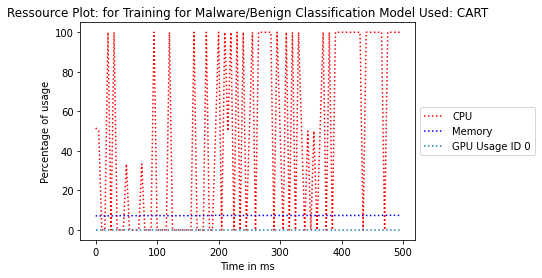

Evaluation of Malware/Benign Classification for CART Algorithm
Precision:0.9977815699658703

Recall:0.9977815699658703

Accuracy:0.9977815699658703

Balanced Accuracy:0.9977577015483894

Matthews Correlation Coefficient:0.9955641284995467

AUPRC:0.998589917802405

Time Taken: 558.5012435913086 ms



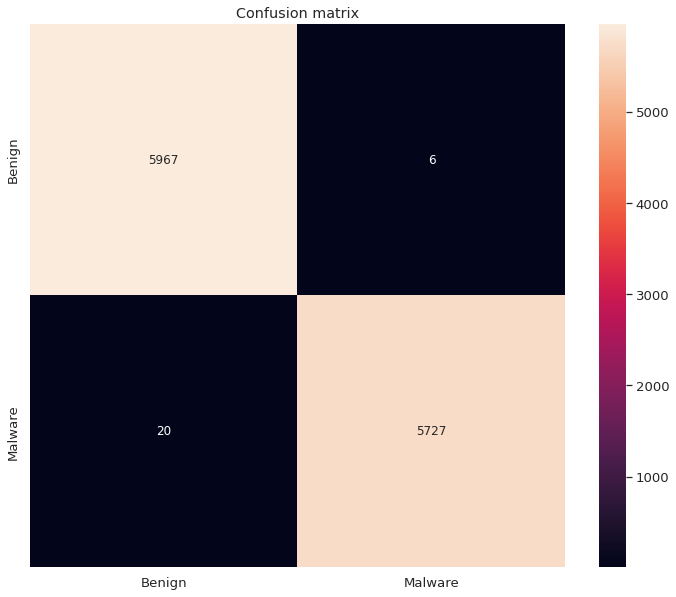

Done


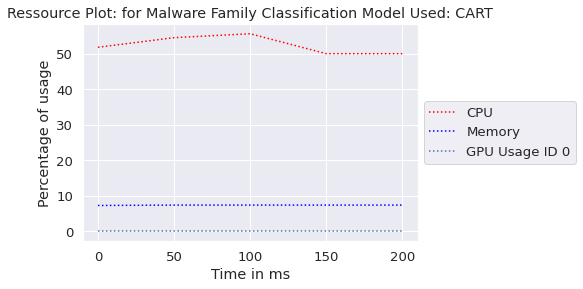

Evaluation of Malware Family Classification for CART Algorithm
Precision:0.5991467576791809

Recall:0.5991467576791809

Accuracy:0.5991467576791809

Balanced Accuracy:0.6002665564686355

Matthews Correlation Coefficient:0.3998784215157539

AUPRC:0.6659556313993173

Time Taken: 246.2317943572998 ms



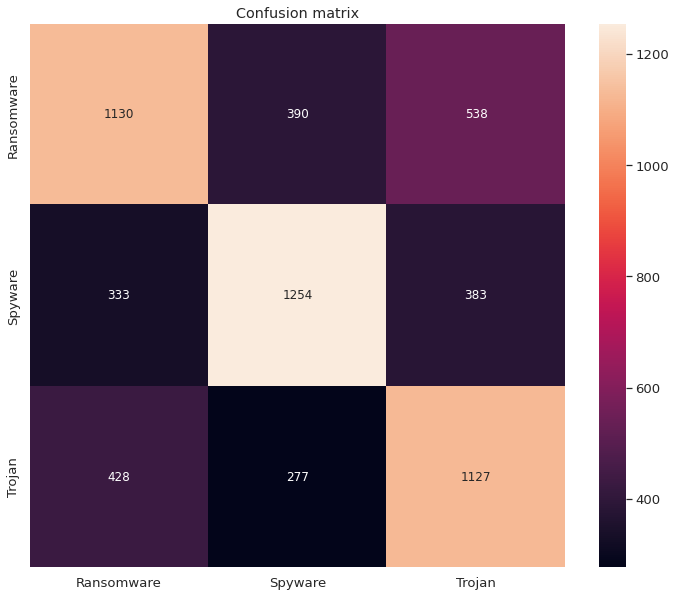

Done


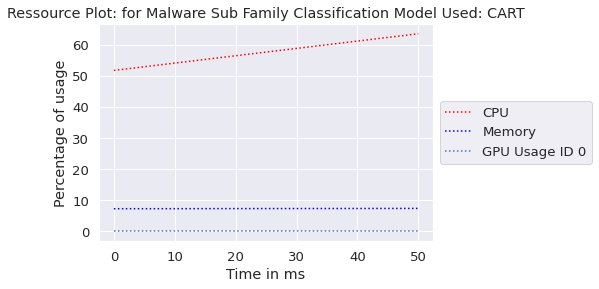

Evaluation of Malware Sub Family Classification for CART Algorithm
Precision:0.3782542113323124

Recall:0.3782542113323124

Accuracy:0.3782542113323124

Balanced Accuracy:0.36863301009278737

Matthews Correlation Coefficient:0.24419704902623715

AUPRC:0.4404287901990811

Time Taken: 89.4773006439209 ms



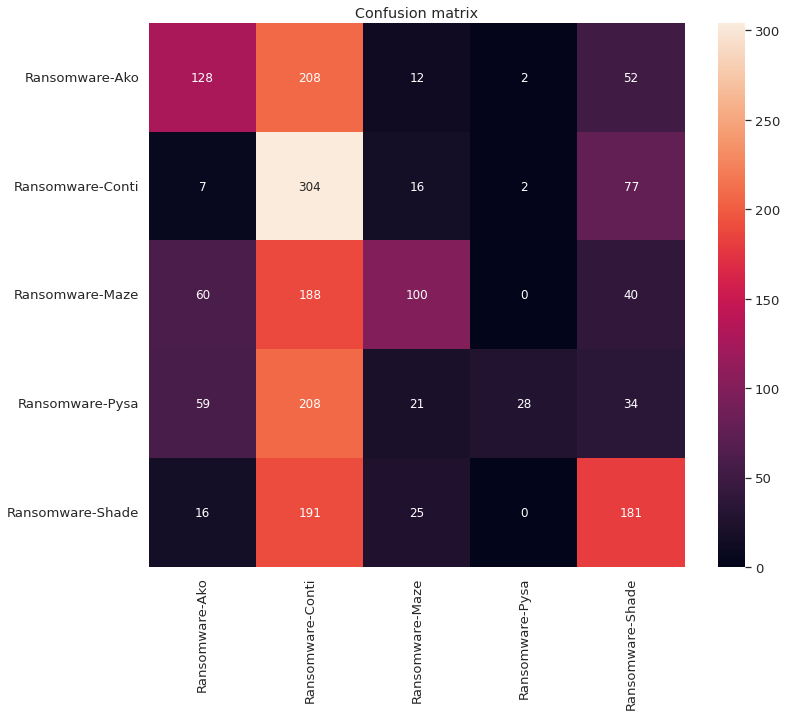

Done


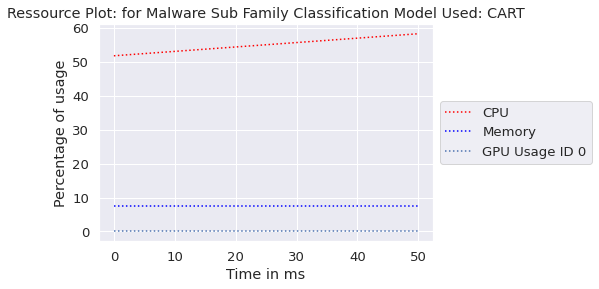

Evaluation of Malware Sub Family Classification for CART Algorithm
Precision:0.48353293413173654

Recall:0.48353293413173654

Accuracy:0.48353293413173654

Balanced Accuracy:0.4802141008042599

Matthews Correlation Coefficient:0.3501467708814829

AUPRC:0.5351796407185629

Time Taken: 87.54682540893555 ms



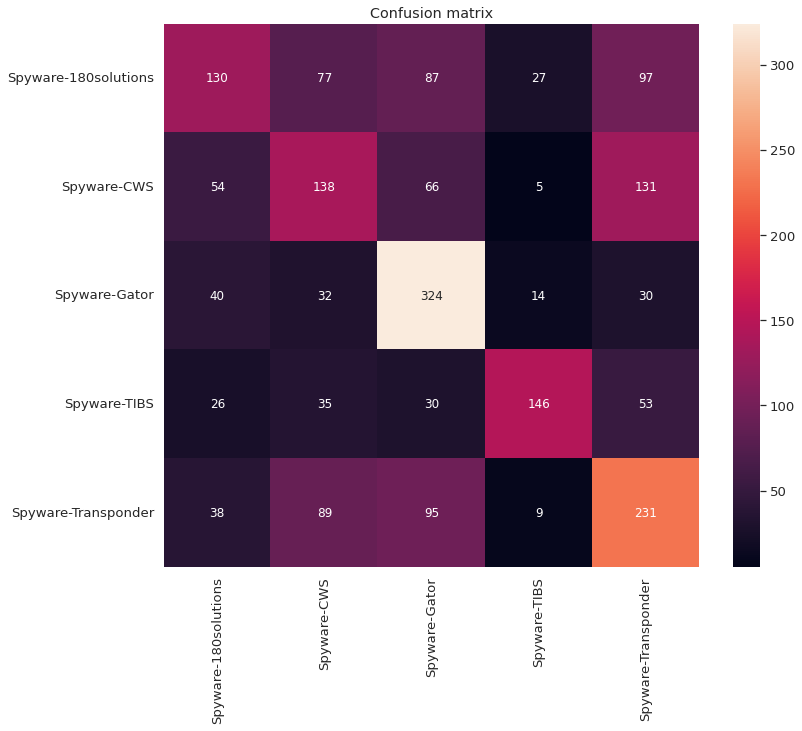

Done


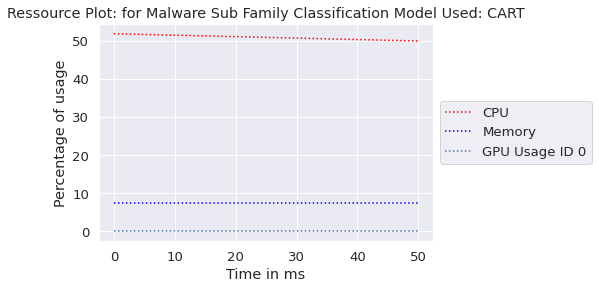

Evaluation of Malware Sub Family Classification for CART Algorithm
Precision:0.547945205479452

Recall:0.547945205479452

Accuracy:0.547945205479452

Balanced Accuracy:0.5485875649144574

Matthews Correlation Coefficient:0.43830816773225384

AUPRC:0.5931506849315068

Time Taken: 79.44679260253906 ms



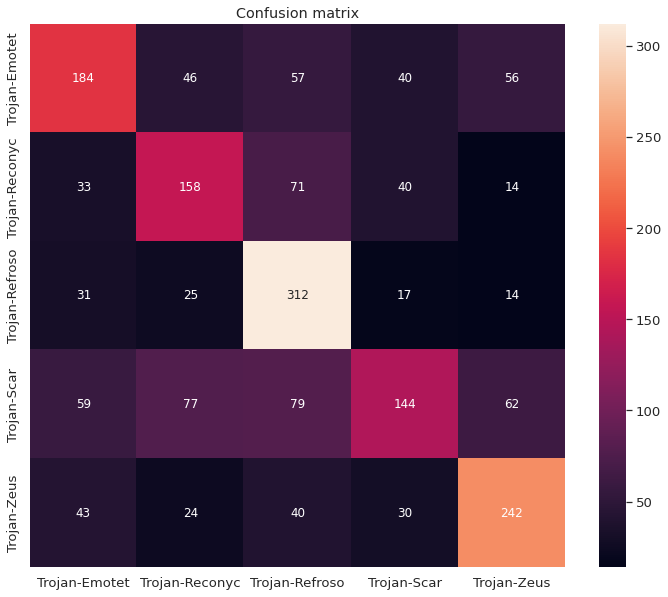

Pipeline : Training for Malware/Benign Classification Model Used: RandomForest <====> Malware Family Classification Model Used: RandomForest <===> Malware Sub Family Classification Model Used: RandomForest
Done


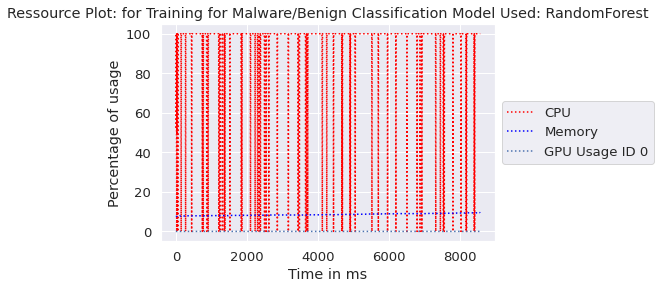

Evaluation of Malware/Benign Classification for RandomForest Algorithm
Precision:0.9998293515358362

Recall:0.9998293515358362

Accuracy:0.9998293515358362

Balanced Accuracy:0.9998325799430772

Matthews Correlation Coefficient:0.9996586366273076

AUPRC:0.9998260567055139

Time Taken: 9631.17504119873 ms



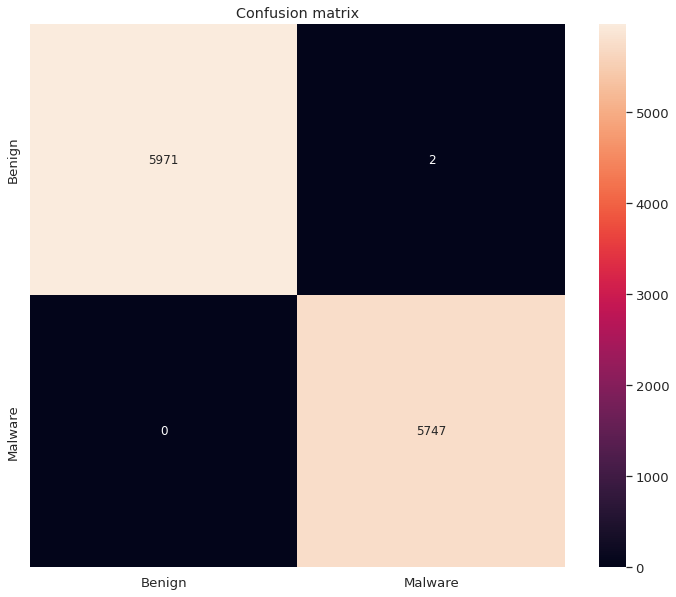

Done


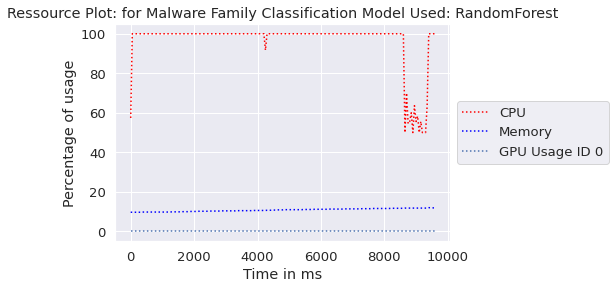

Evaluation of Malware Family Classification for RandomForest Algorithm
Precision:0.7469283276450512

Recall:0.7469283276450512

Accuracy:0.7469283276450512

Balanced Accuracy:0.7475154193122836

Matthews Correlation Coefficient:0.6207199534507407

AUPRC:0.7891069397042094

Time Taken: 9797.760009765625 ms



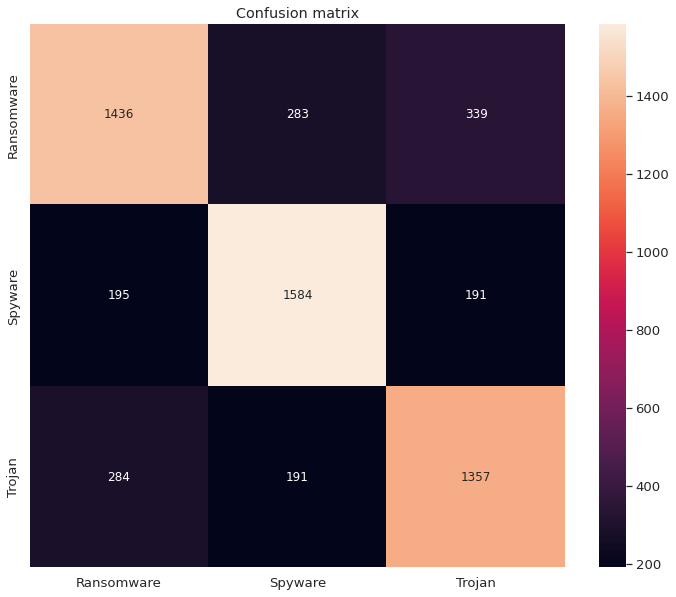

Done


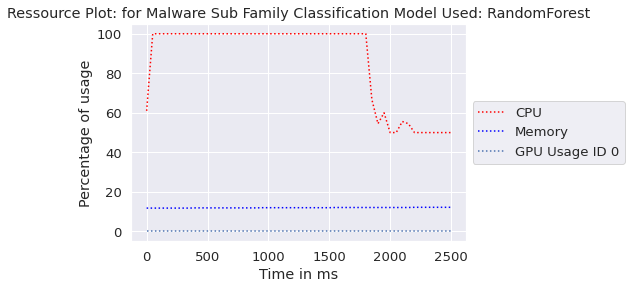

Evaluation of Malware Sub Family Classification for RandomForest Algorithm
Precision:0.5553854007146504

Recall:0.5553854007146504

Accuracy:0.5553854007146504

Balanced Accuracy:0.5531888853201047

Matthews Correlation Coefficient:0.44351055226007746

AUPRC:0.5998468606431853

Time Taken: 2566.694498062134 ms



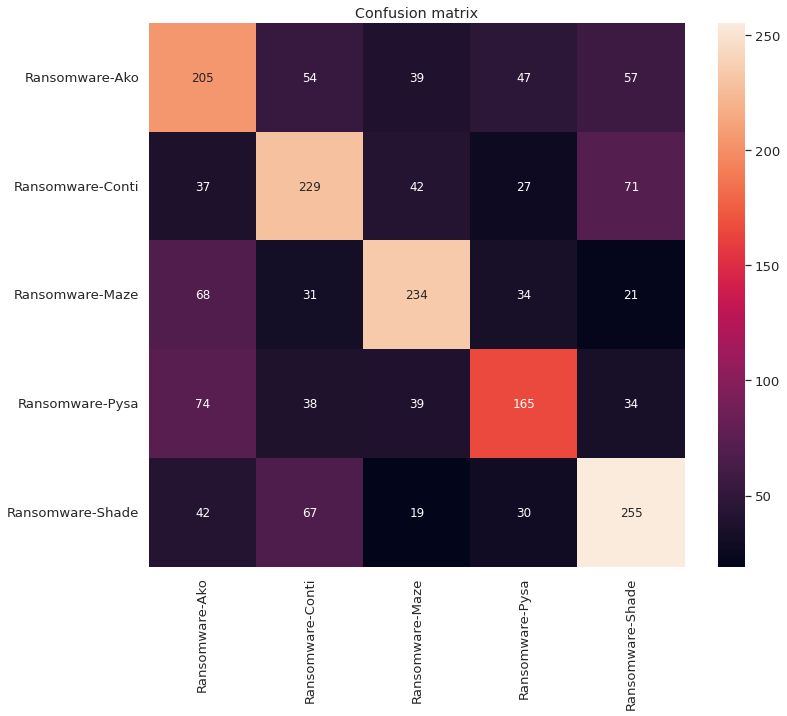

Done


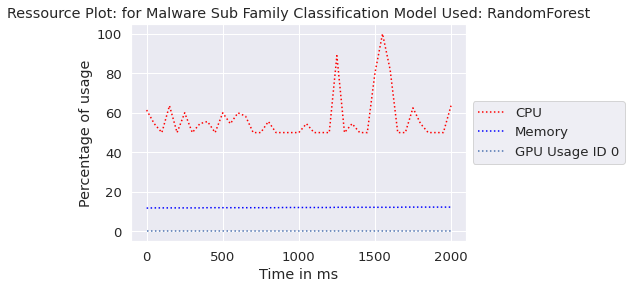

Evaluation of Malware Sub Family Classification for RandomForest Algorithm
Precision:0.6511976047904192

Recall:0.6511976047904192

Accuracy:0.6511976047904192

Balanced Accuracy:0.6582792069204407

Matthews Correlation Coefficient:0.5615566697867961

AUPRC:0.6860778443113773

Time Taken: 2057.3391914367676 ms



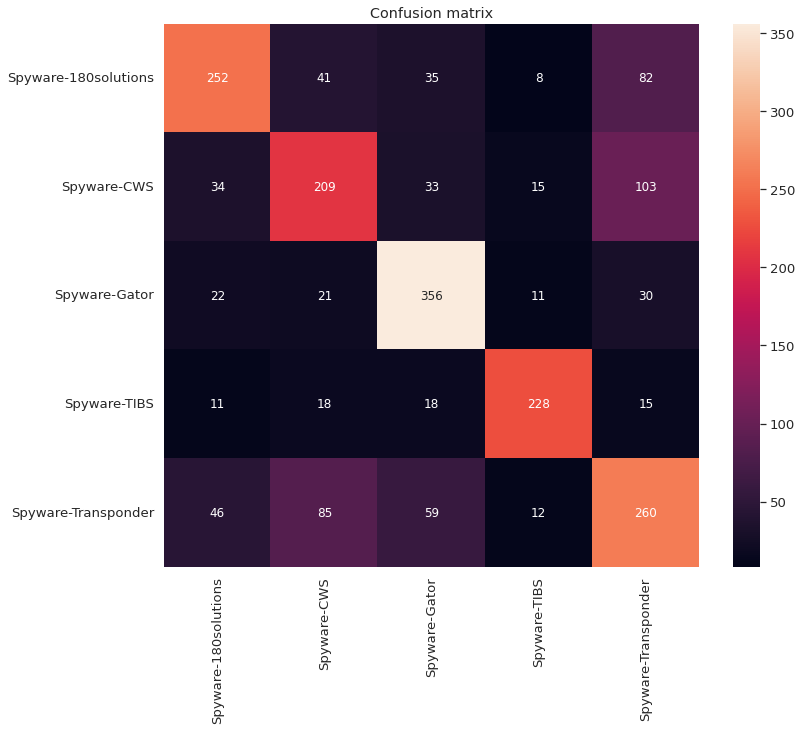

Done


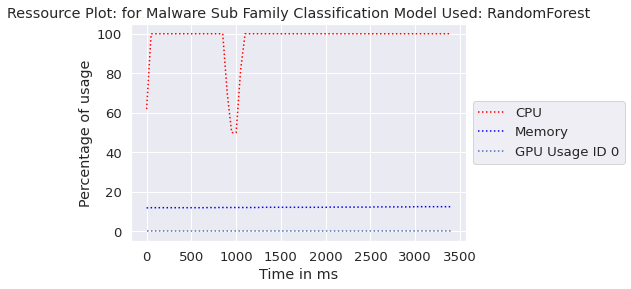

Evaluation of Malware Sub Family Classification for RandomForest Algorithm
Precision:0.7502634351949421

Recall:0.7502634351949421

Accuracy:0.7502634351949421

Balanced Accuracy:0.748941884229347

Matthews Correlation Coefficient:0.6871257788792716

AUPRC:0.775237091675448

Time Taken: 3487.131357192993 ms



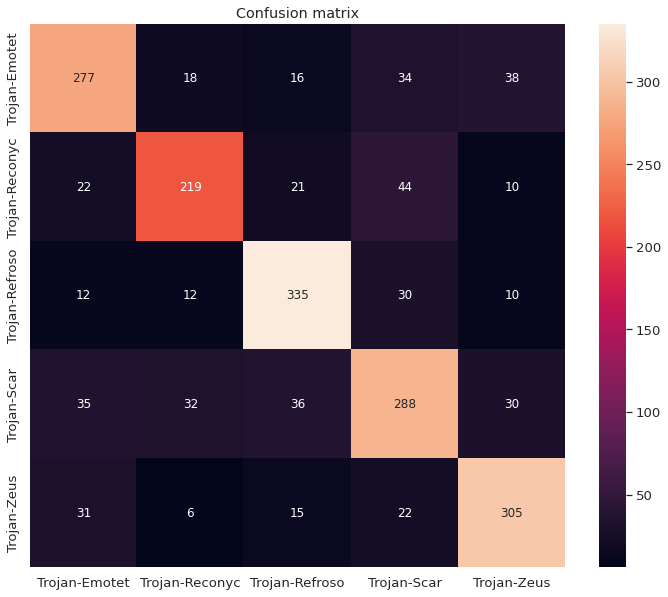

Pipeline : Training for Malware/Benign Classification Model Used: KNN <====> Malware Family Classification Model Used: KNN <===> Malware Sub Family Classification Model Used: KNN
Done


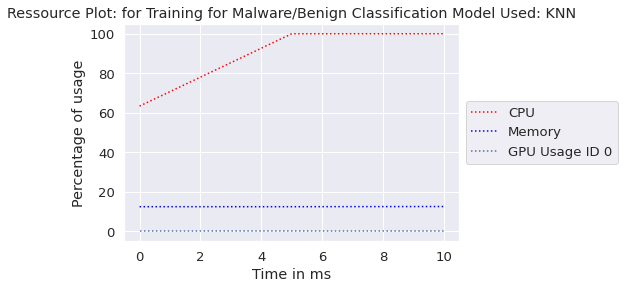

Evaluation of Malware/Benign Classification for KNN Algorithm
Precision:0.9988907849829352

Recall:0.9988907849829352

Accuracy:0.9988907849829352

Balanced Accuracy:0.998875558888614

Matthews Correlation Coefficient:0.9977818567221353

AUPRC:0.9993379854705059

Time Taken: 46.198129653930664 ms



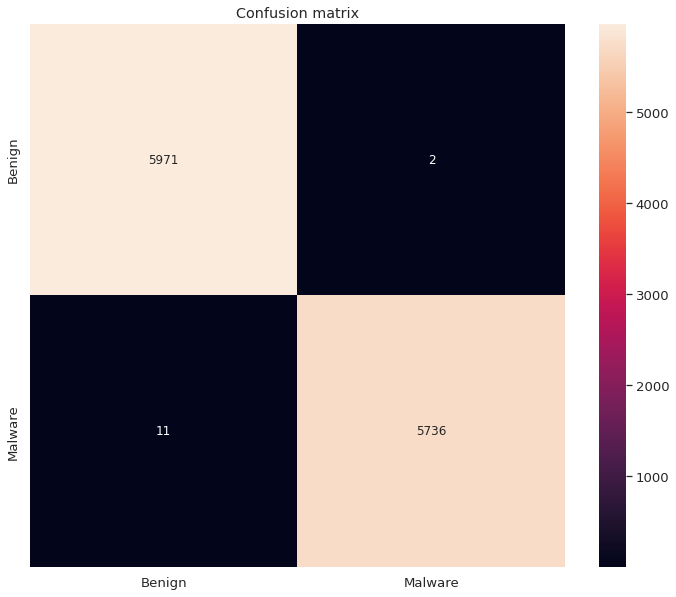

Done


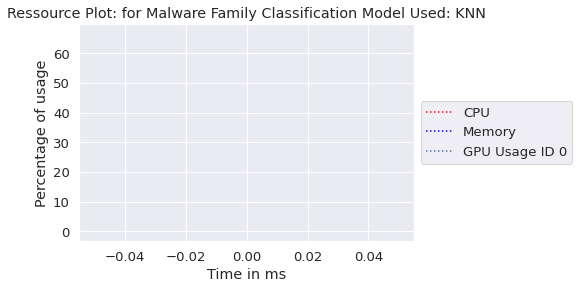

Evaluation of Malware Family Classification for KNN Algorithm
Precision:0.6133105802047781

Recall:0.6133105802047781

Accuracy:0.6133105802047781

Balanced Accuracy:0.6122215087203798

Matthews Correlation Coefficient:0.419078087049848

AUPRC:0.6777588168373152

Time Taken: 19.945144653320312 ms



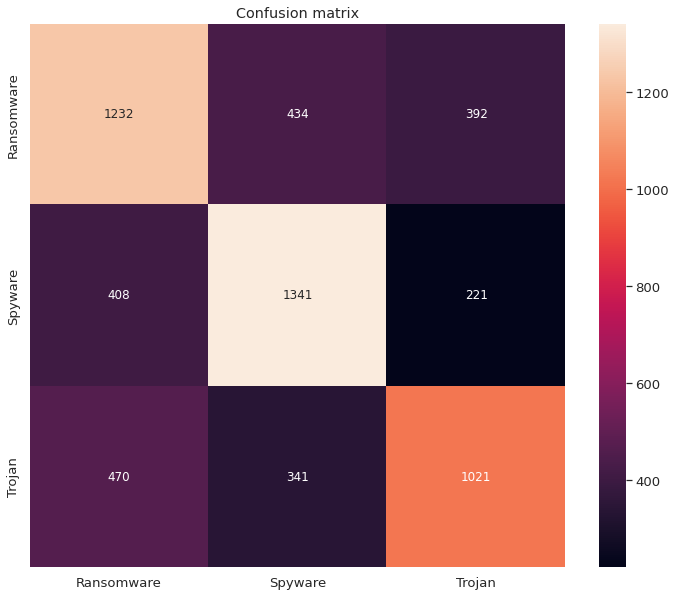

Done


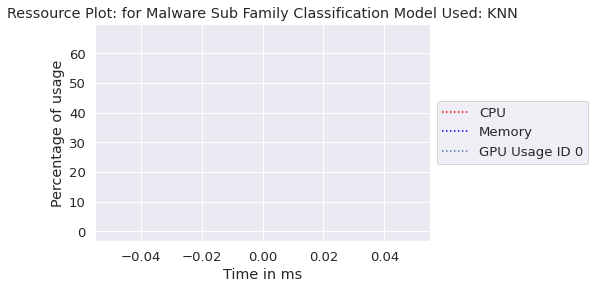

Evaluation of Malware Sub Family Classification for KNN Algorithm
Precision:0.4333843797856049

Recall:0.4333843797856049

Accuracy:0.4333843797856049

Balanced Accuracy:0.4310773892682077

Matthews Correlation Coefficient:0.2911618153510759

AUPRC:0.4900459418070444

Time Taken: 13.150215148925781 ms



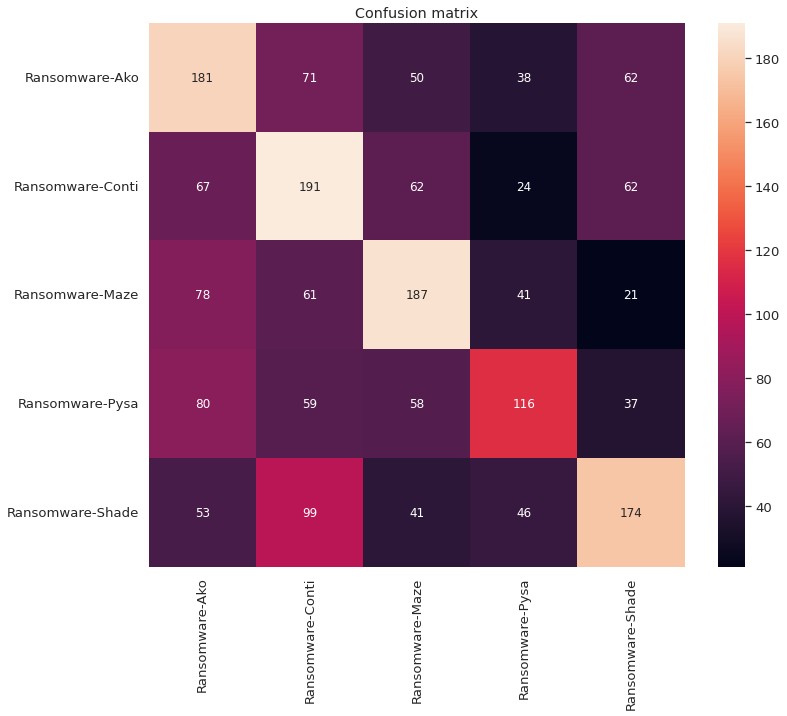

Done


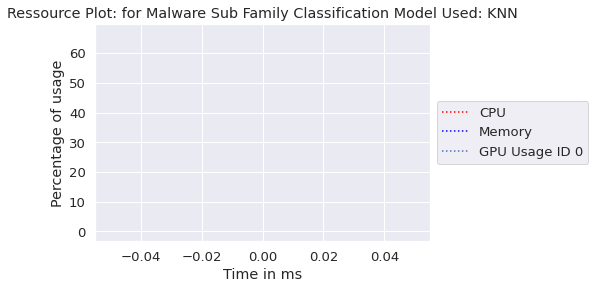

Evaluation of Malware Sub Family Classification for KNN Algorithm
Precision:0.5114770459081837

Recall:0.5114770459081837

Accuracy:0.5114770459081837

Balanced Accuracy:0.5200896579322054

Matthews Correlation Coefficient:0.386369996811459

AUPRC:0.5603293413173653

Time Taken: 12.353897094726562 ms



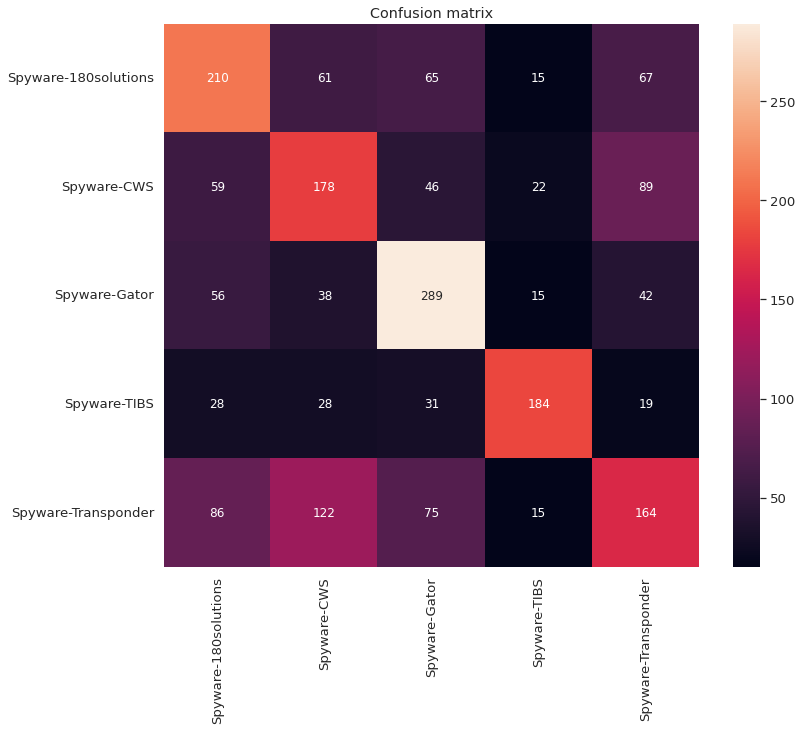

Done


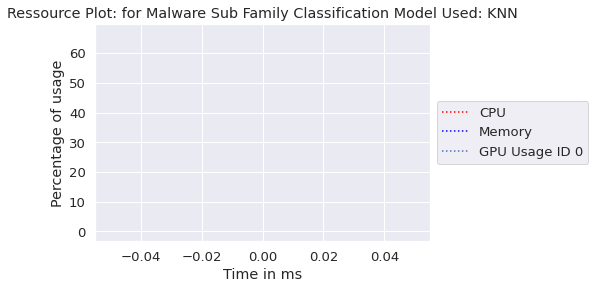

Evaluation of Malware Sub Family Classification for KNN Algorithm
Precision:0.5642781875658588

Recall:0.5642781875658588

Accuracy:0.5642781875658588

Balanced Accuracy:0.5656069258718448

Matthews Correlation Coefficient:0.45685448402270357

AUPRC:0.6078503688092729

Time Taken: 12.526273727416992 ms



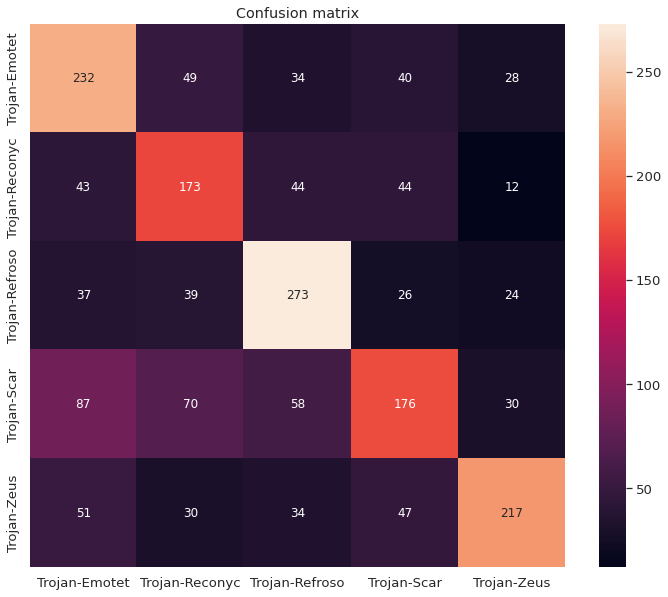

Pipeline : Training for Malware/Benign Classification Model Used: XGBOOST <====> Malware Family Classification Model Used: XGBOOST <===> Malware Sub Family Classification Model Used: XGBOOST
Done


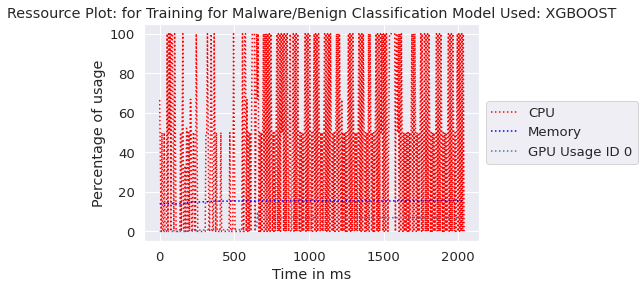

Evaluation of Malware/Benign Classification for XGBOOST Algorithm
Precision:0.9998293515358362

Recall:0.9998293515358362

Accuracy:0.9998293515358362

Balanced Accuracy:0.9998325799430772

Matthews Correlation Coefficient:0.9996586366273076

AUPRC:0.9998260567055139

Time Taken: 2380.1257610321045 ms



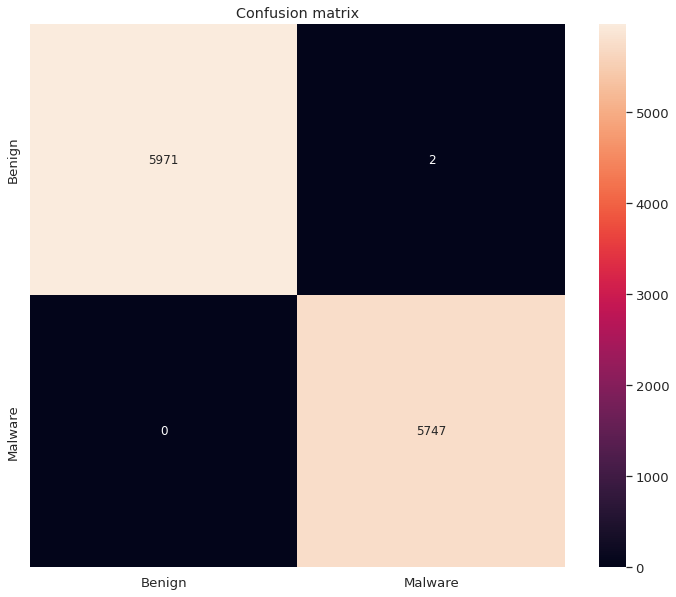

Done


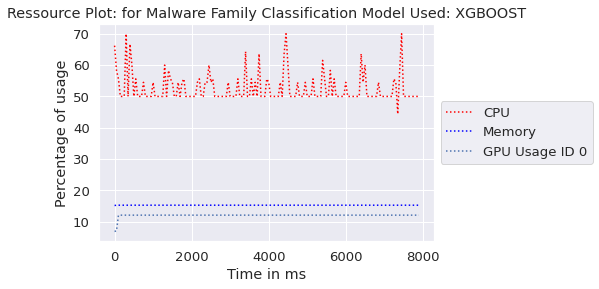

Evaluation of Malware Family Classification for XGBOOST Algorithm
Precision:0.7627986348122867

Recall:0.7627986348122867

Accuracy:0.7627986348122867

Balanced Accuracy:0.7630440376151939

Matthews Correlation Coefficient:0.6445590474715543

AUPRC:0.8023321956769056

Time Taken: 8094.209671020508 ms



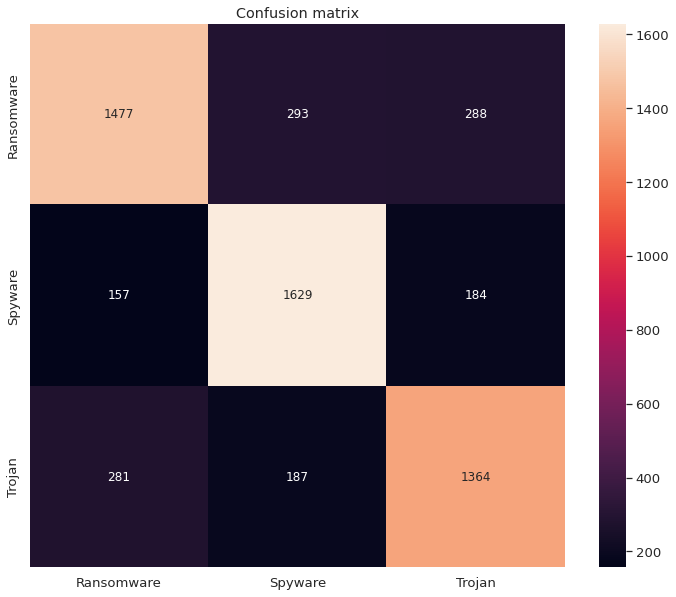

Done


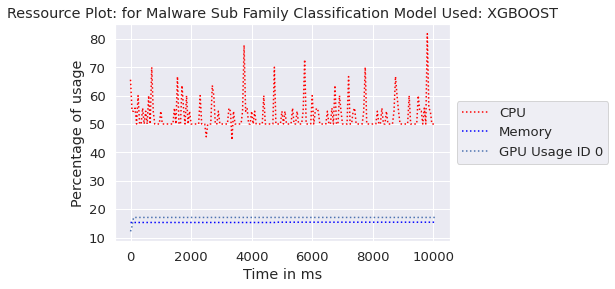

Evaluation of Malware Sub Family Classification for XGBOOST Algorithm
Precision:0.5798876978050026

Recall:0.5798876978050026

Accuracy:0.5798876978050026

Balanced Accuracy:0.57743872899541

Matthews Correlation Coefficient:0.47427957933745296

AUPRC:0.6218989280245023

Time Taken: 10184.142589569092 ms



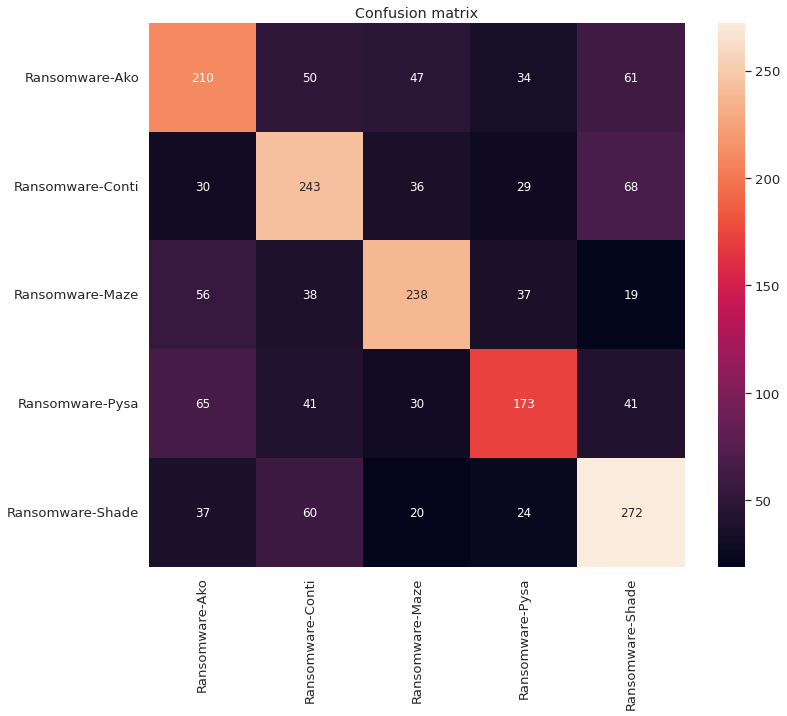

Done


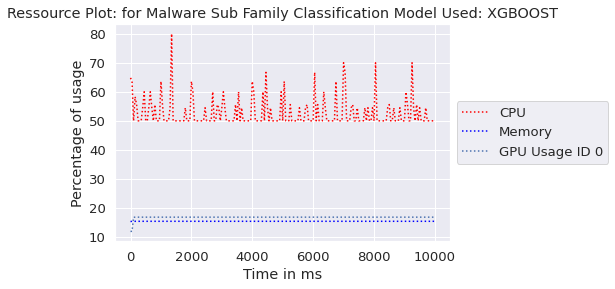

Evaluation of Malware Sub Family Classification for XGBOOST Algorithm
Precision:0.6826347305389222

Recall:0.6826347305389222

Accuracy:0.6826347305389222

Balanced Accuracy:0.6891628481240815

Matthews Correlation Coefficient:0.6011200579591922

AUPRC:0.71437125748503

Time Taken: 10163.537502288818 ms



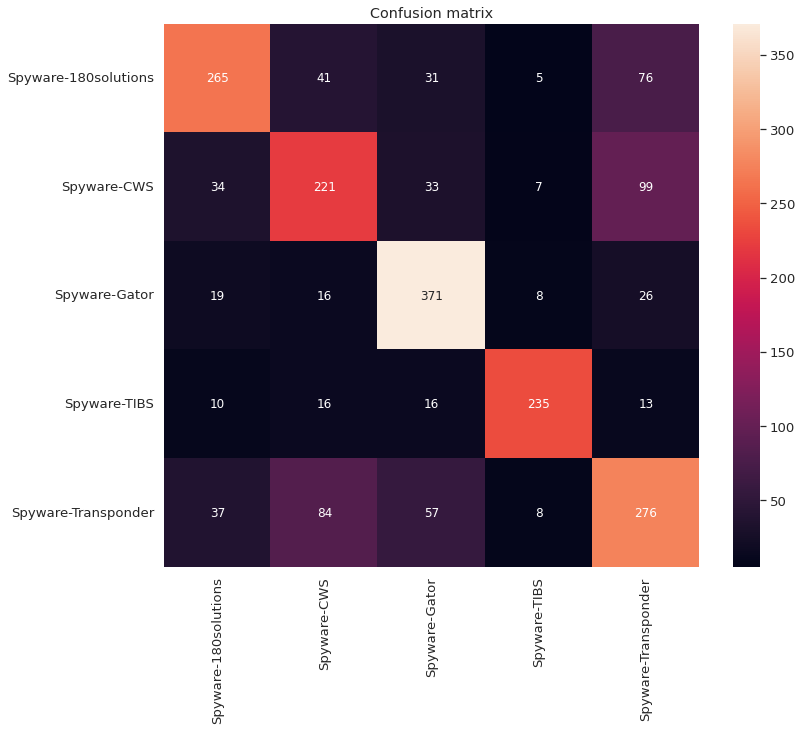

Done


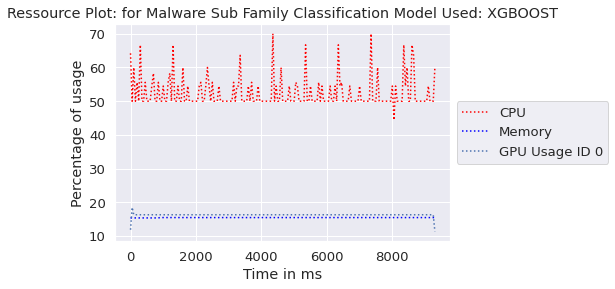

Evaluation of Malware Sub Family Classification for XGBOOST Algorithm
Precision:0.7623814541622761

Recall:0.7623814541622761

Accuracy:0.7623814541622761

Balanced Accuracy:0.7623637896776098

Matthews Correlation Coefficient:0.7025663778918055

AUPRC:0.7861433087460485

Time Taken: 9434.603691101074 ms



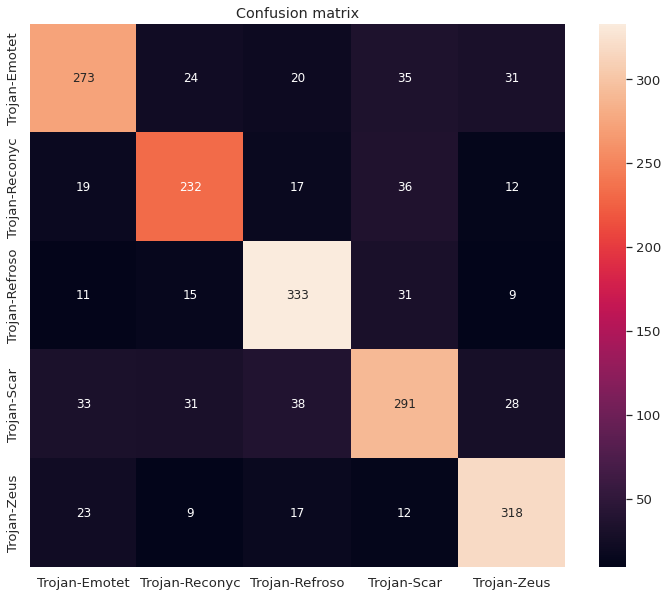

Pipeline : Training for Malware/Benign Classification Model Used: MLP <====> Malware Family Classification Model Used: MLP <===> Malware Sub Family Classification Model Used: MLP
Done


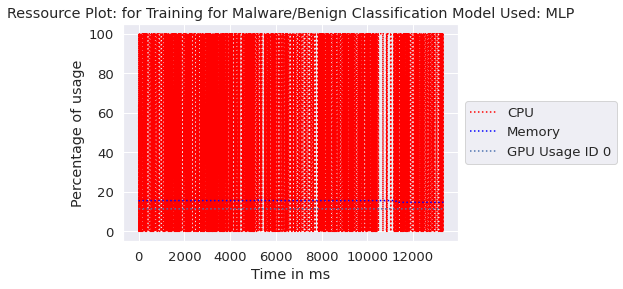

Evaluation of Malware/Benign Classification for MLP Algorithm
Precision:0.9970136518771331

Recall:0.9970136518771331

Accuracy:0.9970136518771331

Balanced Accuracy:0.9970339382624629

Matthews Correlation Coefficient:0.9940277853287354

AUPRC:0.997428928888654

Time Taken: 14605.85331916809 ms



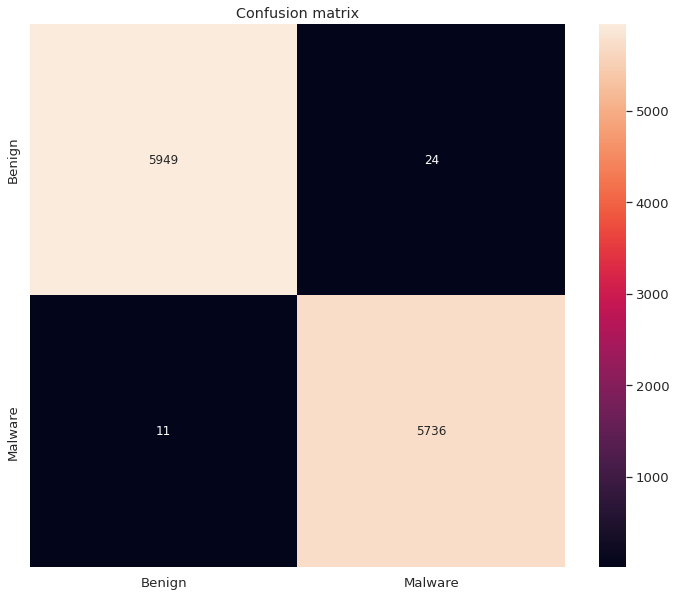

Done


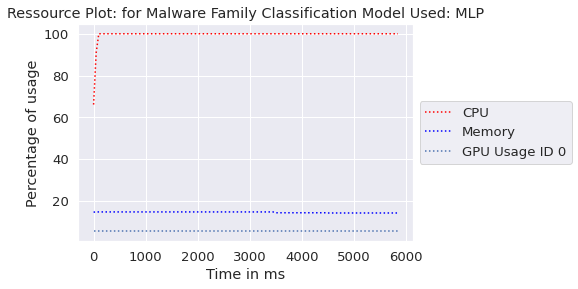

Evaluation of Malware Family Classification for MLP Algorithm
Precision:0.38122866894197954

Recall:0.38122866894197954

Accuracy:0.38122866894197954

Balanced Accuracy:0.364129661203992

Matthews Correlation Coefficient:0.11183446706421885

AUPRC:0.4843572241183163

Time Taken: 5973.821401596069 ms



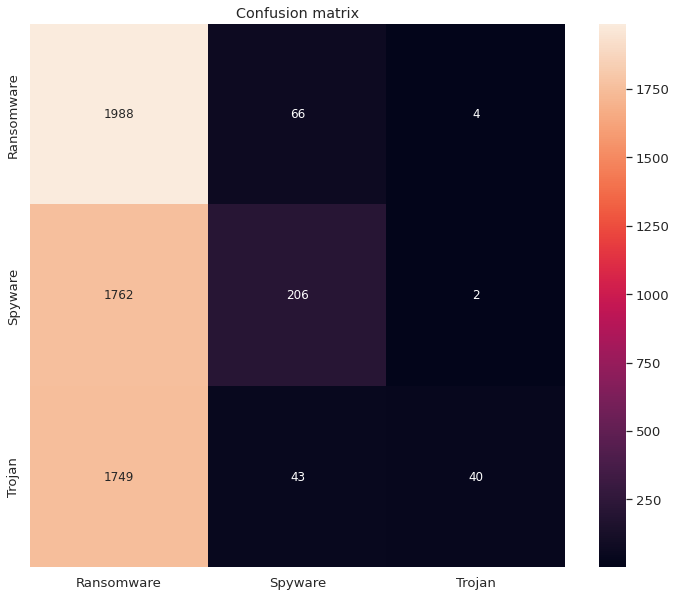

Done


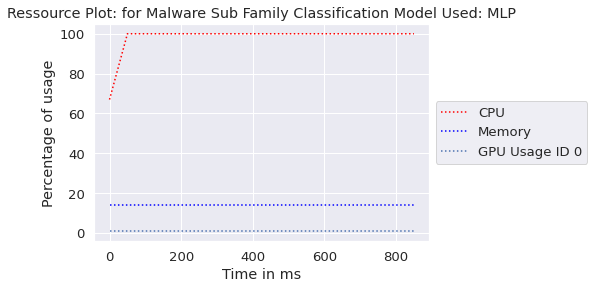

Evaluation of Malware Sub Family Classification for MLP Algorithm
Precision:0.22256253190403266

Recall:0.22256253190403266

Accuracy:0.22256253190403266

Balanced Accuracy:0.21727439903589468

Matthews Correlation Coefficient:0.032042722217267575

AUPRC:0.30030627871362947

Time Taken: 896.6937065124512 ms



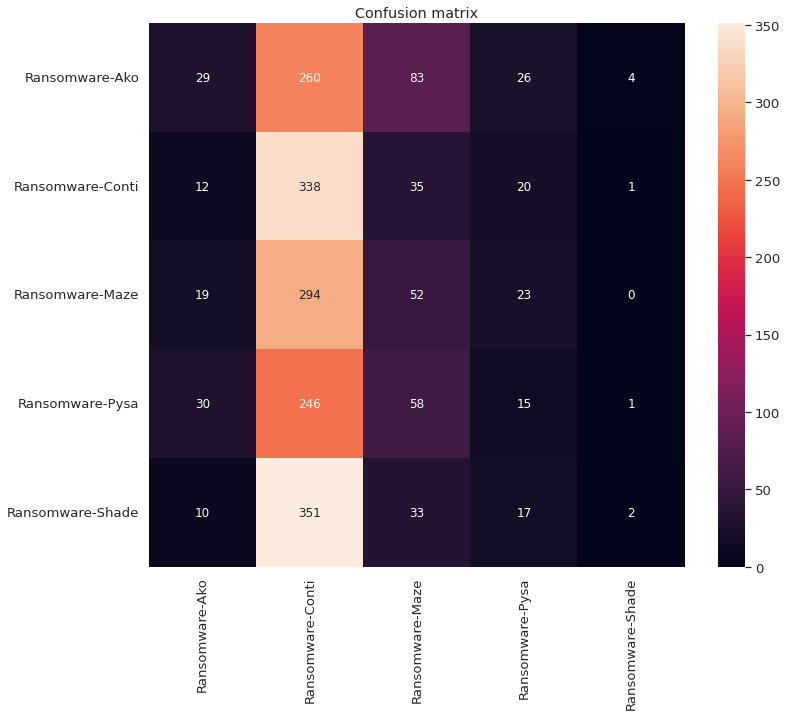

Done


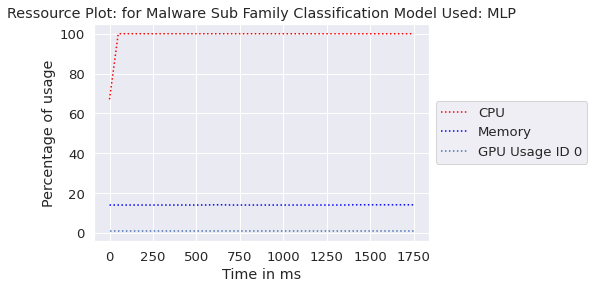

Evaluation of Malware Sub Family Classification for MLP Algorithm
Precision:0.21157684630738524

Recall:0.21157684630738524

Accuracy:0.21157684630738524

Balanced Accuracy:0.25530146356295397

Matthews Correlation Coefficient:0.10234489466279247

AUPRC:0.2904191616766467

Time Taken: 1827.7361392974854 ms



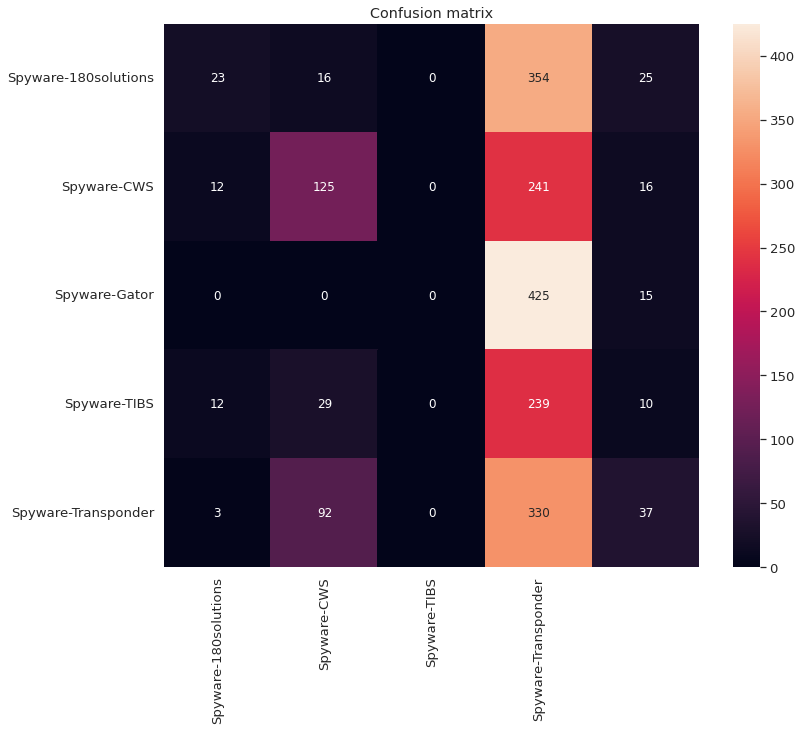

Done


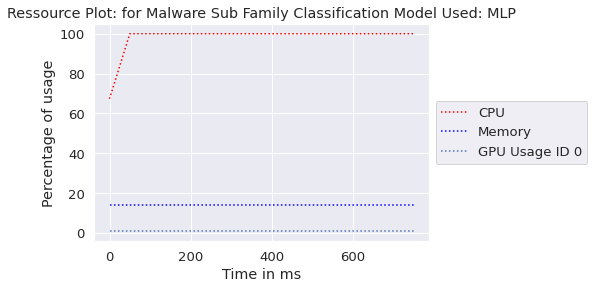

Evaluation of Malware Sub Family Classification for MLP Algorithm
Precision:0.23445732349841938

Recall:0.23445732349841938

Accuracy:0.23445732349841938

Balanced Accuracy:0.21417565781874276

Matthews Correlation Coefficient:0.04148275729452648

AUPRC:0.3110115911485774

Time Taken: 822.4225044250488 ms



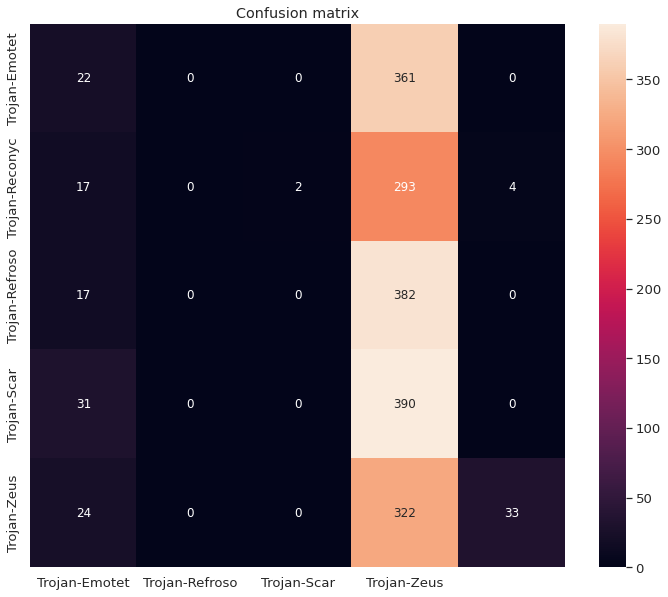

Pipeline : Training for Malware/Benign Classification Model Used: SVM <====> Malware Family Classification Model Used: SVM <===> Malware Sub Family Classification Model Used: SVM
Done


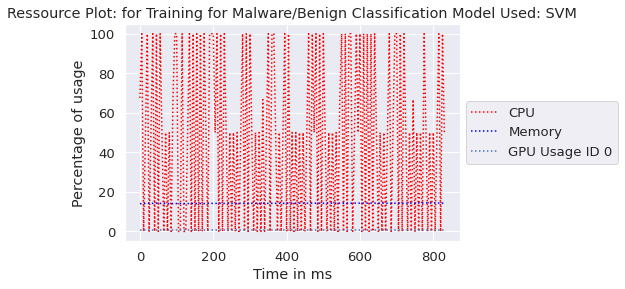

Evaluation of Malware/Benign Classification for SVM Algorithm
Precision:0.9996587030716724

Recall:0.9996587030716724

Accuracy:0.9996587030716724

Balanced Accuracy:0.999658576114993

Matthews Correlation Coefficient:0.999317152229986

AUPRC:0.9997373165759136

Time Taken: 945.023775100708 ms



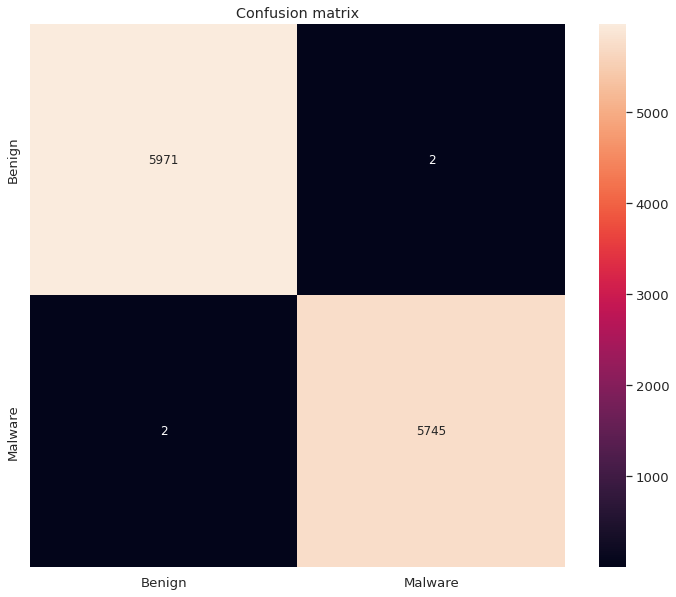

Done


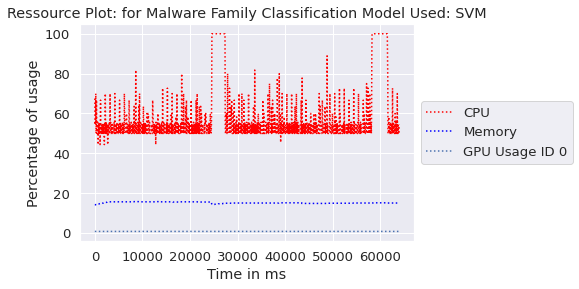

Evaluation of Malware Family Classification for SVM Algorithm
Precision:0.46979522184300343

Recall:0.46979522184300343

Accuracy:0.46979522184300343

Balanced Accuracy:0.4822989674899867

Matthews Correlation Coefficient:0.25733218712549427

AUPRC:0.5581626848691695

Time Taken: 65057.236433029175 ms



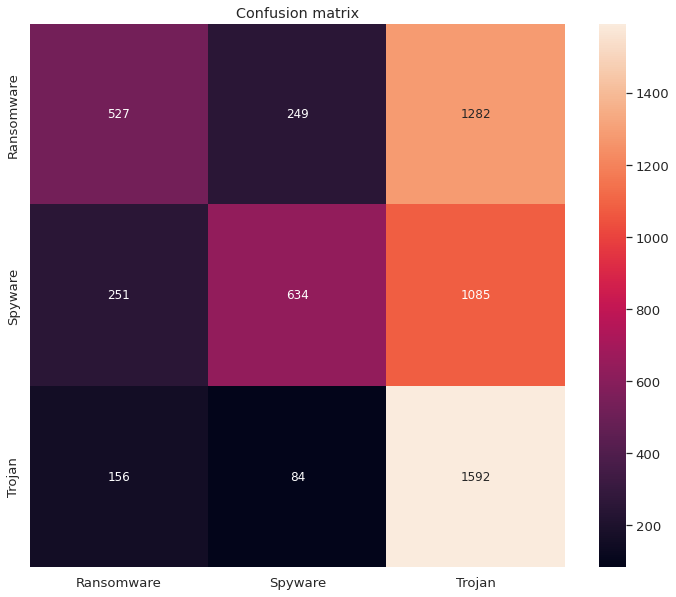

Done


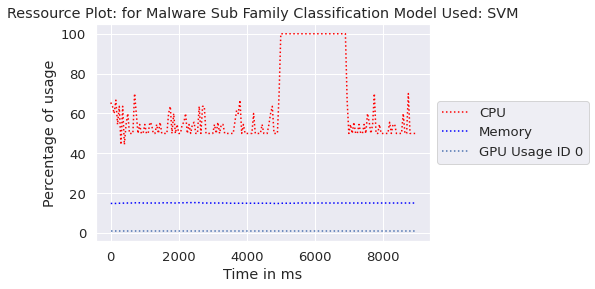

Evaluation of Malware Sub Family Classification for SVM Algorithm
Precision:0.36294027565084225

Recall:0.36294027565084225

Accuracy:0.36294027565084225

Balanced Accuracy:0.35546502319937395

Matthews Correlation Coefficient:0.20702378111508069

AUPRC:0.426646248085758

Time Taken: 9156.62169456482 ms



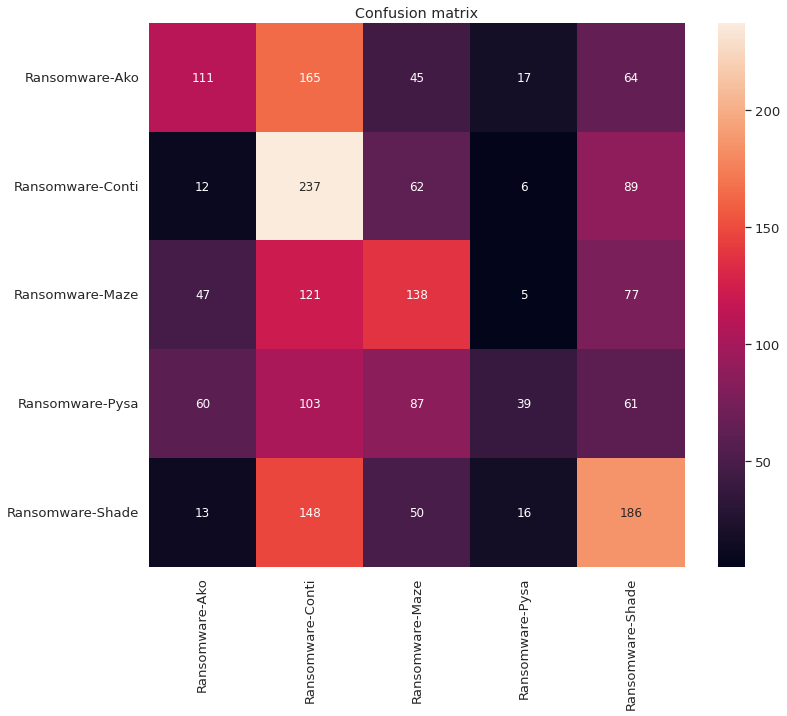

Done


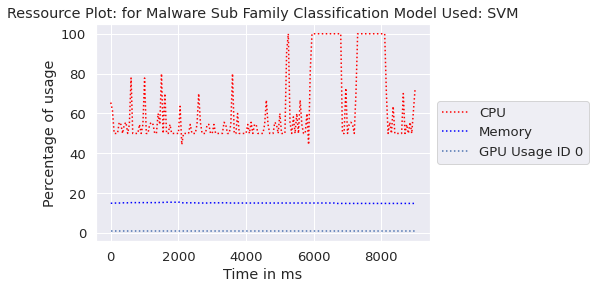

Evaluation of Malware Sub Family Classification for SVM Algorithm
Precision:0.4545908183632735

Recall:0.4545908183632735

Accuracy:0.4545908183632735

Balanced Accuracy:0.4514737644119847

Matthews Correlation Coefficient:0.3206766428878702

AUPRC:0.5091317365269461

Time Taken: 9183.994770050049 ms



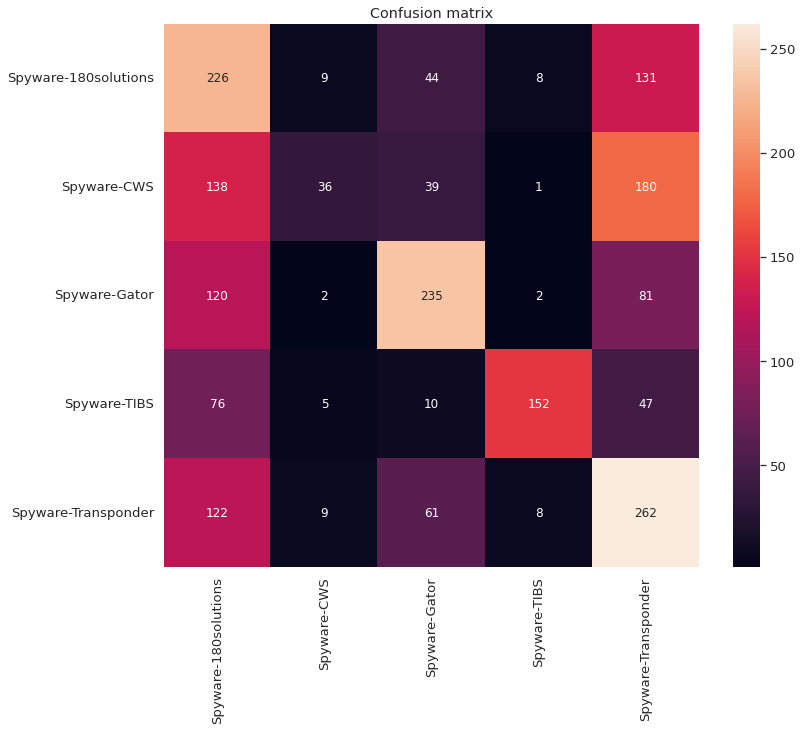

Done


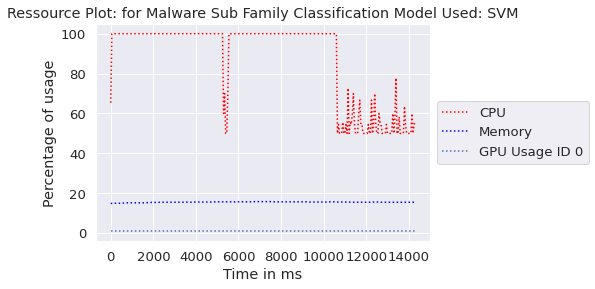

Evaluation of Malware Sub Family Classification for SVM Algorithm
Precision:0.45732349841938885

Recall:0.45732349841938885

Accuracy:0.45732349841938885

Balanced Accuracy:0.4545664669267403

Matthews Correlation Coefficient:0.32707675858083934

AUPRC:0.5115911485774499

Time Taken: 14596.380472183228 ms



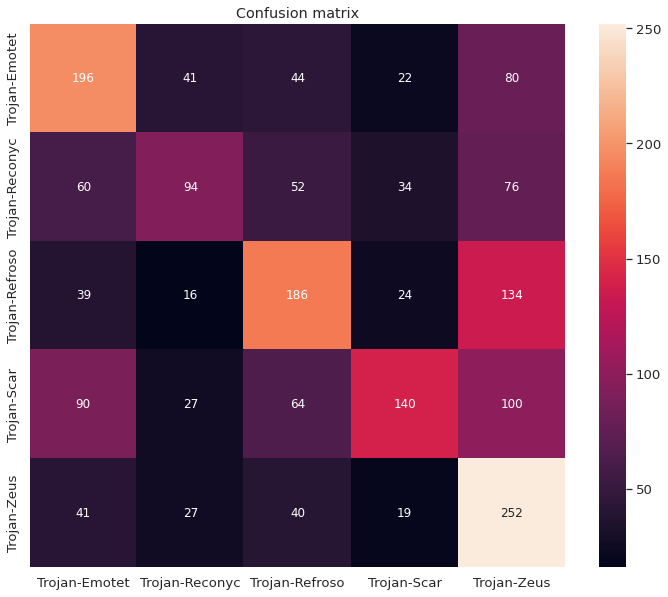

In [ ]:
md = Malware_Detection(optimization=False, lines=-1, verbose=False)
models = ['CART', 'RandomForest', 'KNN', 'XGBOOST', 'MLP' , 'SVM']

for x in models:
    md.init_model(x,x,x)



In [ ]:
display(md.output_evaluation)

Model  Precision    Recall  Balanced Accuracy  \
0           CART   0.997782  0.997782           0.997758   
1           CART   0.599147  0.599147           0.600267   
2           CART   0.378254  0.378254           0.368633   
3           CART   0.483533  0.483533           0.480214   
4           CART   0.547945  0.547945           0.548588   
5   RandomForest   0.999829  0.999829           0.999833   
6   RandomForest   0.746928  0.746928           0.747515   
7   RandomForest   0.555385  0.555385           0.553189   
8   RandomForest   0.651198  0.651198           0.658279   
9   RandomForest   0.750263  0.750263           0.748942   
10           KNN   0.998891  0.998891           0.998876   
11           KNN   0.613311  0.613311           0.612222   
12           KNN   0.433384  0.433384           0.431077   
13           KNN   0.511477  0.511477           0.520090   
14           KNN   0.564278  0.564278           0.565607   
15       XGBOOST   0.999829  0.999829           0.999833   
16       XGBOOST   0.762799  0.762799           0.763044   
17       XGBOOST   0.579888  0.579888           0.577439   
18       XGBOOST   0.682635  0.682635           0.689163   
19       XGBOOST   0.762381  0.762381           0.762364   
20           MLP   0.997014  0.997014           0.997034   
21           MLP   0.381229  0.381229           0.364130   
22           MLP   0.222563  0.222563           0.217274   
23           MLP   0.211577  0.211577           0.255301   
24           MLP   0.234457  0.234457           0.214176   
25           SVM   0.999659  0.999659           0.999659   
26           SVM   0.469795  0.469795           0.482299   
27           SVM   0.362940  0.362940           0.355465   
28           SVM   0.454591  0.454591           0.451474   
29           SVM   0.457323  0.457323           0.454566   

    Matthews Correlation Coefficient     AUPRC    Time Taken  \
0                           0.995564  0.998590    558.501244   
1                           0.399878  0.665956    246.231794   
2                           0.244197  0.440429     89.477301   
3                           0.350147  0.535180     87.546825   
4                           0.438308  0.593151     79.446793   
5                           0.999659  0.999826   9631.175041   
6                           0.620720  0.789107   9797.760010   
7                           0.443511  0.599847   2566.694498   
8                           0.561557  0.686078   2057.339191   
9                           0.687126  0.775237   3487.131357   
10                          0.997782  0.999338     46.198130   
11                          0.419078  0.677759     19.945145   
12                          0.291162  0.490046     13.150215   
13                          0.386370  0.560329     12.353897   
14                          0.456854  0.607850     12.526274   
15                          0.999659  0.999826   2380.125761   
16                          0.644559  0.802332   8094.209671   
17                          0.474280  0.621899  10184.142590   
18                          0.601120  0.714371  10163.537502   
19                          0.702566  0.786143   9434.603691   
20                          0.994028  0.997429  14605.853319   
21                          0.111834  0.484357   5973.821402   
22                          0.032043  0.300306    896.693707   
23                          0.102345  0.290419   1827.736139   
24                          0.041483  0.311012    822.422504   
25                          0.999317  0.999737    945.023775   
26                          0.257332  0.558163  65057.236433   
27                          0.207024  0.426646   9156.621695   
28                          0.320677  0.509132   9183.994770   
29                          0.327077  0.511591  14596.380472   

                                      Evaluation  
0                  Malware/Benign Classification  
1                  Malware Family Classification  
2   Malware 

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 12, 12

#md.output_evaluation.plot.barh(x='Model', y='Balanced Accuracy', rot=0)
# for i in range(0,6):
#     df = md.output_evaluation[md.output_evaluation.index%6 == i]
#     df.plot.barh(x='Model', y='Balanced Accuracy', rot=0)
df = md.output_evaluation[md.output_evaluation.index%5 == 4]
df


Model  Precision    Recall  Balanced Accuracy  \
4           CART   0.547945  0.547945           0.548588   
9   RandomForest   0.750263  0.750263           0.748942   
14           KNN   0.564278  0.564278           0.565607   
19       XGBOOST   0.762381  0.762381           0.762364   
24           MLP   0.234457  0.234457           0.214176   
29           SVM   0.457323  0.457323           0.454566   

    Matthews Correlation Coefficient     AUPRC    Time Taken  \
4                           0.438308  0.593151     79.446793   
9                           0.687126  0.775237   3487.131357   
14                          0.456854  0.607850     12.526274   
19                          0.702566  0.786143   9434.603691   
24                          0.041483  0.311012    822.422504   
29                          0.327077  0.511591  14596.380472   

                                  Evaluation  
4   Malware Sub Family Classification Trojan  
9   Malware Sub Family Classification Trojan  
14  Malware Sub Family Classification Trojan  
19  Malware Sub Family Classification Trojan  
24  Malware Sub Family Classification Trojan  
29  Malware Sub Family Classification Trojan

Preprocessing the Dataset ADFA-LD in progress ...
Processing Done !
Dataset Used : 3-gramme


Pipeline : Training for Attack/Normal Classification Model Used: CART <====> Attacks Family Classification Model Used: CART
Done


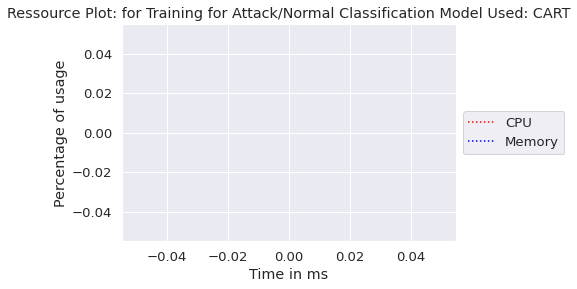

Evaluation of Attack/Normal Classification for CART Algorithm
Precision:0.7928286852589641

Recall:0.7928286852589641

Accuracy:0.7928286852589641

Balanced Accuracy:0.7345479082321187

Matthews Correlation Coefficient:0.5654387604069316

AUPRC:0.8685075084278272

Time Taken: 32.20224380493164 ms



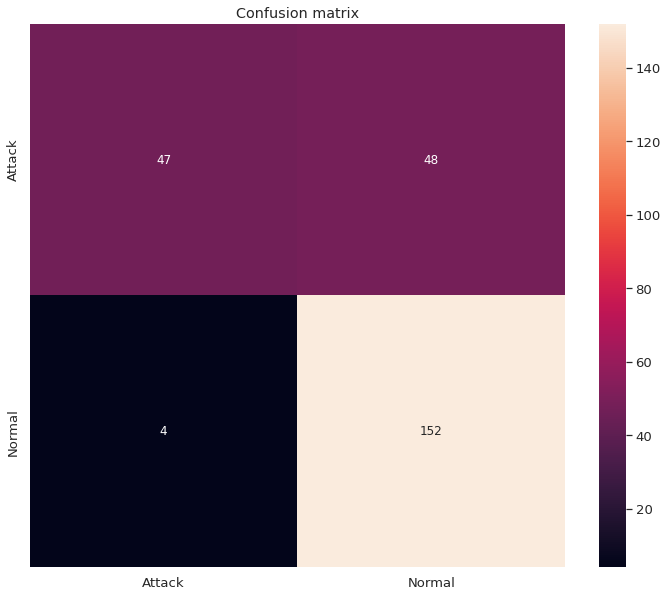

Done


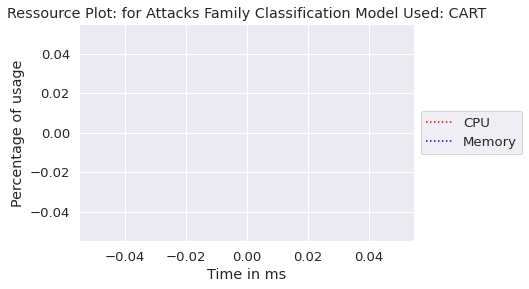

Evaluation of Attacks Family Classification Classification for CART Algorithm
Precision:0.18823529411764706

Recall:0.18823529411764706

Accuracy:0.18823529411764706

Balanced Accuracy:0.20555555555555557

Matthews Correlation Coefficient:0.01023274234124674

AUPRC:0.26941176470588235

Time Taken: 20.46990394592285 ms



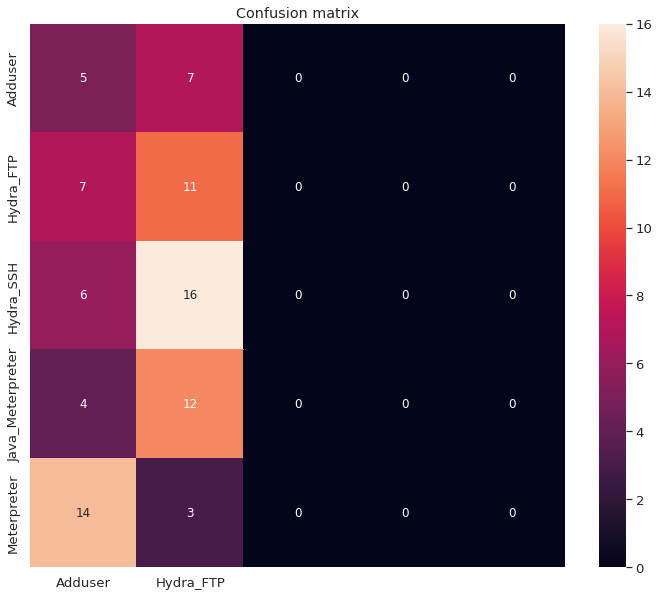

Dataset Used : 5-gramme


Pipeline : Training for Attack/Normal Classification Model Used: CART <====> Attacks Family Classification Model Used: CART
Done


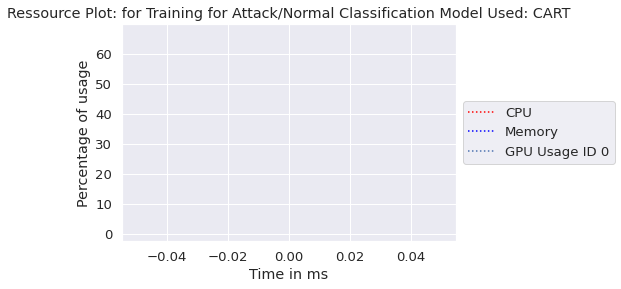

Evaluation of Attack/Normal Classification for CART Algorithm
Precision:0.8167330677290837

Recall:0.8167330677290837

Accuracy:0.8167330677290837

Balanced Accuracy:0.7743589743589743

Matthews Correlation Coefficient:0.6075193536096493

AUPRC:0.8748644792212457

Time Taken: 44.49057579040527 ms



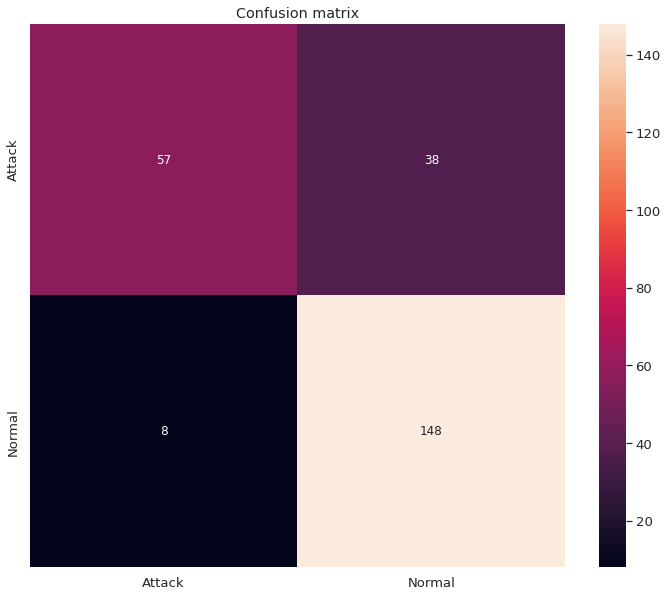

Done


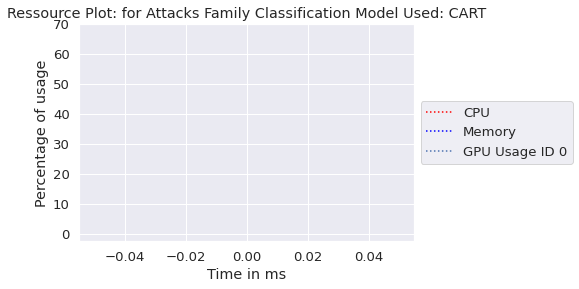

Evaluation of Attacks Family Classification Classification for CART Algorithm
Precision:0.21176470588235294

Recall:0.21176470588235294

Accuracy:0.21176470588235294

Balanced Accuracy:0.2333333333333333

Matthews Correlation Coefficient:0.04465705158341473

AUPRC:0.2905882352941176

Time Taken: 19.92034912109375 ms



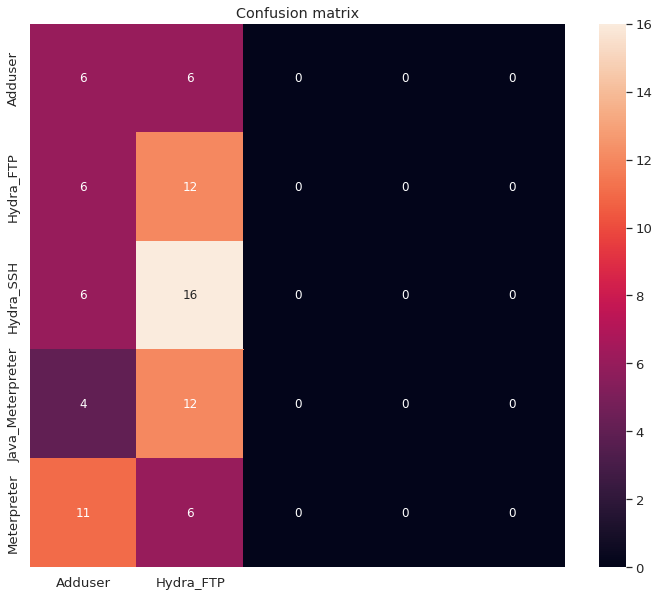

Dataset Used : 6-gramme


Pipeline : Training for Attack/Normal Classification Model Used: CART <====> Attacks Family Classification Model Used: CART
Done


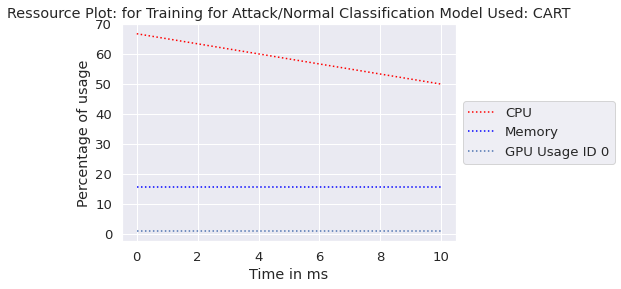

Evaluation of Attack/Normal Classification for CART Algorithm
Precision:0.7529880478087649

Recall:0.7529880478087649

Accuracy:0.7529880478087649

Balanced Accuracy:0.6757422402159244

Matthews Correlation Coefficient:0.4921181218391846

AUPRC:0.8559231734032531

Time Taken: 29.11996841430664 ms



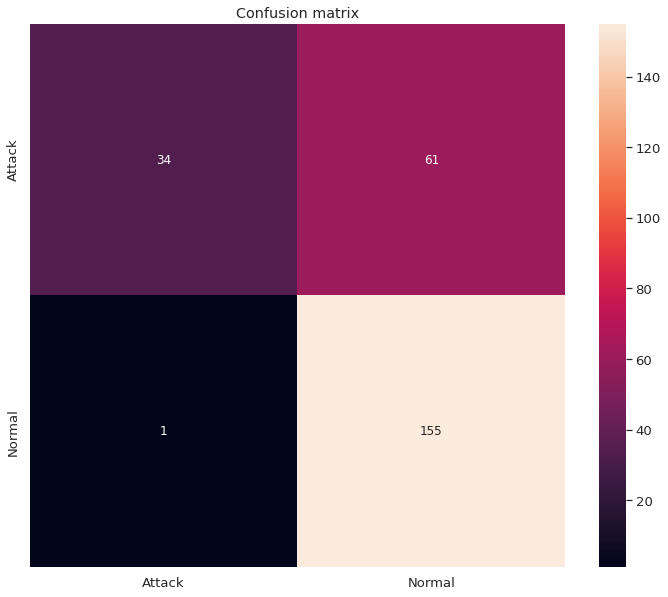

Done


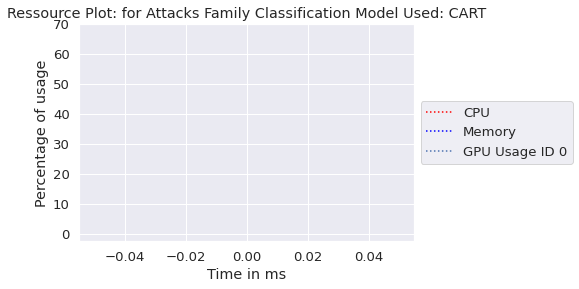

Evaluation of Attacks Family Classification Classification for CART Algorithm
Precision:0.21176470588235294

Recall:0.21176470588235294

Accuracy:0.21176470588235294

Balanced Accuracy:0.2

Matthews Correlation Coefficient:0.0

AUPRC:0.2905882352941176

Time Taken: 45.02367973327637 ms



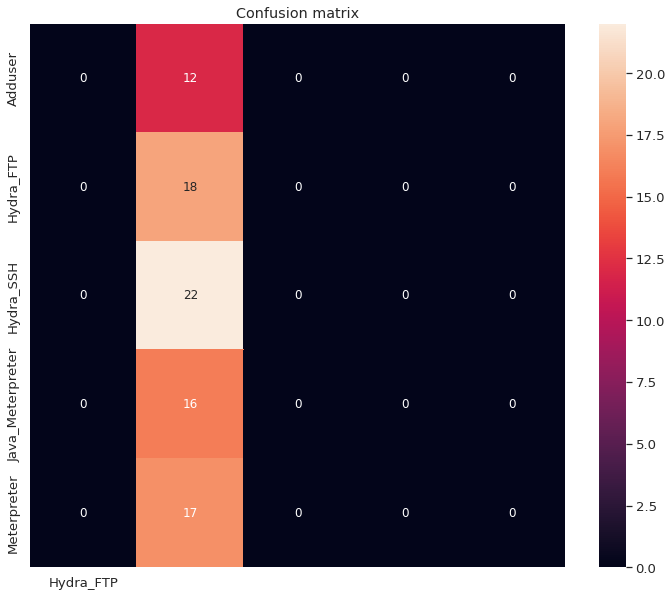

Model  Precision    Recall  Balanced Accuracy  \
0  CART   0.792829  0.792829           0.734548   
1  CART   0.188235  0.188235           0.205556   
2  CART   0.816733  0.816733           0.774359   
3  CART   0.211765  0.211765           0.233333   
4  CART   0.752988  0.752988           0.675742   
5  CART   0.211765  0.211765           0.200000   

   Matthews Correlation Coefficient     AUPRC  Time Taken  \
0                          0.565439  0.868508   32.202244   
1                          0.010233  0.269412   20.469904   
2                          0.607519  0.874864   44.490576   
3                          0.044657  0.290588   19.920349   
4                          0.492118  0.855923   29.119968   
5                          0.000000  0.290588   45.023680   

                      Evaluation  
0   Attack/Normal Classification  
1  Attacks Family Classification  
2   Attack/Normal Classification  
3  Attacks Family Classification  
4   Attack/Normal Classification  
5  Attacks Family Classification

Dataset Used : 3-gramme


Pipeline : Training for Attack/Normal Classification Model Used: RandomForest <====> Attacks Family Classification Model Used: RandomForest
Done


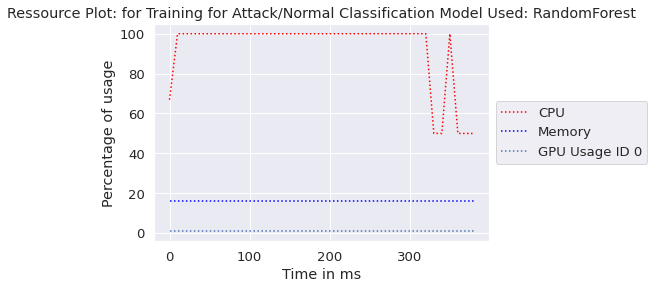

Evaluation of Attack/Normal Classification for RandomForest Algorithm
Precision:0.952191235059761

Recall:0.952191235059761

Accuracy:0.952191235059761

Balanced Accuracy:0.9409581646423752

Matthews Correlation Coefficient:0.8988142214876811

AUPRC:0.9637659493358648

Time Taken: 455.458402633667 ms



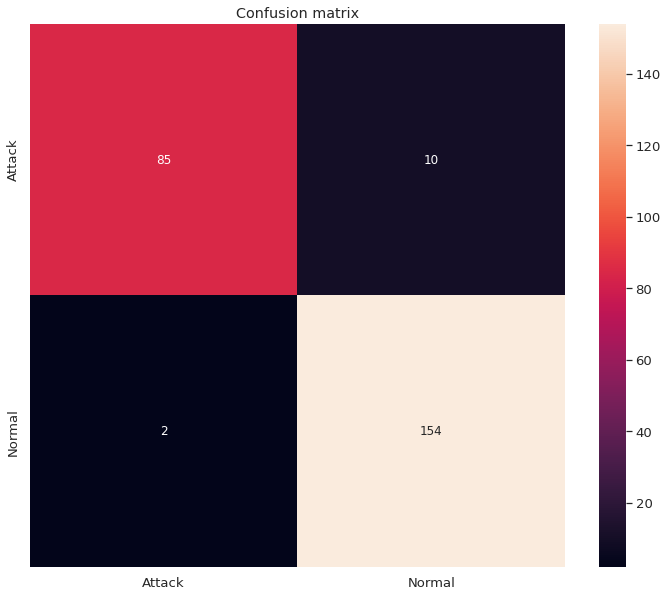

Done


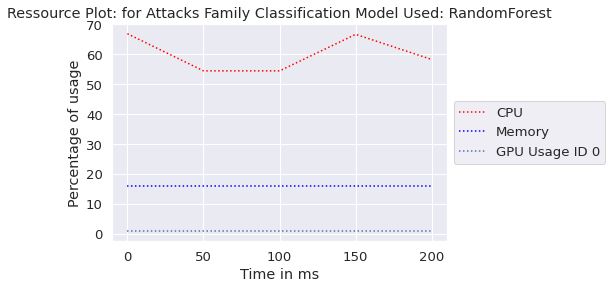

Evaluation of Attacks Family Classification Classification for RandomForest Algorithm
Precision:0.6352941176470588

Recall:0.6352941176470588

Accuracy:0.6352941176470588

Balanced Accuracy:0.6128639334521687

Matthews Correlation Coefficient:0.550532958147784

AUPRC:0.6717647058823528

Time Taken: 228.50608825683594 ms



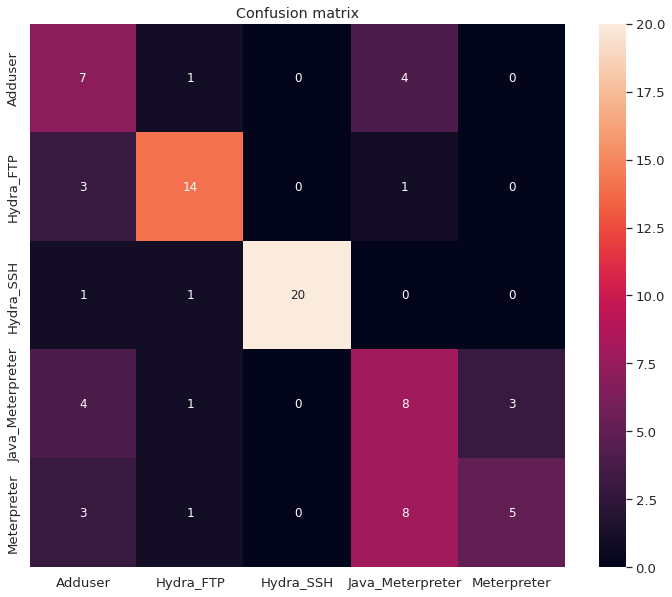

Dataset Used : 5-gramme


Pipeline : Training for Attack/Normal Classification Model Used: RandomForest <====> Attacks Family Classification Model Used: RandomForest
Done


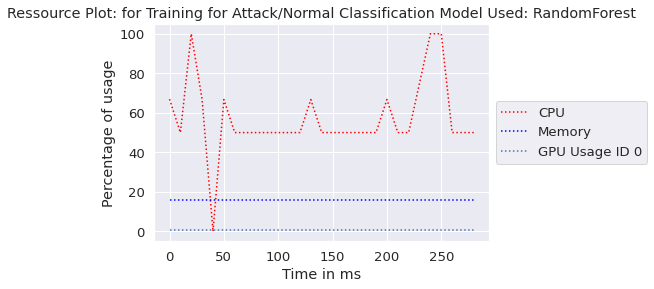

Evaluation of Attack/Normal Classification for RandomForest Algorithm
Precision:0.9362549800796812

Recall:0.9362549800796812

Accuracy:0.9362549800796812

Balanced Accuracy:0.9219635627530365

Matthews Correlation Coefficient:0.8648992911023975

AUPRC:0.9522240048148463

Time Taken: 318.5544013977051 ms



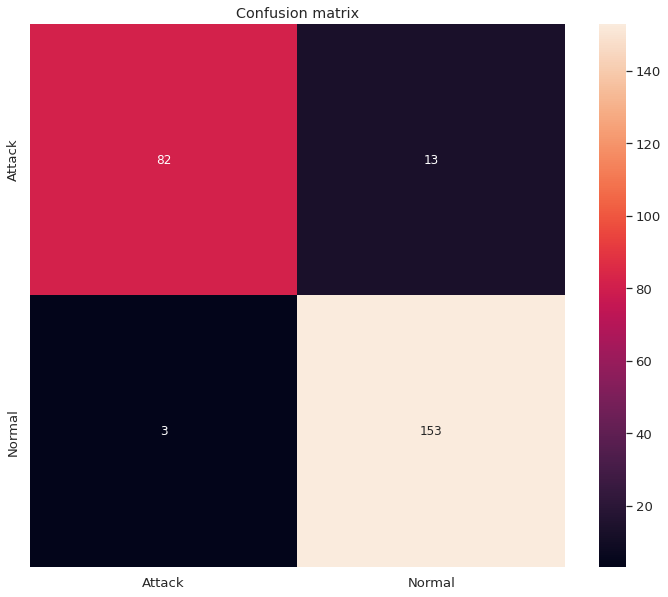

Done


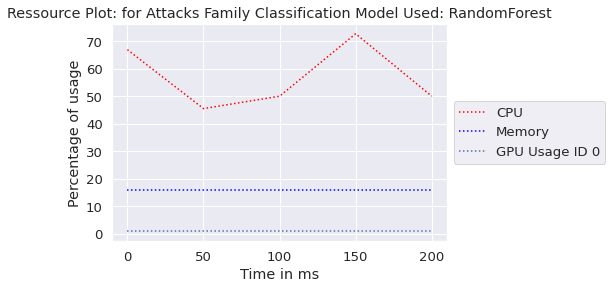

Evaluation of Attacks Family Classification Classification for RandomForest Algorithm
Precision:0.5764705882352941

Recall:0.5764705882352941

Accuracy:0.5764705882352941

Balanced Accuracy:0.5736185383244207

Matthews Correlation Coefficient:0.48115489485469115

AUPRC:0.6188235294117647

Time Taken: 234.51733589172363 ms



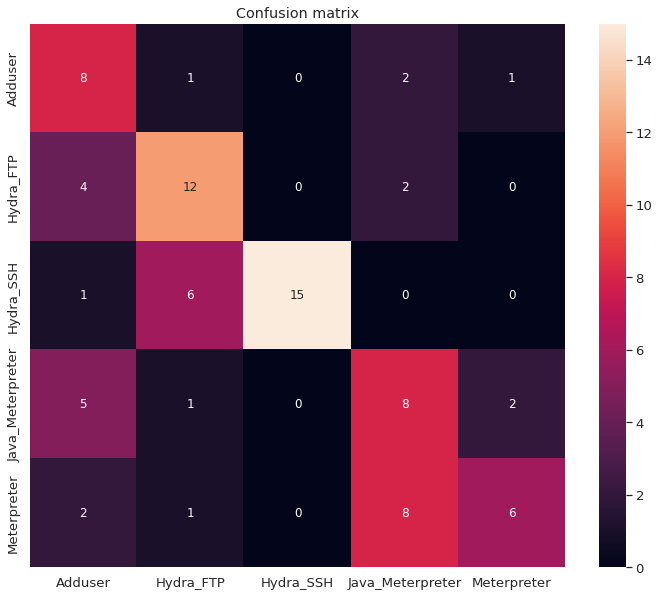

Dataset Used : 6-gramme


Pipeline : Training for Attack/Normal Classification Model Used: RandomForest <====> Attacks Family Classification Model Used: RandomForest
Done


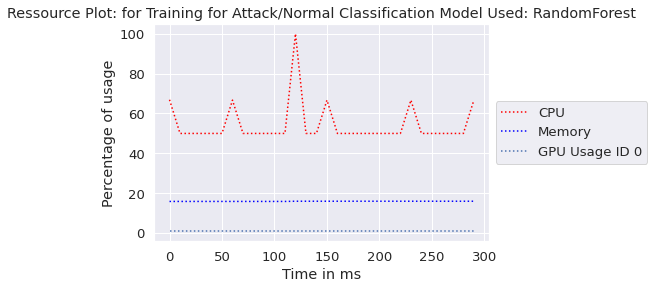

Evaluation of Attack/Normal Classification for RandomForest Algorithm
Precision:0.9083665338645418

Recall:0.9083665338645418

Accuracy:0.9083665338645418

Balanced Accuracy:0.9057017543859649

Matthews Correlation Coefficient:0.8066817466479457

AUPRC:0.9299696638283467

Time Taken: 329.9586772918701 ms



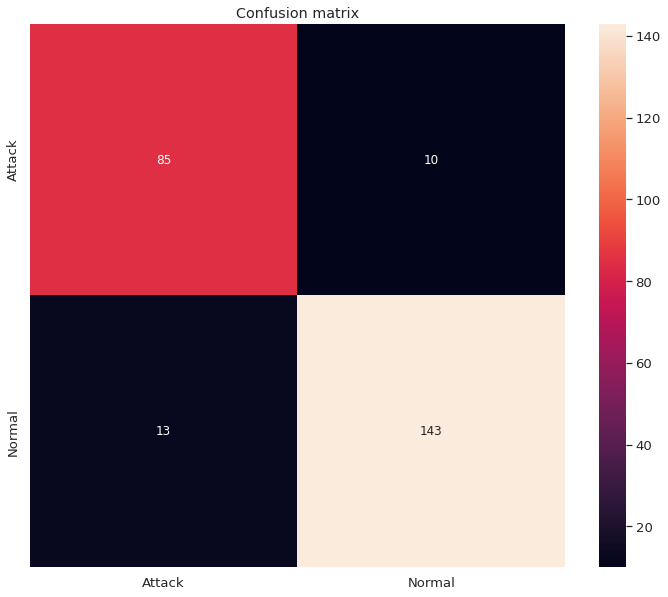

Done


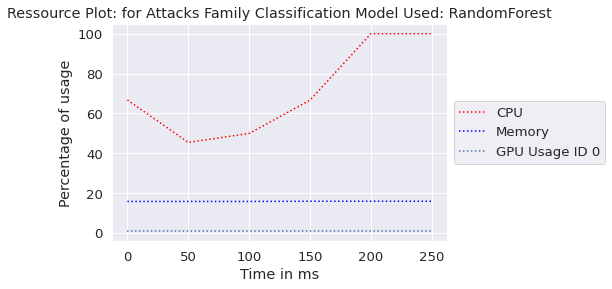

Evaluation of Attacks Family Classification Classification for RandomForest Algorithm
Precision:0.5882352941176471

Recall:0.5882352941176471

Accuracy:0.5882352941176471

Balanced Accuracy:0.5791146761734997

Matthews Correlation Coefficient:0.49406424581005587

AUPRC:0.6294117647058824

Time Taken: 302.3371696472168 ms



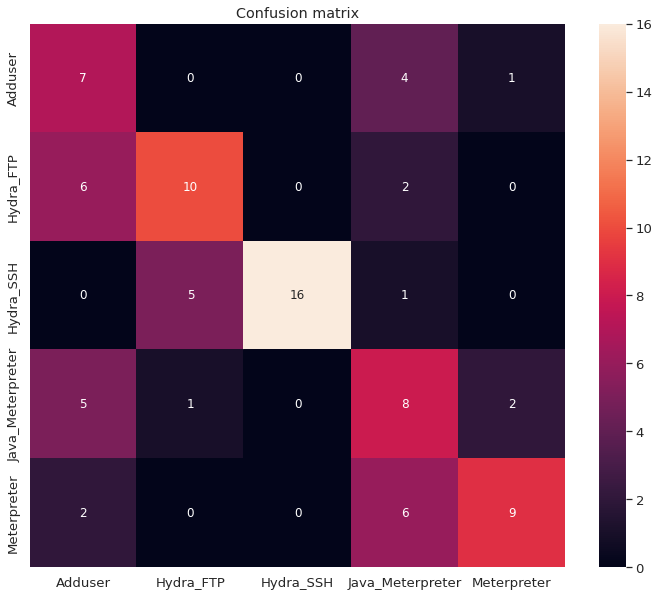

Model  Precision    Recall  Balanced Accuracy  \
0           CART   0.792829  0.792829           0.734548   
1           CART   0.188235  0.188235           0.205556   
2           CART   0.816733  0.816733           0.774359   
3           CART   0.211765  0.211765           0.233333   
4           CART   0.752988  0.752988           0.675742   
5           CART   0.211765  0.211765           0.200000   
6   RandomForest   0.952191  0.952191           0.940958   
7   RandomForest   0.635294  0.635294           0.612864   
8   RandomForest   0.936255  0.936255           0.921964   
9   RandomForest   0.576471  0.576471           0.573619   
10  RandomForest   0.908367  0.908367           0.905702   
11  RandomForest   0.588235  0.588235           0.579115   

    Matthews Correlation Coefficient     AUPRC  Time Taken  \
0                           0.565439  0.868508   32.202244   
1                           0.010233  0.269412   20.469904   
2                           0.607519  0.874864   44.490576   
3                           0.044657  0.290588   19.920349   
4                           0.492118  0.855923   29.119968   
5                           0.000000  0.290588   45.023680   
6                           0.898814  0.963766  455.458403   
7                           0.550533  0.671765  228.506088   
8                           0.864899  0.952224  318.554401   
9                           0.481155  0.618824  234.517336   
10                          0.806682  0.929970  329.958677   
11                          0.494064  0.629412  302.337170   

                       Evaluation  
0    Attack/Normal Classification  
1   Attacks Family Classification  
2    Attack/Normal Classification  
3   Attacks Family Classification  
4    Attack/Normal Classification  
5   Attacks Family Classification  
6    Attack/Normal Classification  
7   Attacks Family Classification  
8    Attack/Normal Classification  
9   Attacks Family Classification  
10   Attack/Normal Classification  
11  Attacks Family Classification

Dataset Used : 3-gramme


Pipeline : Training for Attack/Normal Classification Model Used: KNN <====> Attacks Family Classification Model Used: KNN
Done


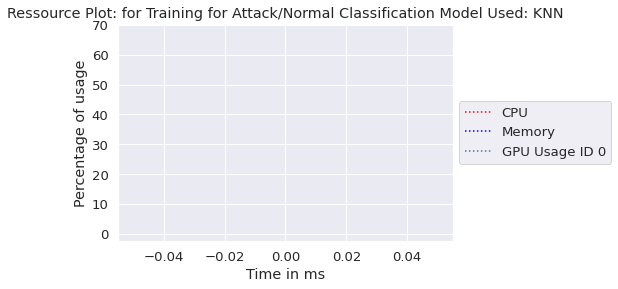

Evaluation of Attack/Normal Classification for KNN Algorithm
Precision:0.896414342629482

Recall:0.896414342629482

Accuracy:0.896414342629482

Balanced Accuracy:0.891970310391363

Matthews Correlation Coefficient:0.7808381840463888

AUPRC:0.9208152405363561

Time Taken: 22.367238998413086 ms



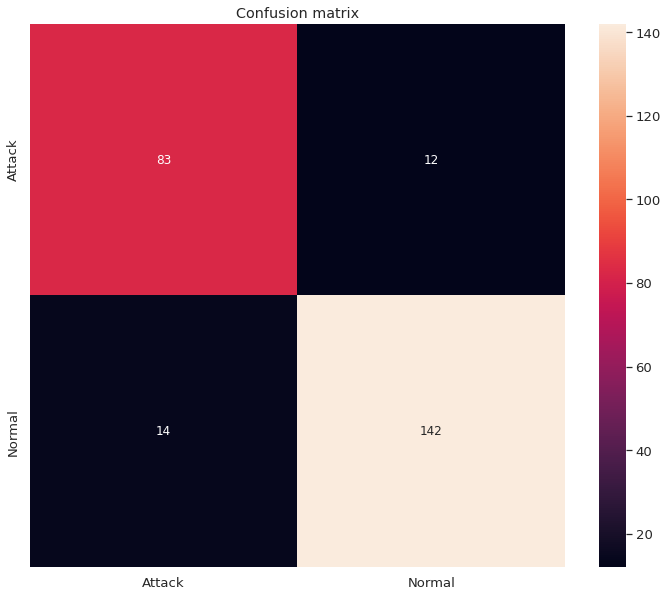

Done


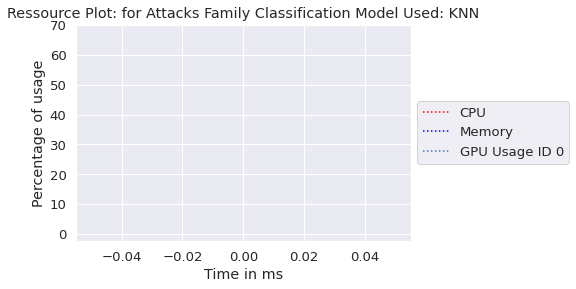

Evaluation of Attacks Family Classification Classification for KNN Algorithm
Precision:0.5647058823529412

Recall:0.5647058823529412

Accuracy:0.5647058823529412

Balanced Accuracy:0.5734922756981581

Matthews Correlation Coefficient:0.461270023878022

AUPRC:0.608235294117647

Time Taken: 14.45150375366211 ms



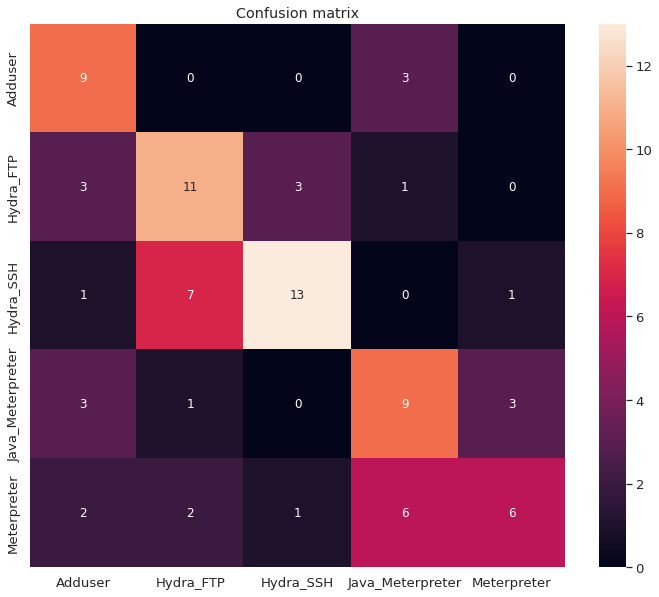

Dataset Used : 5-gramme


Pipeline : Training for Attack/Normal Classification Model Used: KNN <====> Attacks Family Classification Model Used: KNN
Done


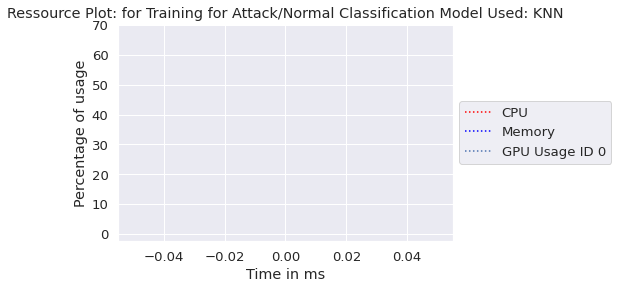

Evaluation of Attack/Normal Classification for KNN Algorithm
Precision:0.8884462151394422

Recall:0.8884462151394422

Accuracy:0.8884462151394422

Balanced Accuracy:0.8896761133603239

Matthews Correlation Coefficient:0.7684372557134891

AUPRC:0.9145000041414384

Time Taken: 14.394283294677734 ms



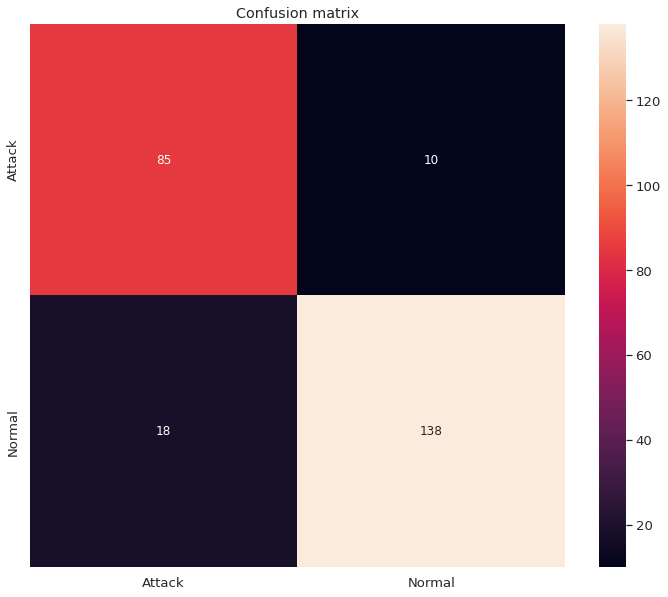

Done


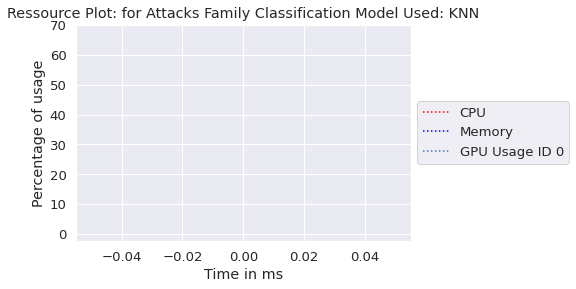

Evaluation of Attacks Family Classification Classification for KNN Algorithm
Precision:0.5294117647058824

Recall:0.5294117647058824

Accuracy:0.5294117647058824

Balanced Accuracy:0.5468731431966727

Matthews Correlation Coefficient:0.4214113914142961

AUPRC:0.5764705882352941

Time Taken: 15.246868133544922 ms



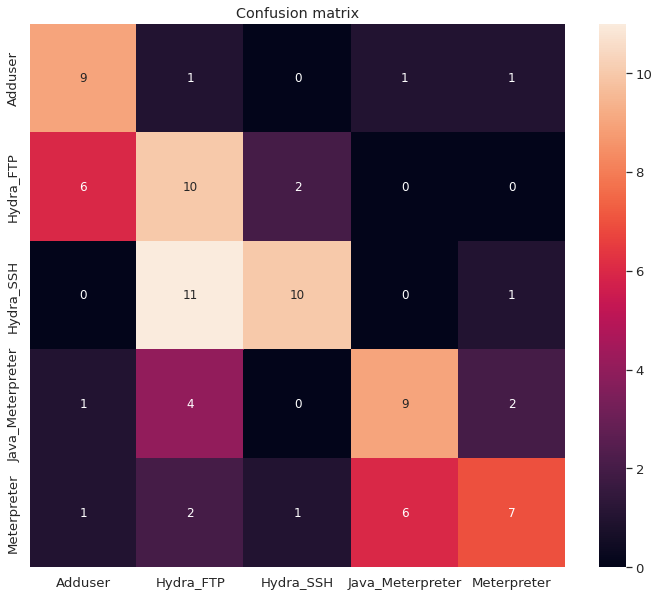

Dataset Used : 6-gramme


Pipeline : Training for Attack/Normal Classification Model Used: KNN <====> Attacks Family Classification Model Used: KNN
Done


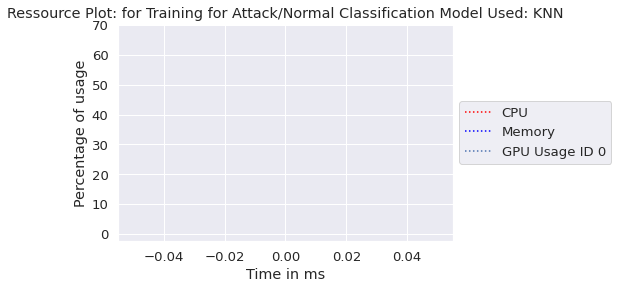

Evaluation of Attack/Normal Classification for KNN Algorithm
Precision:0.8884462151394422

Recall:0.8884462151394422

Accuracy:0.8884462151394422

Balanced Accuracy:0.8917341430499326

Matthews Correlation Coefficient:0.7703258038585885

AUPRC:0.9145887472239598

Time Taken: 16.097545623779297 ms



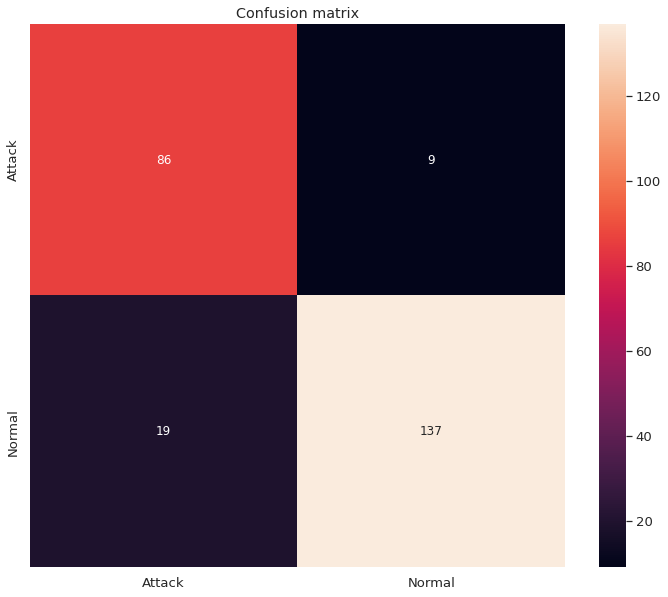

Done


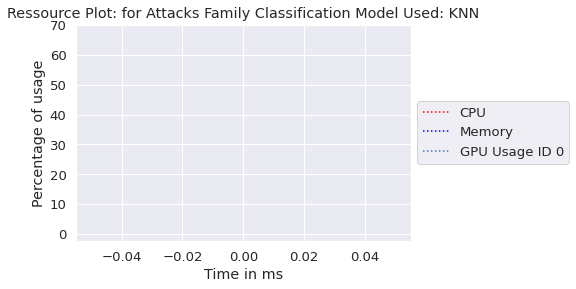

Evaluation of Attacks Family Classification Classification for KNN Algorithm
Precision:0.43529411764705883

Recall:0.43529411764705883

Accuracy:0.43529411764705883

Balanced Accuracy:0.45652852049910864

Matthews Correlation Coefficient:0.3174284891530419

AUPRC:0.49176470588235294

Time Taken: 17.14301109313965 ms



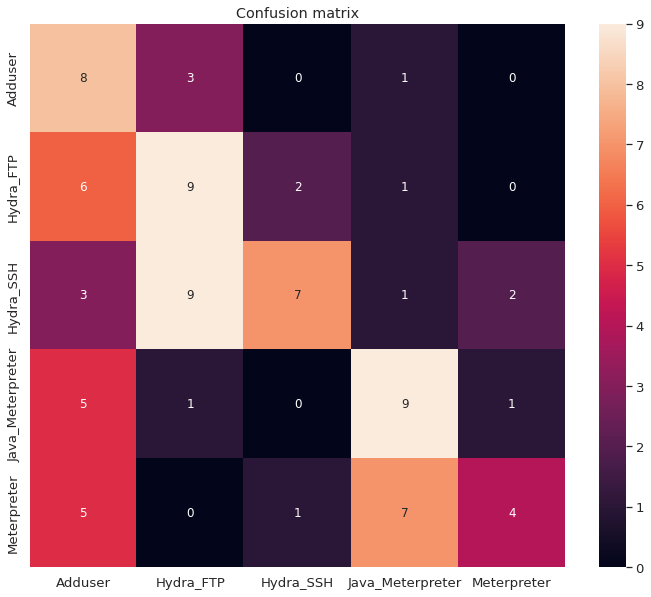

Model  Precision    Recall  Balanced Accuracy  \
0           CART   0.792829  0.792829           0.734548   
1           CART   0.188235  0.188235           0.205556   
2           CART   0.816733  0.816733           0.774359   
3           CART   0.211765  0.211765           0.233333   
4           CART   0.752988  0.752988           0.675742   
5           CART   0.211765  0.211765           0.200000   
6   RandomForest   0.952191  0.952191           0.940958   
7   RandomForest   0.635294  0.635294           0.612864   
8   RandomForest   0.936255  0.936255           0.921964   
9   RandomForest   0.576471  0.576471           0.573619   
10  RandomForest   0.908367  0.908367           0.905702   
11  RandomForest   0.588235  0.588235           0.579115   
12           KNN   0.896414  0.896414           0.891970   
13           KNN   0.564706  0.564706           0.573492   
14           KNN   0.888446  0.888446           0.889676   
15           KNN   0.529412  0.529412           0.546873   
16           KNN   0.888446  0.888446           0.891734   
17           KNN   0.435294  0.435294           0.456529   

    Matthews Correlation Coefficient     AUPRC  Time Taken  \
0                           0.565439  0.868508   32.202244   
1                           0.010233  0.269412   20.469904   
2                           0.607519  0.874864   44.490576   
3                           0.044657  0.290588   19.920349   
4                           0.492118  0.855923   29.119968   
5                           0.000000  0.290588   45.023680   
6                           0.898814  0.963766  455.458403   
7                           0.550533  0.671765  228.506088   
8                           0.864899  0.952224  318.554401   
9                           0.481155  0.618824  234.517336   
10                          0.806682  0.929970  329.958677   
11                          0.494064  0.629412  302.337170   
12                          0.780838  0.920815   22.367239   
13                          0.461270  0.608235   14.451504   
14                          0.768437  0.914500   14.394283   
15                          0.421411  0.576471   15.246868   
16                          0.770326  0.914589   16.097546   
17                          0.317428  0.491765   17.143011   

                       Evaluation  
0    Attack/Normal Classification  
1   Attacks Family Classification  
2    Attack/Normal Classification  
3   Attacks Family Classification  
4    Attack/Normal Classification  
5   Attacks Family Classification  
6    Attack/Normal Classification  
7   Attacks Family Classification  
8    Attack/Normal Classification  
9   Attacks Family Classification  
10   Attack/Normal Classification  
11  Attacks Family Classification  
12   Attack/Normal Classification  
13  Attacks Family Classification  
14   Attack/Normal Classification  
15  Attacks Family Classification  
16   Attack/Normal Classification  
17  Attacks Family Classification

Dataset Used : 3-gramme


Pipeline : Training for Attack/Normal Classification Model Used: XGBOOST <====> Attacks Family Classification Model Used: XGBOOST
Done


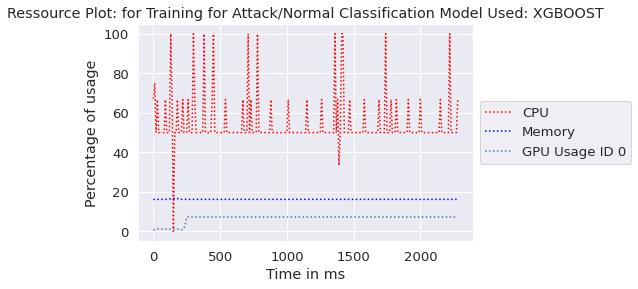

Evaluation of Attack/Normal Classification for XGBOOST Algorithm
Precision:0.9601593625498008

Recall:0.9601593625498008

Accuracy:0.9601593625498008

Balanced Accuracy:0.9514844804318489

Matthews Correlation Coefficient:0.9154706241847304

AUPRC:0.9695623961892222

Time Taken: 2433.0973625183105 ms



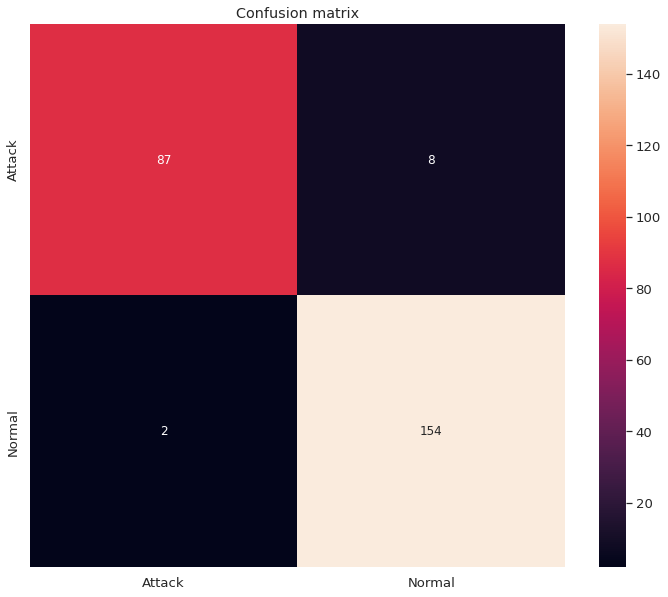

Done


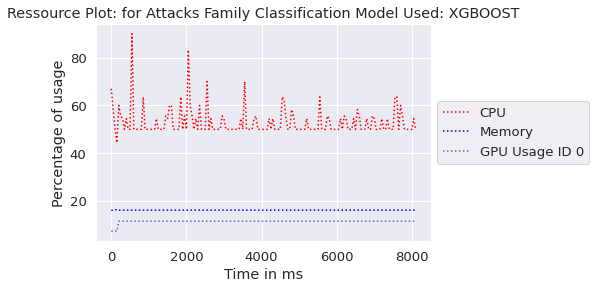

Evaluation of Attacks Family Classification Classification for XGBOOST Algorithm
Precision:0.6352941176470588

Recall:0.6352941176470588

Accuracy:0.6352941176470588

Balanced Accuracy:0.6245023767082591

Matthews Correlation Coefficient:0.5476557794532487

AUPRC:0.6717647058823528

Time Taken: 8260.708570480347 ms



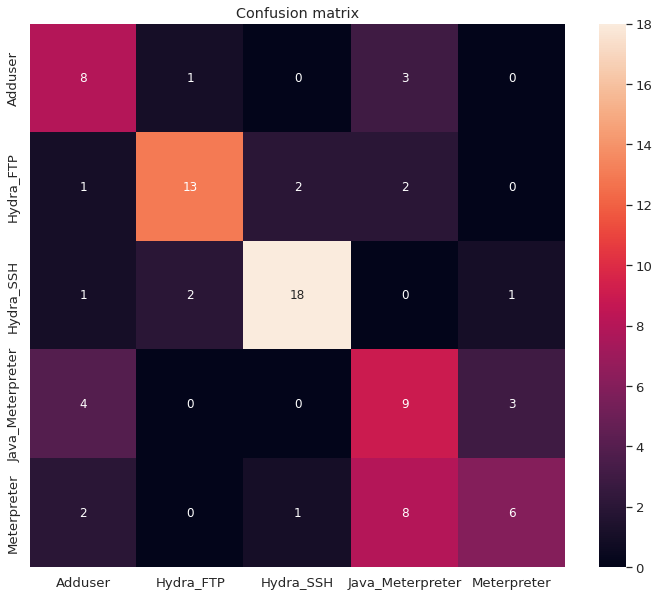

Dataset Used : 5-gramme


Pipeline : Training for Attack/Normal Classification Model Used: XGBOOST <====> Attacks Family Classification Model Used: XGBOOST
Done


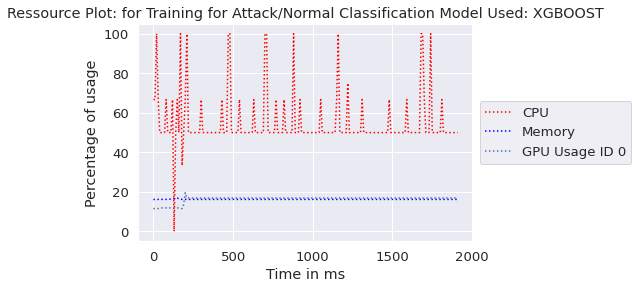

Evaluation of Attack/Normal Classification for XGBOOST Algorithm
Precision:0.9243027888446215

Recall:0.9243027888446215

Accuracy:0.9243027888446215

Balanced Accuracy:0.9061740890688259

Matthews Correlation Coefficient:0.8400710800785236

AUPRC:0.9440433532143614

Time Taken: 2025.7596969604492 ms



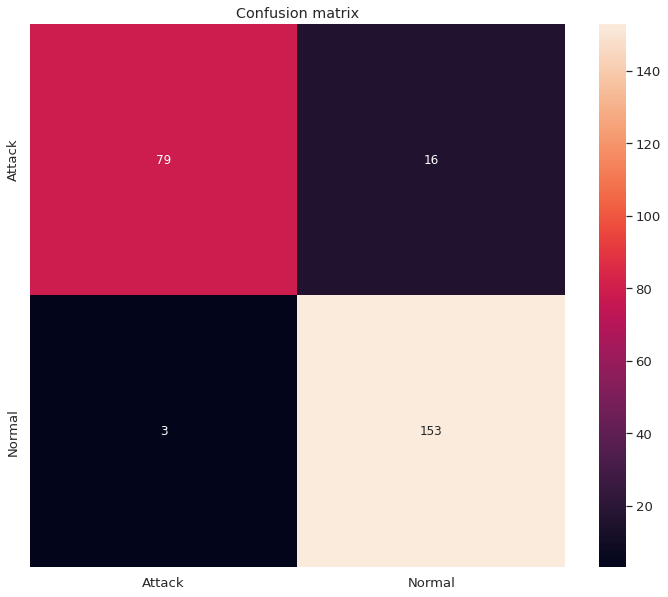

Done


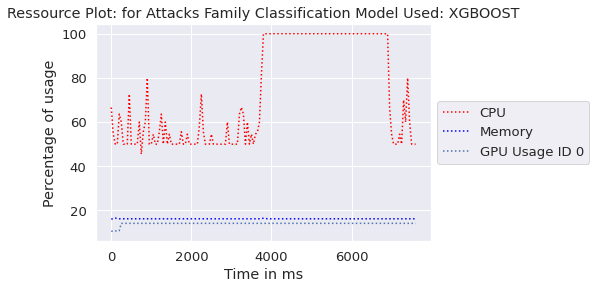

Evaluation of Attacks Family Classification Classification for XGBOOST Algorithm
Precision:0.6

Recall:0.6

Accuracy:0.6

Balanced Accuracy:0.5855912061794415

Matthews Correlation Coefficient:0.5069783586564091

AUPRC:0.64

Time Taken: 7784.920692443848 ms



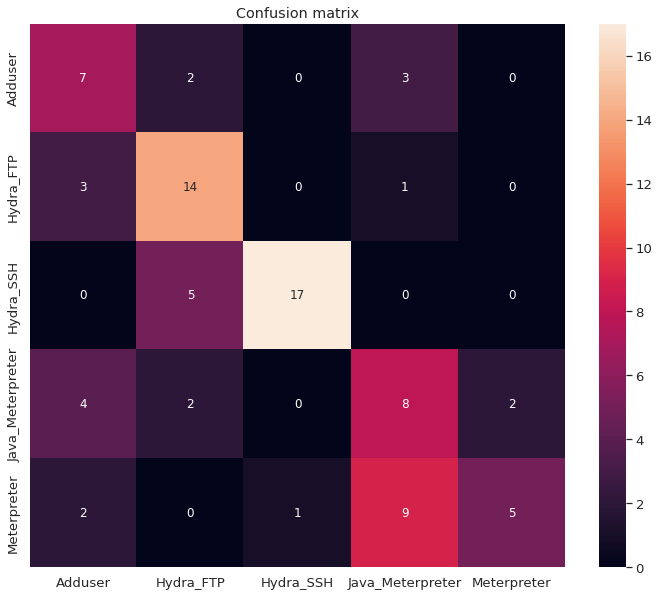

Dataset Used : 6-gramme


Pipeline : Training for Attack/Normal Classification Model Used: XGBOOST <====> Attacks Family Classification Model Used: XGBOOST
Done


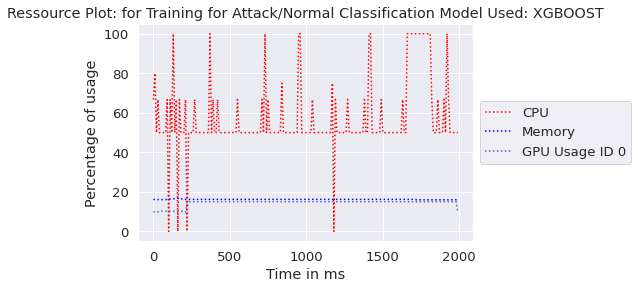

Evaluation of Attack/Normal Classification for XGBOOST Algorithm
Precision:0.9203187250996016

Recall:0.9203187250996016

Accuracy:0.9203187250996016

Balanced Accuracy:0.900910931174089

Matthews Correlation Coefficient:0.8318308542609277

AUPRC:0.9413806313208702

Time Taken: 2137.7224922180176 ms



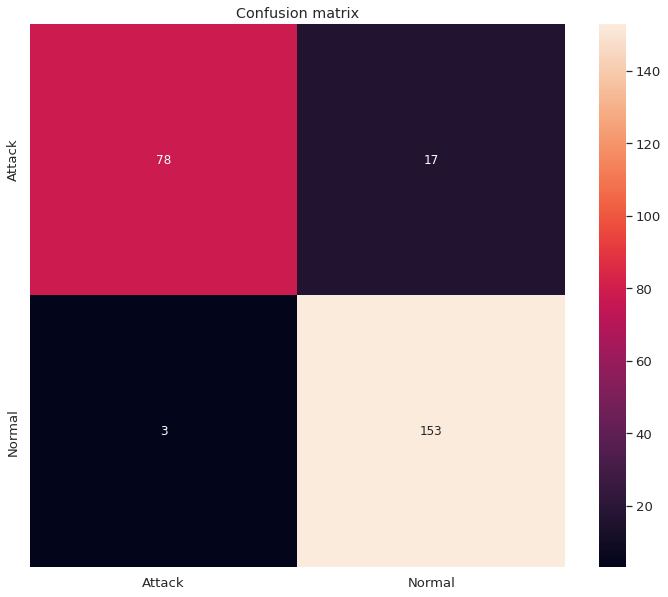

Done


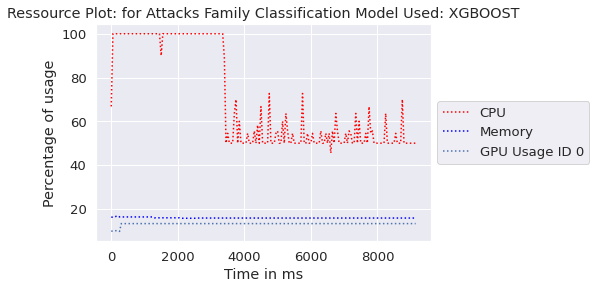

Evaluation of Attacks Family Classification Classification for XGBOOST Algorithm
Precision:0.5411764705882353

Recall:0.5411764705882353

Accuracy:0.5411764705882353

Balanced Accuracy:0.5296197266785503

Matthews Correlation Coefficient:0.43790399025397964

AUPRC:0.5870588235294116

Time Taken: 9348.868608474731 ms



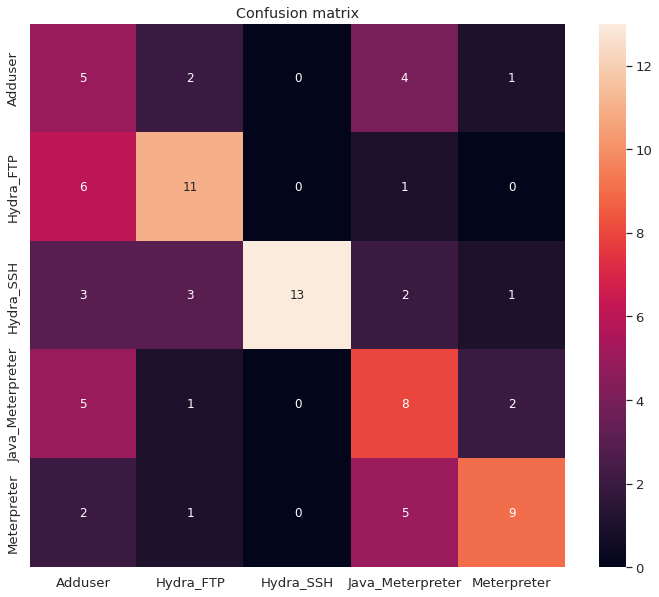

Model  Precision    Recall  Balanced Accuracy  \
0           CART   0.792829  0.792829           0.734548   
1           CART   0.188235  0.188235           0.205556   
2           CART   0.816733  0.816733           0.774359   
3           CART   0.211765  0.211765           0.233333   
4           CART   0.752988  0.752988           0.675742   
5           CART   0.211765  0.211765           0.200000   
6   RandomForest   0.952191  0.952191           0.940958   
7   RandomForest   0.635294  0.635294           0.612864   
8   RandomForest   0.936255  0.936255           0.921964   
9   RandomForest   0.576471  0.576471           0.573619   
10  RandomForest   0.908367  0.908367           0.905702   
11  RandomForest   0.588235  0.588235           0.579115   
12           KNN   0.896414  0.896414           0.891970   
13           KNN   0.564706  0.564706           0.573492   
14           KNN   0.888446  0.888446           0.889676   
15           KNN   0.529412  0.529412           0.546873   
16           KNN   0.888446  0.888446           0.891734   
17           KNN   0.435294  0.435294           0.456529   
18       XGBOOST   0.960159  0.960159           0.951484   
19       XGBOOST   0.635294  0.635294           0.624502   
20       XGBOOST   0.924303  0.924303           0.906174   
21       XGBOOST   0.600000  0.600000           0.585591   
22       XGBOOST   0.920319  0.920319           0.900911   
23       XGBOOST   0.541176  0.541176           0.529620   

    Matthews Correlation Coefficient     AUPRC   Time Taken  \
0                           0.565439  0.868508    32.202244   
1                           0.010233  0.269412    20.469904   
2                           0.607519  0.874864    44.490576   
3                           0.044657  0.290588    19.920349   
4                           0.492118  0.855923    29.119968   
5                           0.000000  0.290588    45.023680   
6                           0.898814  0.963766   455.458403   
7                           0.550533  0.671765   228.506088   
8                           0.864899  0.952224   318.554401   
9                           0.481155  0.618824   234.517336   
10                          0.806682  0.929970   329.958677   
11                          0.494064  0.629412   302.337170   
12                          0.780838  0.920815    22.367239   
13                          0.461270  0.608235    14.451504   
14                          0.768437  0.914500    14.394283   
15                          0.421411  0.576471    15.246868   
16                          0.770326  0.914589    16.097546   
17                          0.317428  0.491765    17.143011   
18                          0.915471  0.969562  2433.097363   
19                          0.547656  0.671765  8260.708570   
20                          0.840071  0.944043  2025.759697   
21                          0.506978  0.640000  7784.920692   
22                          0.831831  0.941381  2137.722492   
23                          0.437904  0.587059  9348.868608   

                       Evaluation  
0    Attack/Normal Classification  
1   Attacks Family Classification  
2    Attack/Normal Classification  
3   Attacks Family Classification  
4    Attack/Normal Classification  
5   Attacks Family Classification  
6    Attack/Normal Classification  
7   Attacks Family Classification  
8    Attack/Normal Classification  
9   Attacks Family Classification  
10   Attack/Normal Classification  
11  Attacks Family Classification  
12   Attack/Normal Classification  
13  Attacks Family Classification  
14   Attack/Normal Classification  
15  Attacks Family Classification  
16   Attack/Normal Classification  
17  Attacks Family Classification  
18   Attack/Normal Classification  
19  Attacks Family Classification  
20   Attack/Normal Classification  
21  Attacks Family Classification  
22   Attack/Normal Classification  
23  Attacks Family Classification

Dataset Used : 3-gramme


Pipeline : Training for Attack/Normal Classification Model Used: MLP <====> Attacks Family Classification Model Used: MLP
Done


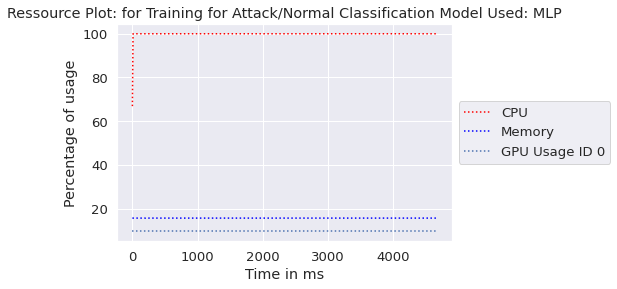

Evaluation of Attack/Normal Classification for MLP Algorithm
Precision:0.9641434262948207

Recall:0.9641434262948207

Accuracy:0.9641434262948207

Balanced Accuracy:0.9588056680161943

Matthews Correlation Coefficient:0.9236137636369313

AUPRC:0.9725127067925685

Time Taken: 4989.22872543335 ms



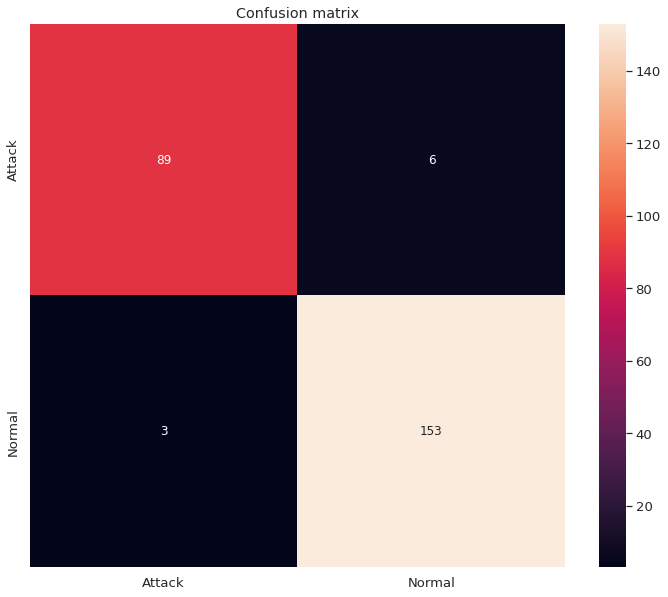

Done


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


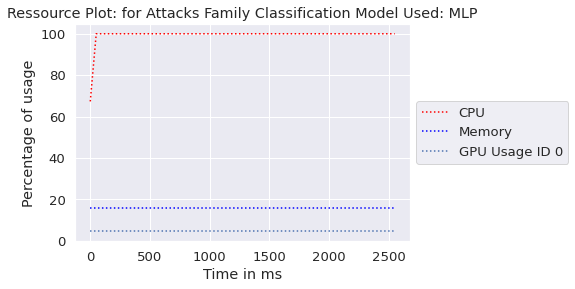

Evaluation of Attacks Family Classification Classification for MLP Algorithm
Precision:0.6588235294117647

Recall:0.6588235294117647

Accuracy:0.6588235294117647

Balanced Accuracy:0.6439913844325609

Matthews Correlation Coefficient:0.5750698324022346

AUPRC:0.6929411764705883

Time Taken: 2648.0445861816406 ms



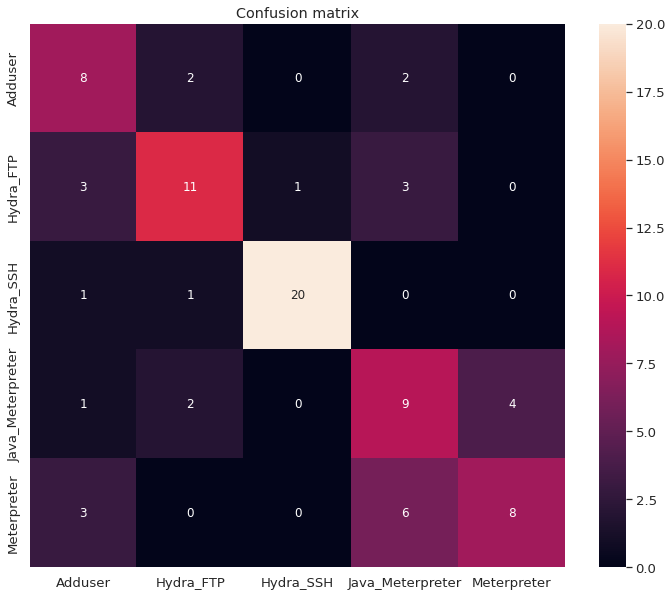

Dataset Used : 5-gramme


Pipeline : Training for Attack/Normal Classification Model Used: MLP <====> Attacks Family Classification Model Used: MLP
Done


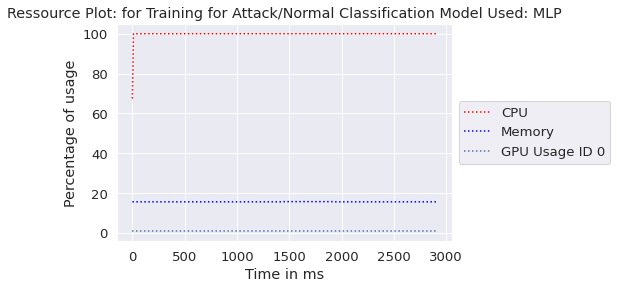

Evaluation of Attack/Normal Classification for MLP Algorithm
Precision:0.9362549800796812

Recall:0.9362549800796812

Accuracy:0.9362549800796812

Balanced Accuracy:0.9322537112010796

Matthews Correlation Coefficient:0.8645074224021593

AUPRC:0.9513739912146286

Time Taken: 3106.600284576416 ms



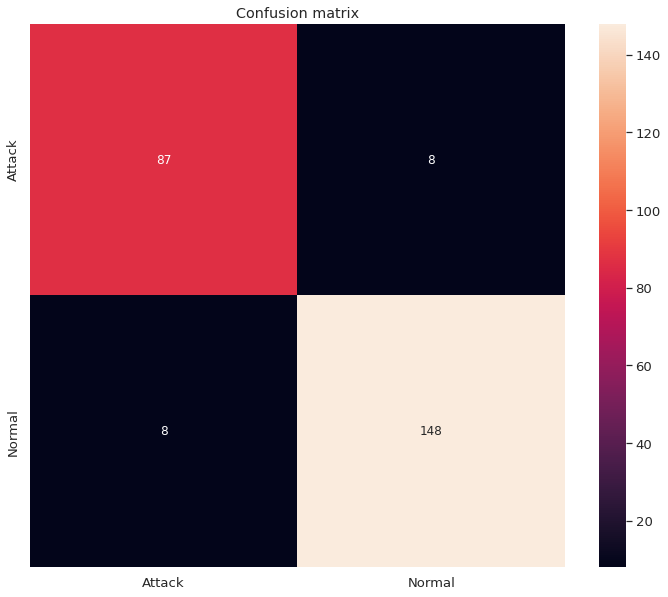

Done


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


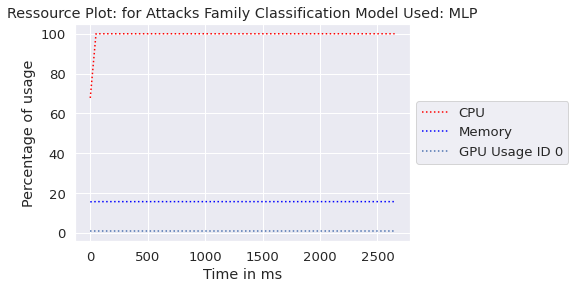

Evaluation of Attacks Family Classification Classification for MLP Algorithm
Precision:0.6

Recall:0.6

Accuracy:0.6

Balanced Accuracy:0.575891265597148

Matthews Correlation Coefficient:0.5058279211766361

AUPRC:0.64

Time Taken: 2729.7422885894775 ms



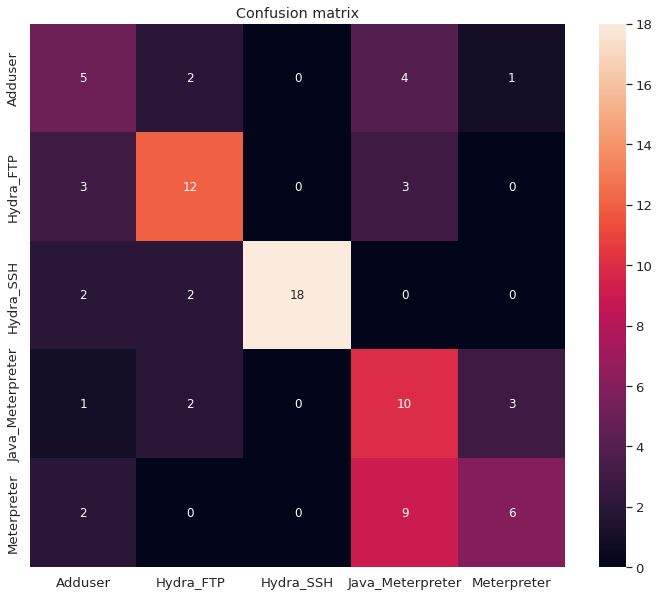

Dataset Used : 6-gramme


Pipeline : Training for Attack/Normal Classification Model Used: MLP <====> Attacks Family Classification Model Used: MLP
Done


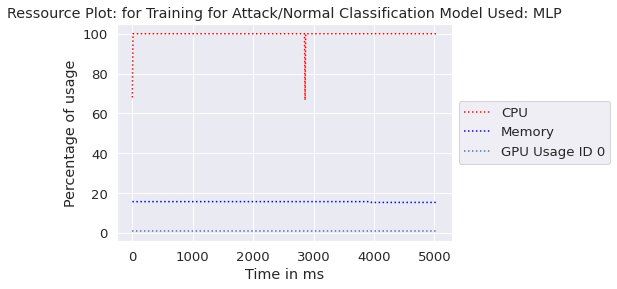

Evaluation of Attack/Normal Classification for MLP Algorithm
Precision:0.9203187250996016

Recall:0.9203187250996016

Accuracy:0.9203187250996016

Balanced Accuracy:0.9153171390013495

Matthews Correlation Coefficient:0.8306342780026991

AUPRC:0.9392174890182858

Time Taken: 5363.236427307129 ms



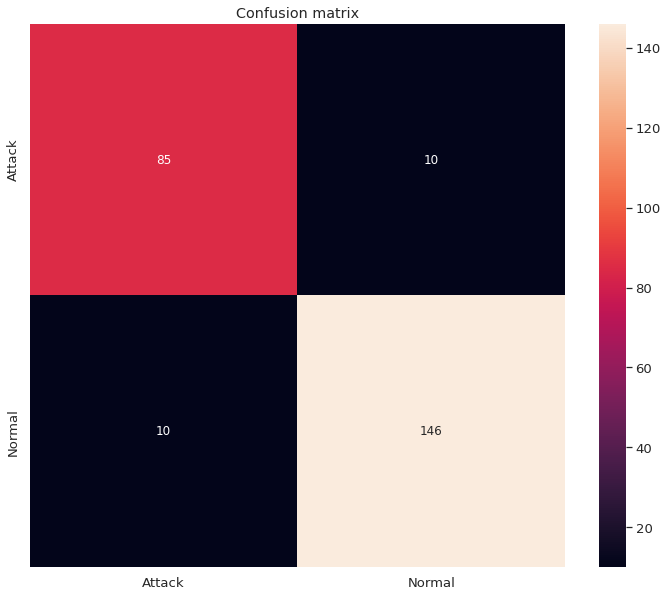

Done


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


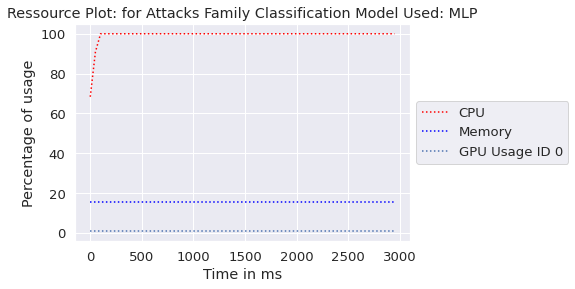

Evaluation of Attacks Family Classification Classification for MLP Algorithm
Precision:0.6352941176470588

Recall:0.6352941176470588

Accuracy:0.6352941176470588

Balanced Accuracy:0.5979723707664883

Matthews Correlation Coefficient:0.541093552860263

AUPRC:0.6717647058823528

Time Taken: 3042.781352996826 ms



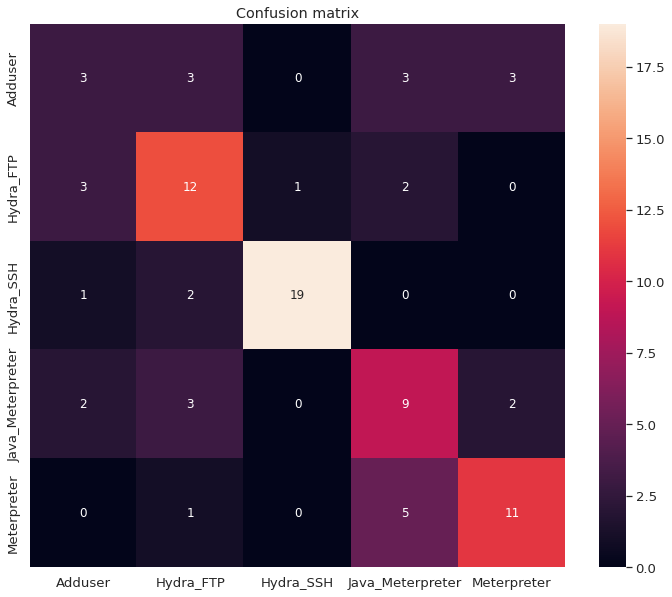

Model  Precision    Recall  Balanced Accuracy  \
0           CART   0.792829  0.792829           0.734548   
1           CART   0.188235  0.188235           0.205556   
2           CART   0.816733  0.816733           0.774359   
3           CART   0.211765  0.211765           0.233333   
4           CART   0.752988  0.752988           0.675742   
5           CART   0.211765  0.211765           0.200000   
6   RandomForest   0.952191  0.952191           0.940958   
7   RandomForest   0.635294  0.635294           0.612864   
8   RandomForest   0.936255  0.936255           0.921964   
9   RandomForest   0.576471  0.576471           0.573619   
10  RandomForest   0.908367  0.908367           0.905702   
11  RandomForest   0.588235  0.588235           0.579115   
12           KNN   0.896414  0.896414           0.891970   
13           KNN   0.564706  0.564706           0.573492   
14           KNN   0.888446  0.888446           0.889676   
15           KNN   0.529412  0.529412           0.546873   
16           KNN   0.888446  0.888446           0.891734   
17           KNN   0.435294  0.435294           0.456529   
18       XGBOOST   0.960159  0.960159           0.951484   
19       XGBOOST   0.635294  0.635294           0.624502   
20       XGBOOST   0.924303  0.924303           0.906174   
21       XGBOOST   0.600000  0.600000           0.585591   
22       XGBOOST   0.920319  0.920319           0.900911   
23       XGBOOST   0.541176  0.541176           0.529620   
24           MLP   0.964143  0.964143           0.958806   
25           MLP   0.658824  0.658824           0.643991   
26           MLP   0.936255  0.936255           0.932254   
27           MLP   0.600000  0.600000           0.575891   
28           MLP   0.920319  0.920319           0.915317   
29           MLP   0.635294  0.635294           0.597972   

    Matthews Correlation Coefficient     AUPRC   Time Taken  \
0                           0.565439  0.868508    32.202244   
1                           0.010233  0.269412    20.469904   
2                           0.607519  0.874864    44.490576   
3                           0.044657  0.290588    19.920349   
4                           0.492118  0.855923    29.119968   
5                           0.000000  0.290588    45.023680   
6                           0.898814  0.963766   455.458403   
7                           0.550533  0.671765   228.506088   
8                           0.864899  0.952224   318.554401   
9                           0.481155  0.618824   234.517336   
10                          0.806682  0.929970   329.958677   
11                          0.494064  0.629412   302.337170   
12                          0.780838  0.920815    22.367239   
13                          0.461270  0.608235    14.451504   
14                          0.768437  0.914500    14.394283   
15                          0.421411  0.576471    15.246868   
16                          0.770326  0.914589    16.097546   
17                          0.317428  0.491765    17.143011   
18                          0.915471  0.969562  2433.097363   
19                          0.547656  0.671765  8260.708570   
20                          0.840071  0.944043  2025.759697   
21                          0.506978  0.640000  7784.920692   
22                          0.831831  0.941381  2137.722492   
23                          0.437904  0.587059  9348.868608   
24                          0.923614  0.972513  4989.228725   
25                          0.575070  0.692941  2648.044586   
26                          0.864507  0.951374  3106.600285   
27                          0.505828  0.640000  2729.742289   
28                          0.830634  0.939217  5363.236427   
29                          0.541094  0.671765  3042.781353   

                       Evaluation  
0    Attack/Normal Classification  
1   Attacks Family Classification  
2    Attack/Normal Classification  
3   Attacks Family Classification  
4    Attack/Norm

Dataset Used : 3-gramme


Pipeline : Training for Attack/Normal Classification Model Used: SVM <====> Attacks Family Classification Model Used: SVM
Done


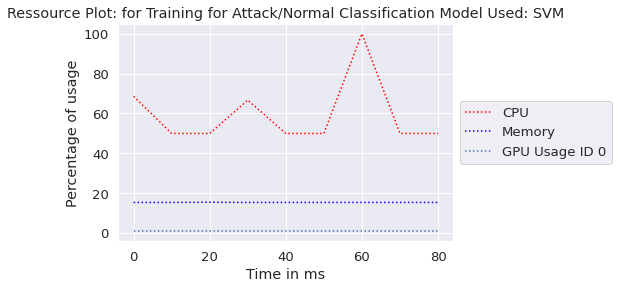

Evaluation of Attack/Normal Classification for SVM Algorithm
Precision:0.9442231075697212

Recall:0.9442231075697212

Accuracy:0.9442231075697212

Balanced Accuracy:0.9366059379217274

Matthews Correlation Coefficient:0.8809739118330163

AUPRC:0.9575093855347839

Time Taken: 119.20857429504395 ms



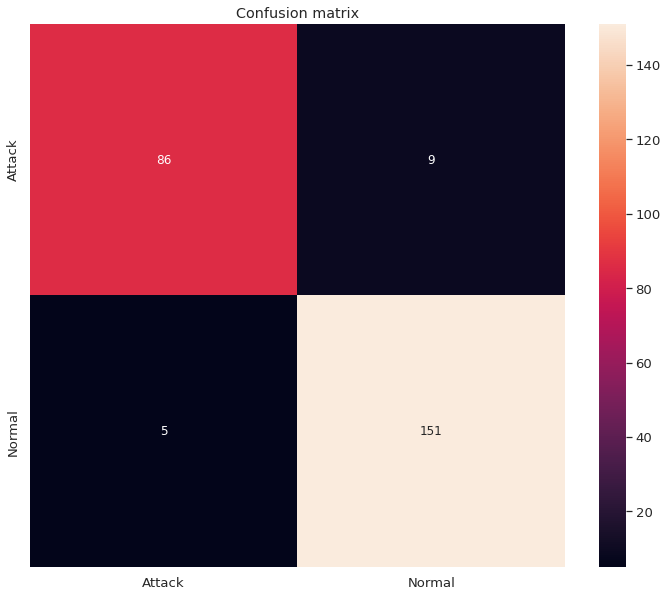

Done


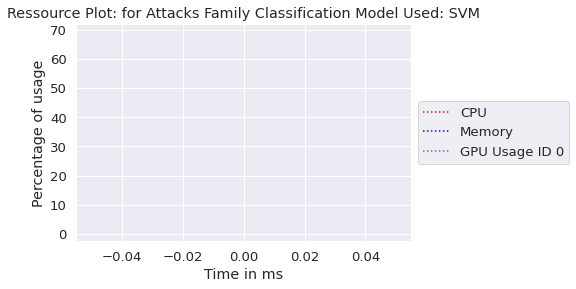

Evaluation of Attacks Family Classification Classification for SVM Algorithm
Precision:0.6235294117647059

Recall:0.6235294117647059

Accuracy:0.6235294117647059

Balanced Accuracy:0.6022801544860369

Matthews Correlation Coefficient:0.5326504153036399

AUPRC:0.6611764705882353

Time Taken: 63.27509880065918 ms



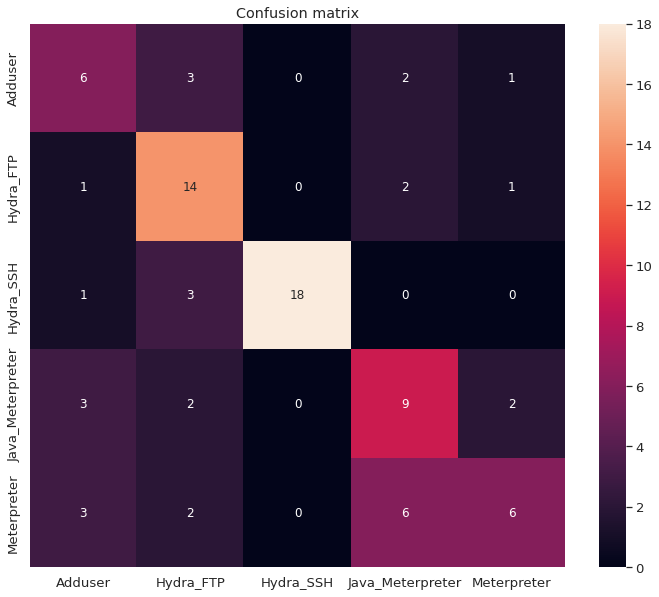

Dataset Used : 5-gramme


Pipeline : Training for Attack/Normal Classification Model Used: SVM <====> Attacks Family Classification Model Used: SVM
Done


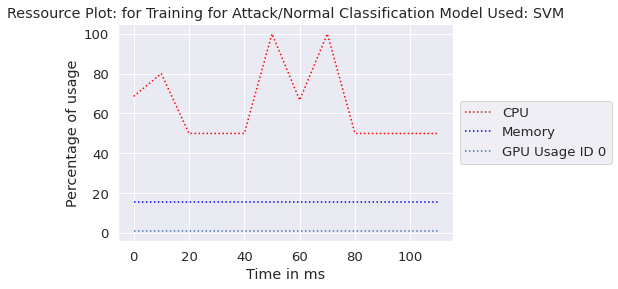

Evaluation of Attack/Normal Classification for SVM Algorithm
Precision:0.9203187250996016

Recall:0.9203187250996016

Accuracy:0.9203187250996016

Balanced Accuracy:0.907085020242915

Matthews Correlation Coefficient:0.8297698849633022

AUPRC:0.9400783358124725

Time Taken: 167.39559173583984 ms



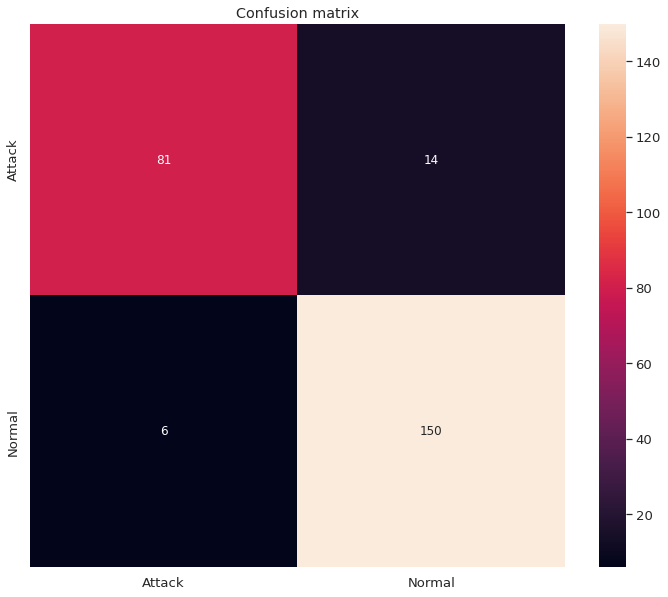

Done


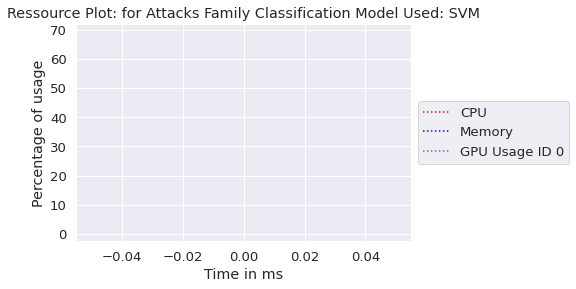

Evaluation of Attacks Family Classification Classification for SVM Algorithm
Precision:0.5529411764705883

Recall:0.5529411764705883

Accuracy:0.5529411764705883

Balanced Accuracy:0.5513963161021984

Matthews Correlation Coefficient:0.46589264071927466

AUPRC:0.5976470588235294

Time Taken: 73.63653182983398 ms



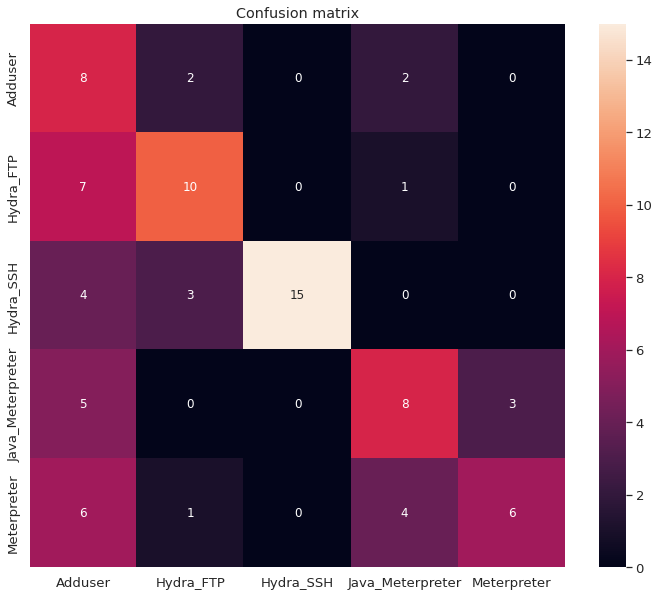

Dataset Used : 6-gramme


Pipeline : Training for Attack/Normal Classification Model Used: SVM <====> Attacks Family Classification Model Used: SVM
Done


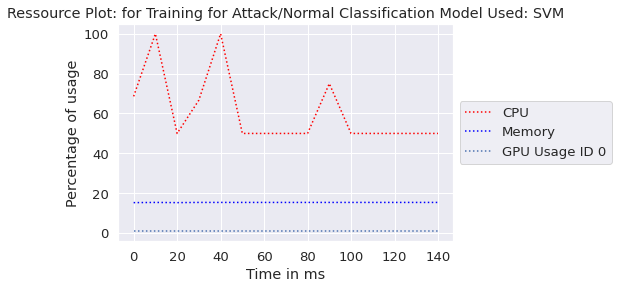

Evaluation of Attack/Normal Classification for SVM Algorithm
Precision:0.9043824701195219

Recall:0.9043824701195219

Accuracy:0.9043824701195219

Balanced Accuracy:0.8860323886639676

Matthews Correlation Coefficient:0.7959470080172353

AUPRC:0.9291898340703121

Time Taken: 173.7060546875 ms



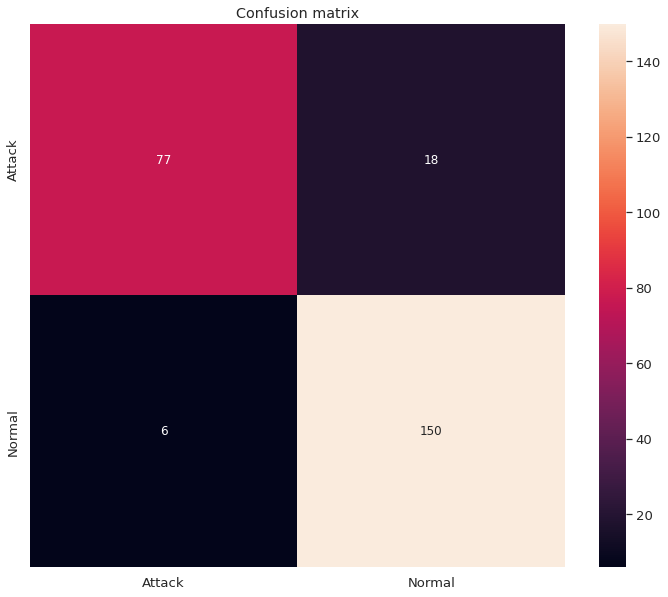

Done


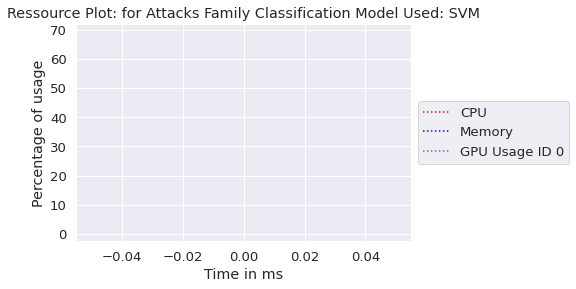

Evaluation of Attacks Family Classification Classification for SVM Algorithm
Precision:0.5294117647058824

Recall:0.5294117647058824

Accuracy:0.5294117647058824

Balanced Accuracy:0.5020499108734403

Matthews Correlation Coefficient:0.4184547204573215

AUPRC:0.5764705882352941

Time Taken: 67.46077537536621 ms



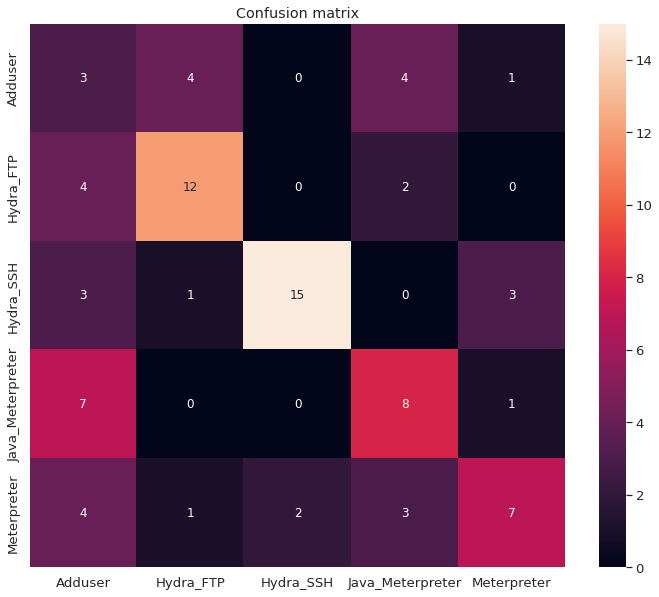

Model  Precision    Recall  Balanced Accuracy  \
0           CART   0.792829  0.792829           0.734548   
1           CART   0.188235  0.188235           0.205556   
2           CART   0.816733  0.816733           0.774359   
3           CART   0.211765  0.211765           0.233333   
4           CART   0.752988  0.752988           0.675742   
5           CART   0.211765  0.211765           0.200000   
6   RandomForest   0.952191  0.952191           0.940958   
7   RandomForest   0.635294  0.635294           0.612864   
8   RandomForest   0.936255  0.936255           0.921964   
9   RandomForest   0.576471  0.576471           0.573619   
10  RandomForest   0.908367  0.908367           0.905702   
11  RandomForest   0.588235  0.588235           0.579115   
12           KNN   0.896414  0.896414           0.891970   
13           KNN   0.564706  0.564706           0.573492   
14           KNN   0.888446  0.888446           0.889676   
15           KNN   0.529412  0.529412           0.546873   
16           KNN   0.888446  0.888446           0.891734   
17           KNN   0.435294  0.435294           0.456529   
18       XGBOOST   0.960159  0.960159           0.951484   
19       XGBOOST   0.635294  0.635294           0.624502   
20       XGBOOST   0.924303  0.924303           0.906174   
21       XGBOOST   0.600000  0.600000           0.585591   
22       XGBOOST   0.920319  0.920319           0.900911   
23       XGBOOST   0.541176  0.541176           0.529620   
24           MLP   0.964143  0.964143           0.958806   
25           MLP   0.658824  0.658824           0.643991   
26           MLP   0.936255  0.936255           0.932254   
27           MLP   0.600000  0.600000           0.575891   
28           MLP   0.920319  0.920319           0.915317   
29           MLP   0.635294  0.635294           0.597972   
30           SVM   0.944223  0.944223           0.936606   
31           SVM   0.623529  0.623529           0.602280   
32           SVM   0.920319  0.920319           0.907085   
33           SVM   0.552941  0.552941           0.551396   
34           SVM   0.904382  0.904382           0.886032   
35           SVM   0.529412  0.529412           0.502050   

    Matthews Correlation Coefficient     AUPRC   Time Taken  \
0                           0.565439  0.868508    32.202244   
1                           0.010233  0.269412    20.469904   
2                           0.607519  0.874864    44.490576   
3                           0.044657  0.290588    19.920349   
4                           0.492118  0.855923    29.119968   
5                           0.000000  0.290588    45.023680   
6                           0.898814  0.963766   455.458403   
7                           0.550533  0.671765   228.506088   
8                           0.864899  0.952224   318.554401   
9                           0.481155  0.618824   234.517336   
10                          0.806682  0.929970   329.958677   
11                          0.494064  0.629412   302.337170   
12                          0.780838  0.920815    22.367239   
13                          0.461270  0.608235    14.451504   
14                          0.768437  0.914500    14.394283   
15                          0.421411  0.576471    15.246868   
16                          0.770326  0.914589    16.097546   
17                          0.317428  0.491765    17.143011   
18                          0.915471  0.969562  2433.097363   
19                          0.547656  0.671765  8260.708570   
20                          0.840071  0.944043  2025.759697   
21                          0.506978  0.640000  7784.920692   
22                          0.831831  0.941381  2137.722492   
23                          0.437904  0.587059  9348.868608   
24                          0.923614  0.972513  4989.228725   
25                          0.575070  0.692941  2648.044586   
26                          0.864507  0.951374  3106.600285   
27                        

In [ ]:
md2 = Malware_Detection(dataset="ADFA-LD",optimization=False, lines=-1, verbose=False)
models = ['CART', 'RandomForest', 'KNN', 'XGBOOST', 'MLP' , 'SVM']

for x in models:
    md2.init_model(x,x,x)

In [ ]:
display(md2.output_evaluation)


Model  Precision    Recall  Balanced Accuracy  \
0           CART   0.792829  0.792829           0.734548   
1           CART   0.188235  0.188235           0.205556   
2           CART   0.816733  0.816733           0.774359   
3           CART   0.211765  0.211765           0.233333   
4           CART   0.752988  0.752988           0.675742   
5           CART   0.211765  0.211765           0.200000   
6   RandomForest   0.952191  0.952191           0.940958   
7   RandomForest   0.635294  0.635294           0.612864   
8   RandomForest   0.936255  0.936255           0.921964   
9   RandomForest   0.576471  0.576471           0.573619   
10  RandomForest   0.908367  0.908367           0.905702   
11  RandomForest   0.588235  0.588235           0.579115   
12           KNN   0.896414  0.896414           0.891970   
13           KNN   0.564706  0.564706           0.573492   
14           KNN   0.888446  0.888446           0.889676   
15           KNN   0.529412  0.529412           0.546873   
16           KNN   0.888446  0.888446           0.891734   
17           KNN   0.435294  0.435294           0.456529   
18       XGBOOST   0.960159  0.960159           0.951484   
19       XGBOOST   0.635294  0.635294           0.624502   
20       XGBOOST   0.924303  0.924303           0.906174   
21       XGBOOST   0.600000  0.600000           0.585591   
22       XGBOOST   0.920319  0.920319           0.900911   
23       XGBOOST   0.541176  0.541176           0.529620   
24           MLP   0.964143  0.964143           0.958806   
25           MLP   0.658824  0.658824           0.643991   
26           MLP   0.936255  0.936255           0.932254   
27           MLP   0.600000  0.600000           0.575891   
28           MLP   0.920319  0.920319           0.915317   
29           MLP   0.635294  0.635294           0.597972   
30           SVM   0.944223  0.944223           0.936606   
31           SVM   0.623529  0.623529           0.602280   
32           SVM   0.920319  0.920319           0.907085   
33           SVM   0.552941  0.552941           0.551396   
34           SVM   0.904382  0.904382           0.886032   
35           SVM   0.529412  0.529412           0.502050   

    Matthews Correlation Coefficient     AUPRC   Time Taken  \
0                           0.565439  0.868508    32.202244   
1                           0.010233  0.269412    20.469904   
2                           0.607519  0.874864    44.490576   
3                           0.044657  0.290588    19.920349   
4                           0.492118  0.855923    29.119968   
5                           0.000000  0.290588    45.023680   
6                           0.898814  0.963766   455.458403   
7                           0.550533  0.671765   228.506088   
8                           0.864899  0.952224   318.554401   
9                           0.481155  0.618824   234.517336   
10                          0.806682  0.929970   329.958677   
11                          0.494064  0.629412   302.337170   
12                          0.780838  0.920815    22.367239   
13                          0.461270  0.608235    14.451504   
14                          0.768437  0.914500    14.394283   
15                          0.421411  0.576471    15.246868   
16                          0.770326  0.914589    16.097546   
17                          0.317428  0.491765    17.143011   
18                          0.915471  0.969562  2433.097363   
19                          0.547656  0.671765  8260.708570   
20                          0.840071  0.944043  2025.759697   
21                          0.506978  0.640000  7784.920692   
22                          0.831831  0.941381  2137.722492   
23                          0.437904  0.587059  9348.868608   
24                          0.923614  0.972513  4989.228725   
25                          0.575070  0.692941  2648.044586   
26                          0.864507  0.951374  3106.600285   
27                        

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 12, 12


In [ ]:
import matplotlib.pyplot as plt

MLP Attack/normal 3gr 0.958806 \\
MLP Attacks Family Classification 3gr 0.643991
MLP Attack/Normal Classification 5gr 0.932254
RandomForest Attacks Family Classification 5gr 0.624272
MLP   Attack/Normal Classification 6gr 0.915317
MLP Attacks Family Classificati 6gr 0.597972

In [ ]:
#md2.output_evaluation.plot.barh(x='Model', y='Balanced Accuracy', rot=0)

# for i in range(0,6):
#     df = md2.output_evaluation[md2.output_evaluation.index%6 == i]
#     #df.plot.barh(x='Model', y='Balanced Accuracy', rot=0)
#     df

df = md2.output_evaluation[md2.output_evaluation.index%6 == 1]
#df.plot.barh(x='Model', y='Balanced Accuracy', rot=0)
df

Model  Precision    Recall  Balanced Accuracy  \
1           CART   0.188235  0.188235           0.205556   
7   RandomForest   0.635294  0.635294           0.612864   
13           KNN   0.564706  0.564706           0.573492   
19       XGBOOST   0.635294  0.635294           0.624502   
25           MLP   0.658824  0.658824           0.643991   
31           SVM   0.623529  0.623529           0.602280   

    Matthews Correlation Coefficient     AUPRC   Time Taken  \
1                           0.010233  0.269412    20.469904   
7                           0.550533  0.671765   228.506088   
13                          0.461270  0.608235    14.451504   
19                          0.547656  0.671765  8260.708570   
25                          0.575070  0.692941  2648.044586   
31                          0.532650  0.661176    63.275099   

                       Evaluation  
1   Attacks Family Classification  
7   Attacks Family Classification  
13  Attacks Family Classification  
19  Attacks Family Classification  
25  Attacks Family Classification  
31  Attacks Family Classification

Visualization of the dataset MalMen2020 in progress ... Method: PCA


NameError: ignored

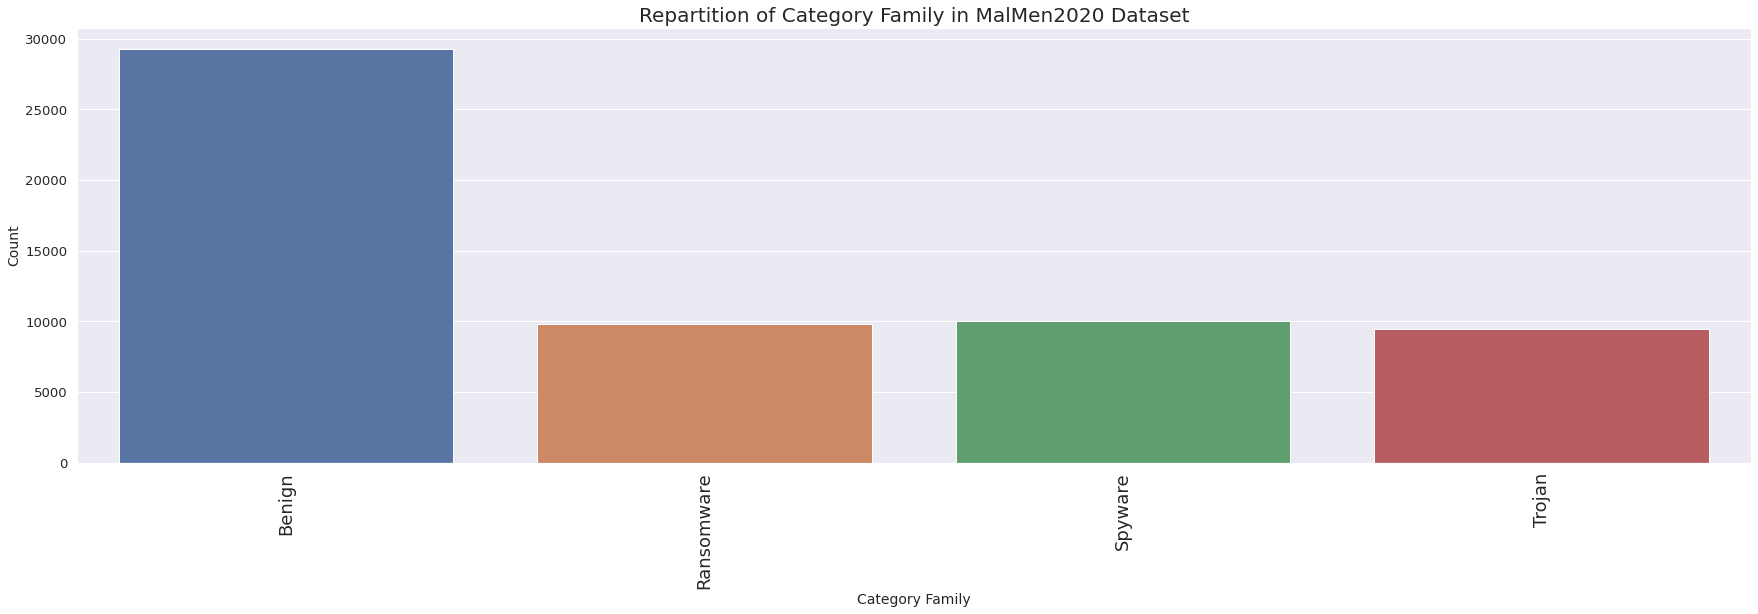

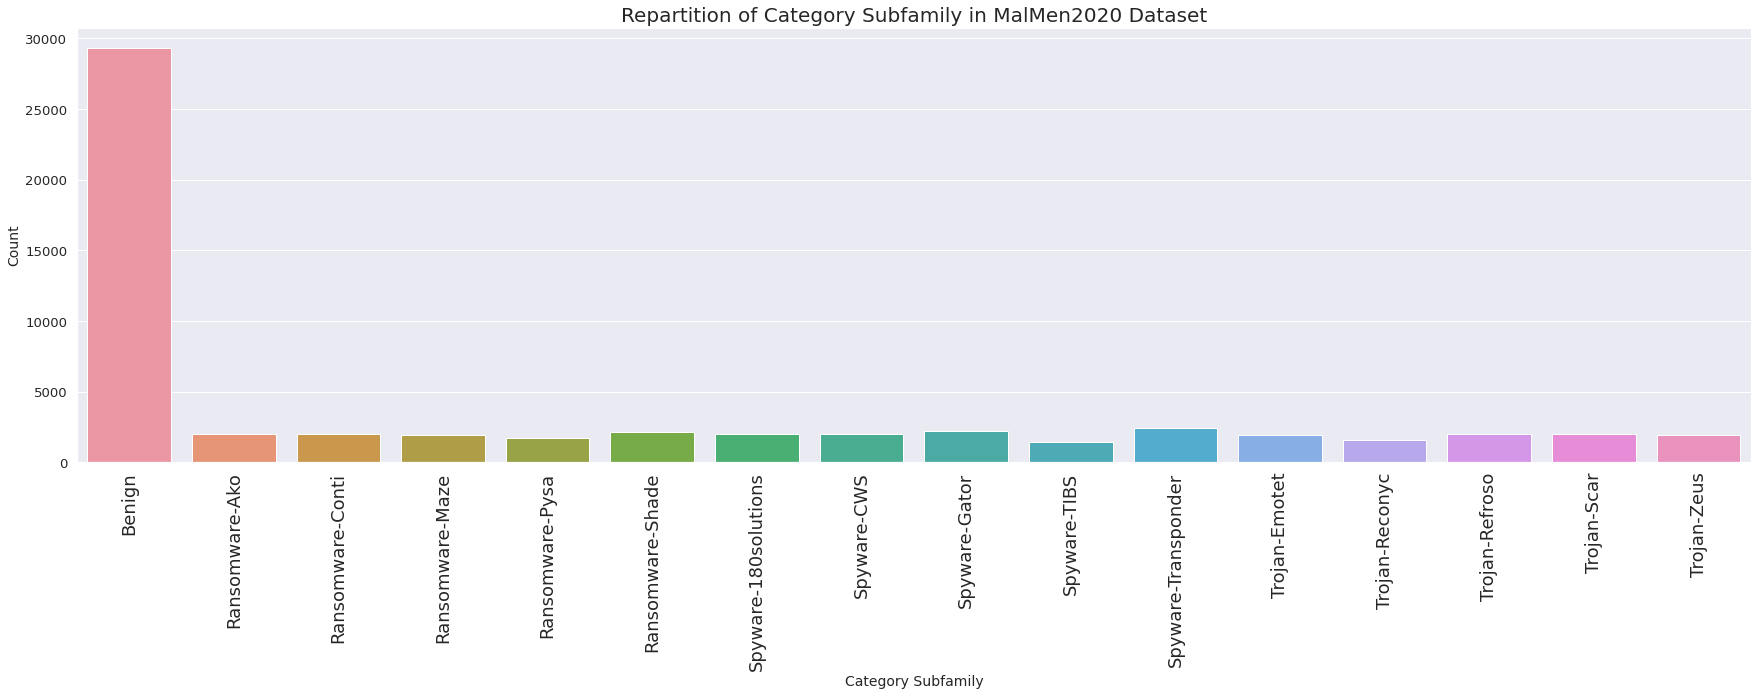

In [ ]:
md.visualization()

In [ ]:
md.visualization('TSNE')

In [ ]:
md.visualization('UMAP')